# GRU с автоподбором гиперпараметров с использованием Optuna

In [6]:
!pip install torchviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.8 MB/s eta 0:00:00


In [7]:
! pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.5/599.5 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.2 MB/s eta 0:00:00


In [8]:
import os
import json
import torchaudio
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import json
import torch.nn.functional as F
from torchviz import make_dot
from sklearn.model_selection import train_test_split
import optuna
import numpy as np
import csv
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from tqdm import tqdm

In [9]:
# Подключение Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Обработка и сохранение спектрограммы первого аудиофайла с использованием повторения данных
emotion_labels = {    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'}
# до достижения фиксированной длины спектрограммы
def pad_audio_with_repetition(spectrogram, target_length):
    while spectrogram.size(0) < target_length:
        spectrogram = torch.cat((spectrogram, spectrogram), dim=0)
    return spectrogram[:target_length, :]

def process_first_audio_file(root_dir, output_dir, target_length=16000):
    for actor_folder in os.listdir(root_dir):
        actor_path = os.path.join(root_dir, actor_folder)
        if os.path.isdir(actor_path):
            for file_name in os.listdir(actor_path):
                if file_name.endswith(".wav"):
                    file_path = os.path.join(actor_path, file_name)
                    label = emotion_labels[file_name.split("-")[2]]
                    audio, sample_rate = torchaudio.load(file_path)

                    # Преобразование аудиоданных в спектрограмму
                    spectrogram = torchaudio.transforms.MelSpectrogram(n_mels=64, n_fft=400)(audio)

                    # Преобразование спектрограммы в 2D тензор
                    spectrogram_2d = spectrogram.squeeze(0).transpose(0, 1)

                    # Выравнивание длины аудиофайлов с использованием данных из того же файла
                    spectrogram_2d = pad_audio_with_repetition(spectrogram_2d, target_length)

                    if spectrogram_2d.size(0) != target_length:
                        print(f'Пропущен файл: {file_path}, Длина спектрограммы: {spectrogram_2d.size(0)}')
                        return  # Пропустить файлы с длиной, отличной от target_length

                    # Сохранение данных в файл TXT
                    txt_file_path = os.path.join(output_dir, "first_audio_file.txt")
                    np.savetxt(txt_file_path, spectrogram_2d.numpy(), fmt='%.6f')
                    print(f'Спектрограмма сохранена в {txt_file_path}')

                    # Сохранение данных в файл JSON
                    json_file_path = os.path.join(output_dir, "first_audio_file.json")
                    with open(json_file_path, 'w') as json_file:
                        json.dump(spectrogram_2d.tolist(), json_file)
                    print(f'Спектрограмма сохранена в {json_file_path}')

                    # Сохранение данных в файл CSV
                    csv_file_path = os.path.join(output_dir, "first_audio_file.csv")
                    with open(csv_file_path, 'w', newline='') as csv_file:
                        writer = csv.writer(csv_file)
                        writer.writerows(spectrogram_2d.numpy())
                    print(f'Спектрограмма сохранена в {csv_file_path}')

                    return

# Для первого файла
root_dir = "/content/drive/MyDrive/DS_Belhard_2/Homeworks/HW_5/Audio_Speech_Actors_01-24"
output_dir = "/content/drive/MyDrive/DS_Belhard_2/Homeworks/HW_5/DS_2_HW_5_final_v2/"
process_first_audio_file(root_dir, output_dir)

Спектрограмма сохранена в /content/drive/MyDrive/DS_Belhard_2/Homeworks/HW_5/DS_2_HW_5_final_v2/first_audio_file.txt
Спектрограмма сохранена в /content/drive/MyDrive/DS_Belhard_2/Homeworks/HW_5/DS_2_HW_5_final_v2/first_audio_file.json
Спектрограмма сохранена в /content/drive/MyDrive/DS_Belhard_2/Homeworks/HW_5/DS_2_HW_5_final_v2/first_audio_file.csv


In [10]:
emotion_labels = {    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'}

def pad_audio_with_repetition(spectrogram, target_length):
    while spectrogram.size(0) < target_length:
        spectrogram = torch.cat((spectrogram, spectrogram), dim=0)
    return spectrogram[:target_length, :]

def prepare_and_split_dataset(root_dir, train_file_path, val_file_path, target_length=16000, test_size=0.2, random_state=42):
    # Создаем и открываем файлы для записи
    with open(train_file_path, 'w') as train_file, open(val_file_path, 'w') as val_file:
        train_file.write('[')
        val_file.write('[')
        first_train = True
        first_val = True

        for actor_folder in os.listdir(root_dir):
            actor_path = os.path.join(root_dir, actor_folder)
            if os.path.isdir(actor_path):
                for file_name in os.listdir(actor_path):
                    if file_name.endswith(".wav"):
                        file_path = os.path.join(actor_path, file_name)
                        label = emotion_labels[file_name.split("-")[2]]
                        audio, sample_rate = torchaudio.load(file_path)

                        # Преобразование аудиоданных в спектрограмму
                        spectrogram = torchaudio.transforms.MelSpectrogram(n_mels=64, n_fft=400)(audio)

                        # Преобразование спектрограммы в 2D тензор
                        spectrogram_2d = spectrogram.squeeze(0).transpose(0, 1)

                        # Выравнивание длины аудиофайлов с использованием данных из того же файла
                        spectrogram_2d = pad_audio_with_repetition(spectrogram_2d, target_length)

                        if spectrogram_2d.size(0) != target_length:
                            print(f'Пропущен файл: {file_path}, Длина спектрограммы: {spectrogram_2d.size(0)}')
                            continue  # Пропустить файлы с длиной, отличной от target_length

                        entry = {
                            "audio": {
                                "array": spectrogram_2d.tolist(),
                                "sampling_rate": sample_rate
                            },
                            "label": label
                        }

                        # Разделение данных на обучающую и валидационную выборки
                        if torch.rand(1).item() > test_size:
                            if not first_train:
                                train_file.write(',')
                            train_file.write(json.dumps(entry))
                            first_train = False
                        else:
                            if not first_val:
                                val_file.write(',')
                            val_file.write(json.dumps(entry))
                            first_val = False

                        # Выводим информацию о каждом обработанном файле
                        print(f'Файл: {file_path}, Метка: {label}')

        train_file.write(']')
        val_file.write(']')

    print(f"Датасет разделен и сохранен в файлы: {train_file_path} и {val_file_path}")

In [32]:
root_dir = "/content/drive/MyDrive/DS_Belhard_2/Homeworks/HW_5/Audio_Speech_Actors_01-24"
train_file = "/content/drive/MyDrive/DS_Belhard_2/Homeworks/HW_5/DS_2_HW_5_final_v2/dataset_train_2.json"
val_file = "/content/drive/MyDrive/DS_Belhard_2/Homeworks/HW_5/DS_2_HW_5_final_v2/dataset_val_2.json"
prepare_and_split_dataset(root_dir, train_file, val_file)

Файл: /content/drive/MyDrive/DS_Belhard_2/Homeworks/HW_5/Audio_Speech_Actors_01-24/Actor_02/03-01-01-01-01-01-02.wav, Метка: neutral
Файл: /content/drive/MyDrive/DS_Belhard_2/Homeworks/HW_5/Audio_Speech_Actors_01-24/Actor_02/03-01-01-01-02-01-02.wav, Метка: neutral
Файл: /content/drive/MyDrive/DS_Belhard_2/Homeworks/HW_5/Audio_Speech_Actors_01-24/Actor_02/03-01-01-01-01-02-02.wav, Метка: neutral
Файл: /content/drive/MyDrive/DS_Belhard_2/Homeworks/HW_5/Audio_Speech_Actors_01-24/Actor_02/03-01-02-01-02-01-02.wav, Метка: calm
Файл: /content/drive/MyDrive/DS_Belhard_2/Homeworks/HW_5/Audio_Speech_Actors_01-24/Actor_02/03-01-01-01-02-02-02.wav, Метка: neutral
Файл: /content/drive/MyDrive/DS_Belhard_2/Homeworks/HW_5/Audio_Speech_Actors_01-24/Actor_02/03-01-02-02-01-01-02.wav, Метка: calm
Файл: /content/drive/MyDrive/DS_Belhard_2/Homeworks/HW_5/Audio_Speech_Actors_01-24/Actor_02/03-01-02-02-02-01-02.wav, Метка: calm
Файл: /content/drive/MyDrive/DS_Belhard_2/Homeworks/HW_5/Audio_Speech_Actors_0

In [11]:
# Класс для датасета эмоций
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, file_path):
        self.data = self.load_data(file_path)
        self.label_map = {
            'neutral': 0, 'calm': 1, 'happy': 2, 'sad': 3,
            'angry': 4, 'fearful': 5, 'disgust': 6, 'surprised': 7
        }

    def load_data(self, file_path):
        with open(file_path, 'r') as f:
            data = json.load(f)
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        audio = torch.tensor(item['audio']['array'], dtype=torch.float32)
        label = torch.tensor(self.label_map[item['label']], dtype=torch.long)  # Преобразование метки в числовое значение
        return audio, label

def collate_fn(batch):
    audios, labels = zip(*batch)
    max_length = max(audio.size(0) for audio in audios)
    padded_audios = []
    valid_labels = []
    for audio, label in zip(audios, labels):
        if audio.size(0) == 16000 and audio.dim() == 2:
            padded_audios.append(torch.cat([audio, torch.zeros(max_length - audio.size(0), audio.size(1))]))
            valid_labels.append(label)
    return torch.stack(padded_audios), torch.tensor(valid_labels)

# Модель GRU
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.gru.num_layers, x.size(0), self.gru.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

def train_model(train_file, val_file, output_dir, num_epochs, batch_size, learning_rate, num_workers=4):
    print("Загрузка датасета...")
    train_dataset = EmotionDataset(train_file)
    val_dataset = EmotionDataset(val_file)

    print("Загрузка данных в DataLoader...")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)
    print("Датасет загружен в DataLoader.")

    input_size = train_dataset[0][0].size(1)  # Количество мел-банов (64)
    hidden_size = 64
    num_layers = 2
    num_classes = 8

    model = GRUModel(input_size, hidden_size, num_layers, num_classes)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    print("Оптимизатор и функция потерь инициализированы.")

    print("Начало обучения модели...")
    total_steps = len(train_loader) * num_epochs
    current_step = 0
    epoch_losses = []
    all_preds = []
    all_labels = []

    for epoch in tqdm(range(num_epochs), desc="Эпохи обучения"):
        print(f"Начало эпохи {epoch+1}...")
        model.train()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(tqdm(train_loader, desc="Обучение", leave=False)):
            try:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                current_step += 1
                progress = (current_step / total_steps) * 100
                print(f'Обучение: {progress:.2f}% завершено')

                # Сохранение предсказаний и меток для вычисления метрик
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
            except RuntimeError as e:
                print(f"Ошибка во время обучения: {e}")
                continue

        epoch_loss = running_loss / len(train_loader)
        epoch_losses.append(epoch_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    os.makedirs(output_dir, exist_ok=True)
    model_save_path = os.path.join(output_dir, 'emotion_recognition_model.pth')
    torch.save(model, model_save_path)
    print(f'Модель сохранена в {model_save_path}')

    # Вычисление метрик
    accuracy = accuracy_score(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    print(f'Accuracy: {accuracy:.4f}')

    # Сохранение весов модели
    weights_save_path = os.path.join(output_dir, 'emotion_recognition_weights.pth')
    torch.save(model.state_dict(), weights_save_path)
    print(f'Веса модели сохранены в {weights_save_path}')

    # Построение графика потерь
    plt.figure()
    plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.savefig(os.path.join(output_dir, 'training_loss.png'))
    plt.show()
    print("График обучения сохранен и отображен.")

    # Построение матрицы ошибок
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(emotion_labels.values()), yticklabels=list(emotion_labels.values()))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
    plt.show()
    print("Матрица ошибок сохранена и отображена.")

def objective(trial):
    # Гиперпараметры для подбора
    num_epochs = trial.suggest_int('num_epochs', 10, 50, step=5)
    batch_size = trial.suggest_int('batch_size', 16, 64, step=16)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    hidden_size = trial.suggest_int('hidden_size', 32, 128, step=32)
    num_layers = trial.suggest_int('num_layers', 1, 3, step=1)

    # Загрузка датасета
    train_dataset = EmotionDataset(train_file)
    val_dataset = EmotionDataset(val_file)

    # Загрузка данных в DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)

    input_size = train_dataset[0][0].size(1)  # Количество мел-банов (64)
    num_classes = 8

    model = GRUModel(input_size, hidden_size, num_layers, num_classes)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Обучение модели
    epoch_losses = []
    for epoch in tqdm(range(num_epochs), desc="Эпохи обучения"):
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc="Обучение", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        epoch_losses.append(epoch_loss)

    # Оценка модели
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)

    # Построение графика потерь
    plt.figure()
    plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.savefig(os.path.join(output_dir, f'training_loss_trial_{trial.number}.png'))
    plt.show()

    return accuracy

Сохранение модели и весов:

emotion_recognition_model.pth: Содержит всю архитектуру модели.

emotion_recognition_weights.pth: Содержит обученные веса модели.

In [12]:
if __name__ == "__main__":
    train_file = "/content/drive/MyDrive/DS_Belhard_2/Homeworks/HW_5/DS_2_HW_5_final_v2/dataset_train_2.json"
    val_file = "/content/drive/MyDrive/DS_Belhard_2/Homeworks/HW_5/DS_2_HW_5_final_v2/dataset_val_2.json"
    output_dir = "/content/drive/MyDrive/DS_Belhard_2/Homeworks/HW_5/DS_2_HW_5_final_v2/"

    #study = optuna.create_study(direction='maximize')
    #study.optimize(objective, n_trials=10)

    #print("Лучшие гиперпараметры: ", study.best_params)

Первый запуск (на 50 эпохах): [I 2024-12-21 07:52:29,707] Trial 0 finished with value: 0.2508833922261484 and parameters: {'num_epochs': 50, 'batch_size': 32, 'learning_rate': 0.0008578837882612659, 'hidden_size': 32, 'num_layers': 3}. Best is trial 0 with value: 0.2508833922261484.

Второй в процессе оборвался, и так как подбор гиперпараметров на V2-8 TPU на 50 эпохах занял около суток - повторять не стала

Результат 0.2508833922261484 означает, что точность модели составляет примерно 25%. Это не высокий показатель, но это первый пробный запуск.

Что можно предпринять для улучшения модели:

1. Продолжить оптимизацию: Провести больше испытаний с Optuna, чтобы найти лучшие гиперпараметры.

2. Аугментация данных: Использовать методы аугментации данных, такие как добавление шума или изменение скорости воспроизведения, чтобы увеличить разнообразие данных.

3. Увеличение данных: Добавление большего количества данных для обучения модели.

4. Изменение архитектуры модели, например, добавить больше слоев или изменить тип слоев.

In [13]:
# Обучение модели с лучшими гиперпараметрами
    #best_params = study.best_params
    #train_model(train_file, val_file, output_dir, num_epochs=best_params['num_epochs'], batch_size=best_params['batch_size'], learning_rate=best_params['learning_rate'], num_workers=4)

# Обучение модели с готовыми гиперпараметрами

In [14]:
# Класс для датасета эмоций
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, file_path):
        self.data = self.load_data(file_path)
        self.label_map = {
            'neutral': 0, 'calm': 1, 'happy': 2, 'sad': 3,
            'angry': 4, 'fearful': 5, 'disgust': 6, 'surprised': 7
        }

    def load_data(self, file_path):
        with open(file_path, 'r') as f:
            data = json.load(f)
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        audio = torch.tensor(item['audio']['array'], dtype=torch.float32)
        label = torch.tensor(self.label_map[item['label']], dtype=torch.long)  # Преобразование метки в числовое значение
        return audio, label

def collate_fn(batch):
    audios, labels = zip(*batch)
    max_length = max(audio.size(0) for audio in audios)
    padded_audios = []
    valid_labels = []
    for audio, label in zip(audios, labels):
        if audio.size(0) == 16000 and audio.dim() == 2:
            padded_audios.append(torch.cat([audio, torch.zeros(max_length - audio.size(0), audio.size(1))]))
            valid_labels.append(label)
    return torch.stack(padded_audios), torch.tensor(valid_labels)

# Модель GRU
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.gru.num_layers, x.size(0), self.gru.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

def train_model(train_file, val_file, output_dir, num_epochs=50, batch_size=32, learning_rate=0.0008578837882612659, num_workers=4):
    print("Загрузка датасета...")
    train_dataset = EmotionDataset(train_file)
    val_dataset = EmotionDataset(val_file)

    print("Загрузка данных в DataLoader...")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)
    print("Датасет загружен в DataLoader.")

    input_size = train_dataset[0][0].size(1)  # Количество мел-банов (64)
    hidden_size = 32
    num_layers = 3
    num_classes = 8

    model = GRUModel(input_size, hidden_size, num_layers, num_classes)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    print("Оптимизатор и функция потерь инициализированы.")

    print("Начало обучения модели...")
    total_steps = len(train_loader) * num_epochs
    current_step = 0
    epoch_losses = []
    all_preds = []
    all_labels = []

    for epoch in tqdm(range(num_epochs), desc="Эпохи обучения"):
        print(f"Начало эпохи {epoch+1}...")
        model.train()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(tqdm(train_loader, desc="Обучение", leave=False)):
            try:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                current_step += 1
                progress = (current_step / total_steps) * 100
                print(f'Обучение: {progress:.2f}% завершено')

                # Сохранение предсказаний и меток для вычисления метрик
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
            except RuntimeError as e:
                print(f"Ошибка во время обучения: {e}")
                continue

        epoch_loss = running_loss / len(train_loader)
        epoch_losses.append(epoch_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    os.makedirs(output_dir, exist_ok=True)
    model_save_path = os.path.join(output_dir, 'emotion_recognition_model.pth')
    torch.save(model, model_save_path)
    print(f'Модель сохранена в {model_save_path}')

    # Вычисление метрик
    accuracy = accuracy_score(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    print(f'Accuracy: {accuracy:.4f}')

    # Сохранение весов модели
    weights_save_path = os.path.join(output_dir, 'emotion_recognition_weights.pth')
    torch.save(model.state_dict(), weights_save_path)
    print(f'Веса модели сохранены в {weights_save_path}')

    # Построение графика потерь
    plt.figure()
    plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.savefig(os.path.join(output_dir, 'training_loss.png'))
    plt.show()
    print("График обучения сохранен и отображен.")

    # Построение матрицы ошибок
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(emotion_labels.values()), yticklabels=list(emotion_labels.values()))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
    plt.show()
    print("Матрица ошибок сохранена и отображена.")

Загрузка датасета...
Загрузка данных в DataLoader...
Датасет загружен в DataLoader.
Оптимизатор и функция потерь инициализированы.
Начало обучения модели...


Эпохи обучения:   0%|          | 0/50 [00:00<?, ?it/s]

Начало эпохи 1...



Обучение:   3%|▎         | 1/37 [00:24<14:40, 24.46s/it]

Обучение: 0.05% завершено
Обучение: 0.11% завершено



Обучение:   5%|▌         | 2/37 [00:40<11:19, 19.43s/it]

Обучение: 0.16% завершено



Обучение:   8%|▊         | 3/37 [00:56<10:03, 17.75s/it]

Обучение: 0.22% завершено



Обучение:  11%|█         | 4/37 [01:12<09:22, 17.04s/it]

Обучение: 0.27% завершено



Обучение:  14%|█▎        | 5/37 [01:27<08:51, 16.60s/it]

Обучение: 0.32% завершено



Обучение:  16%|█▌        | 6/37 [01:43<08:24, 16.27s/it]

Обучение: 0.38% завершено



Обучение:  19%|█▉        | 7/37 [01:59<08:03, 16.11s/it]

Обучение: 0.43% завершено



Обучение:  22%|██▏       | 8/37 [02:15<07:45, 16.06s/it]

Обучение: 0.49% завершено



Обучение:  24%|██▍       | 9/37 [02:31<07:27, 15.98s/it]

Обучение: 0.54% завершено



Обучение:  27%|██▋       | 10/37 [02:46<07:09, 15.91s/it]

Обучение: 0.59% завершено



Обучение:  30%|██▉       | 11/37 [03:02<06:54, 15.96s/it]

Обучение: 0.65% завершено



Обучение:  32%|███▏      | 12/37 [03:18<06:35, 15.81s/it]

Обучение: 0.70% завершено



Обучение:  35%|███▌      | 13/37 [03:33<06:16, 15.69s/it]

Обучение: 0.76% завершено



Обучение:  38%|███▊      | 14/37 [03:49<06:02, 15.77s/it]

Обучение: 0.81% завершено



Обучение:  41%|████      | 15/37 [04:05<05:44, 15.67s/it]

Обучение: 0.86% завершено



Обучение:  43%|████▎     | 16/37 [04:20<05:30, 15.72s/it]

Обучение: 0.92% завершено



Обучение:  46%|████▌     | 17/37 [04:37<05:16, 15.83s/it]

Обучение: 0.97% завершено



Обучение:  49%|████▊     | 18/37 [04:53<05:03, 15.95s/it]

Обучение: 1.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:09<04:47, 15.98s/it]

Обучение: 1.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:25<04:31, 15.97s/it]

Обучение: 1.14% завершено



Обучение:  57%|█████▋    | 21/37 [05:40<04:13, 15.87s/it]

Обучение: 1.19% завершено



Обучение:  59%|█████▉    | 22/37 [05:57<04:00, 16.01s/it]

Обучение: 1.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:13<03:44, 16.03s/it]

Обучение: 1.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:29<03:27, 15.96s/it]

Обучение: 1.35% завершено



Обучение:  68%|██████▊   | 25/37 [06:44<03:09, 15.82s/it]

Обучение: 1.41% завершено



Обучение:  70%|███████   | 26/37 [07:00<02:52, 15.73s/it]

Обучение: 1.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:15<02:37, 15.71s/it]

Обучение: 1.51% завершено



Обучение:  76%|███████▌  | 28/37 [07:31<02:21, 15.75s/it]

Обучение: 1.57% завершено



Обучение:  78%|███████▊  | 29/37 [07:47<02:06, 15.77s/it]

Обучение: 1.62% завершено



Обучение:  81%|████████  | 30/37 [08:03<01:50, 15.81s/it]

Обучение: 1.68% завершено



Обучение:  84%|████████▍ | 31/37 [08:19<01:34, 15.82s/it]

Обучение: 1.73% завершено



Обучение:  86%|████████▋ | 32/37 [08:34<01:18, 15.77s/it]

Обучение: 1.78% завершено



Обучение:  89%|████████▉ | 33/37 [08:50<01:03, 15.79s/it]

Обучение: 1.84% завершено



Обучение:  92%|█████████▏| 34/37 [09:06<00:47, 15.80s/it]

Обучение: 1.89% завершено



Обучение:  95%|█████████▍| 35/37 [09:22<00:31, 15.81s/it]

Обучение: 1.95% завершено



Обучение:  97%|█████████▋| 36/37 [09:38<00:15, 15.78s/it]

Обучение: 2.00% завершено



Эпохи обучения:   2%|▏         | 1/50 [09:52<8:04:08, 592.83s/it]

Epoch [1/50], Loss: 2.0715
Начало эпохи 2...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 2.05% завершено



Обучение:   3%|▎         | 1/37 [00:29<17:51, 29.75s/it]

Обучение: 2.11% завершено



Обучение:   5%|▌         | 2/37 [00:48<13:35, 23.31s/it]

Обучение: 2.16% завершено



Обучение:   8%|▊         | 3/37 [01:05<11:35, 20.46s/it]

Обучение: 2.22% завершено



Обучение:  11%|█         | 4/37 [01:22<10:25, 18.96s/it]

Обучение: 2.27% завершено



Обучение:  14%|█▎        | 5/37 [01:39<09:42, 18.20s/it]

Обучение: 2.32% завершено



Обучение:  16%|█▌        | 6/37 [01:56<09:10, 17.75s/it]

Обучение: 2.38% завершено



Обучение:  19%|█▉        | 7/37 [02:12<08:44, 17.49s/it]

Обучение: 2.43% завершено



Обучение:  22%|██▏       | 8/37 [02:29<08:21, 17.28s/it]

Обучение: 2.49% завершено



Обучение:  24%|██▍       | 9/37 [02:46<07:59, 17.11s/it]

Обучение: 2.54% завершено



Обучение:  27%|██▋       | 10/37 [03:03<07:38, 16.99s/it]

Обучение: 2.59% завершено



Обучение:  30%|██▉       | 11/37 [03:20<07:21, 16.99s/it]

Обучение: 2.65% завершено



Обучение:  32%|███▏      | 12/37 [03:37<07:03, 16.92s/it]

Обучение: 2.70% завершено



Обучение:  35%|███▌      | 13/37 [03:53<06:42, 16.77s/it]

Обучение: 2.76% завершено



Обучение:  38%|███▊      | 14/37 [04:10<06:24, 16.72s/it]

Обучение: 2.81% завершено



Обучение:  41%|████      | 15/37 [04:26<06:05, 16.60s/it]

Обучение: 2.86% завершено



Обучение:  43%|████▎     | 16/37 [04:42<05:47, 16.55s/it]

Обучение: 2.92% завершено



Обучение:  46%|████▌     | 17/37 [04:59<05:31, 16.55s/it]

Обучение: 2.97% завершено



Обучение:  49%|████▊     | 18/37 [05:16<05:15, 16.61s/it]

Обучение: 3.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:32<04:59, 16.65s/it]

Обучение: 3.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:49<04:41, 16.55s/it]

Обучение: 3.14% завершено



Обучение:  57%|█████▋    | 21/37 [06:05<04:25, 16.62s/it]

Обучение: 3.19% завершено



Обучение:  59%|█████▉    | 22/37 [06:23<04:11, 16.77s/it]

Обучение: 3.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:39<03:55, 16.82s/it]

Обучение: 3.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:56<03:38, 16.84s/it]

Обучение: 3.35% завершено



Обучение:  68%|██████▊   | 25/37 [07:13<03:21, 16.78s/it]

Обучение: 3.41% завершено



Обучение:  70%|███████   | 26/37 [07:30<03:04, 16.73s/it]

Обучение: 3.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:46<02:46, 16.64s/it]

Обучение: 3.51% завершено



Обучение:  76%|███████▌  | 28/37 [08:02<02:29, 16.58s/it]

Обучение: 3.57% завершено



Обучение:  78%|███████▊  | 29/37 [08:20<02:14, 16.76s/it]

Обучение: 3.62% завершено



Обучение:  81%|████████  | 30/37 [08:37<01:57, 16.80s/it]

Обучение: 3.68% завершено



Обучение:  84%|████████▍ | 31/37 [08:53<01:40, 16.75s/it]

Обучение: 3.73% завершено



Обучение:  86%|████████▋ | 32/37 [09:10<01:23, 16.68s/it]

Обучение: 3.78% завершено



Обучение:  89%|████████▉ | 33/37 [09:26<01:06, 16.67s/it]

Обучение: 3.84% завершено



Обучение:  92%|█████████▏| 34/37 [09:43<00:50, 16.75s/it]

Обучение: 3.89% завершено



Обучение:  95%|█████████▍| 35/37 [10:00<00:33, 16.80s/it]

Обучение: 3.95% завершено



Обучение:  97%|█████████▋| 36/37 [10:17<00:16, 16.72s/it]

Обучение: 4.00% завершено



Эпохи обучения:   4%|▍         | 2/50 [20:26<8:13:16, 616.59s/it]

Epoch [2/50], Loss: 2.0476
Начало эпохи 3...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 4.05% завершено



Обучение:   3%|▎         | 1/37 [00:31<19:04, 31.81s/it]

Обучение: 4.11% завершено



Обучение:   5%|▌         | 2/37 [00:49<13:50, 23.72s/it]

Обучение: 4.16% завершено



Обучение:   8%|▊         | 3/37 [01:06<11:35, 20.46s/it]

Обучение: 4.22% завершено



Обучение:  11%|█         | 4/37 [01:22<10:23, 18.88s/it]

Обучение: 4.27% завершено



Обучение:  14%|█▎        | 5/37 [01:39<09:37, 18.06s/it]

Обучение: 4.32% завершено



Обучение:  16%|█▌        | 6/37 [01:57<09:17, 18.00s/it]

Обучение: 4.38% завершено



Обучение:  19%|█▉        | 7/37 [02:13<08:44, 17.48s/it]

Обучение: 4.43% завершено



Обучение:  22%|██▏       | 8/37 [02:30<08:18, 17.18s/it]

Обучение: 4.49% завершено



Обучение:  24%|██▍       | 9/37 [02:47<07:57, 17.05s/it]

Обучение: 4.54% завершено



Обучение:  27%|██▋       | 10/37 [03:03<07:35, 16.87s/it]

Обучение: 4.59% завершено



Обучение:  30%|██▉       | 11/37 [03:20<07:17, 16.82s/it]

Обучение: 4.65% завершено



Обучение:  32%|███▏      | 12/37 [03:37<06:59, 16.79s/it]

Обучение: 4.70% завершено



Обучение:  35%|███▌      | 13/37 [03:54<06:45, 16.90s/it]

Обучение: 4.76% завершено



Обучение:  38%|███▊      | 14/37 [04:11<06:28, 16.91s/it]

Обучение: 4.81% завершено



Обучение:  41%|████      | 15/37 [04:27<06:10, 16.83s/it]

Обучение: 4.86% завершено



Обучение:  43%|████▎     | 16/37 [04:44<05:53, 16.82s/it]

Обучение: 4.92% завершено



Обучение:  46%|████▌     | 17/37 [05:01<05:35, 16.80s/it]

Обучение: 4.97% завершено



Обучение:  49%|████▊     | 18/37 [05:18<05:18, 16.78s/it]

Обучение: 5.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:34<05:01, 16.73s/it]

Обучение: 5.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:51<04:45, 16.78s/it]

Обучение: 5.14% завершено



Обучение:  57%|█████▋    | 21/37 [06:08<04:27, 16.69s/it]

Обучение: 5.19% завершено



Обучение:  59%|█████▉    | 22/37 [06:24<04:10, 16.69s/it]

Обучение: 5.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:40<03:51, 16.56s/it]

Обучение: 5.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:57<03:34, 16.53s/it]

Обучение: 5.35% завершено



Обучение:  68%|██████▊   | 25/37 [07:13<03:18, 16.51s/it]

Обучение: 5.41% завершено



Обучение:  70%|███████   | 26/37 [07:30<03:00, 16.45s/it]

Обучение: 5.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:46<02:43, 16.40s/it]

Обучение: 5.51% завершено



Обучение:  76%|███████▌  | 28/37 [08:02<02:27, 16.38s/it]

Обучение: 5.57% завершено



Обучение:  78%|███████▊  | 29/37 [08:18<02:09, 16.25s/it]

Обучение: 5.62% завершено



Обучение:  81%|████████  | 30/37 [08:34<01:53, 16.19s/it]

Обучение: 5.68% завершено



Обучение:  84%|████████▍ | 31/37 [08:51<01:38, 16.34s/it]

Обучение: 5.73% завершено



Обучение:  86%|████████▋ | 32/37 [09:08<01:22, 16.45s/it]

Обучение: 5.78% завершено



Обучение:  89%|████████▉ | 33/37 [09:24<01:05, 16.40s/it]

Обучение: 5.84% завершено



Обучение:  92%|█████████▏| 34/37 [09:40<00:48, 16.28s/it]

Обучение: 5.89% завершено



Обучение:  95%|█████████▍| 35/37 [09:56<00:32, 16.32s/it]

Обучение: 5.95% завершено



Обучение:  97%|█████████▋| 36/37 [10:13<00:16, 16.35s/it]

Обучение: 6.00% завершено



Эпохи обучения:   6%|▌         | 3/50 [30:54<8:07:16, 622.06s/it]

Epoch [3/50], Loss: 2.0304
Начало эпохи 4...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 6.05% завершено



Обучение:   3%|▎         | 1/37 [00:28<17:18, 28.85s/it]

Обучение: 6.11% завершено



Обучение:   5%|▌         | 2/37 [00:44<12:25, 21.30s/it]

Обучение: 6.16% завершено



Обучение:   8%|▊         | 3/37 [01:03<11:15, 19.86s/it]

Обучение: 6.22% завершено



Обучение:  11%|█         | 4/37 [01:19<10:14, 18.62s/it]

Обучение: 6.27% завершено



Обучение:  14%|█▎        | 5/37 [01:35<09:25, 17.66s/it]

Обучение: 6.32% завершено



Обучение:  16%|█▌        | 6/37 [01:51<08:50, 17.11s/it]

Обучение: 6.38% завершено



Обучение:  19%|█▉        | 7/37 [02:07<08:21, 16.72s/it]

Обучение: 6.43% завершено



Обучение:  22%|██▏       | 8/37 [02:23<07:57, 16.48s/it]

Обучение: 6.49% завершено



Обучение:  24%|██▍       | 9/37 [02:39<07:38, 16.39s/it]

Обучение: 6.54% завершено



Обучение:  27%|██▋       | 10/37 [02:55<07:17, 16.21s/it]

Обучение: 6.59% завершено



Обучение:  30%|██▉       | 11/37 [03:11<06:58, 16.10s/it]

Обучение: 6.65% завершено



Обучение:  32%|███▏      | 12/37 [03:27<06:41, 16.07s/it]

Обучение: 6.70% завершено



Обучение:  35%|███▌      | 13/37 [03:45<06:38, 16.62s/it]

Обучение: 6.76% завершено



Обучение:  38%|███▊      | 14/37 [04:03<06:31, 17.03s/it]

Обучение: 6.81% завершено



Обучение:  41%|████      | 15/37 [04:20<06:18, 17.20s/it]

Обучение: 6.86% завершено



Обучение:  43%|████▎     | 16/37 [04:38<06:03, 17.29s/it]

Обучение: 6.92% завершено



Обучение:  46%|████▌     | 17/37 [04:56<05:47, 17.38s/it]

Обучение: 6.97% завершено



Обучение:  49%|████▊     | 18/37 [05:13<05:30, 17.39s/it]

Обучение: 7.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:31<05:15, 17.53s/it]

Обучение: 7.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:49<04:59, 17.62s/it]

Обучение: 7.14% завершено



Обучение:  57%|█████▋    | 21/37 [06:06<04:41, 17.60s/it]

Обучение: 7.19% завершено



Обучение:  59%|█████▉    | 22/37 [06:23<04:22, 17.51s/it]

Обучение: 7.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:41<04:07, 17.66s/it]

Обучение: 7.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:59<03:49, 17.63s/it]

Обучение: 7.35% завершено



Обучение:  68%|██████▊   | 25/37 [07:17<03:32, 17.72s/it]

Обучение: 7.41% завершено



Обучение:  70%|███████   | 26/37 [07:35<03:14, 17.67s/it]

Обучение: 7.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:52<02:57, 17.75s/it]

Обучение: 7.51% завершено



Обучение:  76%|███████▌  | 28/37 [08:10<02:39, 17.70s/it]

Обучение: 7.57% завершено



Обучение:  78%|███████▊  | 29/37 [08:28<02:21, 17.69s/it]

Обучение: 7.62% завершено



Обучение:  81%|████████  | 30/37 [08:45<02:02, 17.57s/it]

Обучение: 7.68% завершено



Обучение:  84%|████████▍ | 31/37 [09:03<01:45, 17.65s/it]

Обучение: 7.73% завершено



Обучение:  86%|████████▋ | 32/37 [09:21<01:28, 17.66s/it]

Обучение: 7.78% завершено



Обучение:  89%|████████▉ | 33/37 [09:38<01:10, 17.70s/it]

Обучение: 7.84% завершено



Обучение:  92%|█████████▏| 34/37 [09:56<00:53, 17.71s/it]

Обучение: 7.89% завершено



Обучение:  95%|█████████▍| 35/37 [10:14<00:35, 17.68s/it]

Обучение: 7.95% завершено



Обучение:  97%|█████████▋| 36/37 [10:31<00:17, 17.62s/it]

Обучение: 8.00% завершено



Эпохи обучения:   8%|▊         | 4/50 [41:43<8:04:56, 632.53s/it]

Epoch [4/50], Loss: 2.0094
Начало эпохи 5...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 8.05% завершено



Обучение:   3%|▎         | 1/37 [00:33<19:59, 33.31s/it]

Обучение: 8.11% завершено



Обучение:   5%|▌         | 2/37 [00:52<14:27, 24.78s/it]

Обучение: 8.16% завершено



Обучение:   8%|▊         | 3/37 [01:09<12:04, 21.30s/it]

Обучение: 8.22% завершено



Обучение:  11%|█         | 4/37 [01:26<10:56, 19.89s/it]

Обучение: 8.27% завершено



Обучение:  14%|█▎        | 5/37 [01:44<10:06, 18.95s/it]

Обучение: 8.32% завершено



Обучение:  16%|█▌        | 6/37 [02:02<09:34, 18.54s/it]

Обучение: 8.38% завершено



Обучение:  19%|█▉        | 7/37 [02:18<08:59, 17.97s/it]

Обучение: 8.43% завершено



Обучение:  22%|██▏       | 8/37 [02:35<08:31, 17.64s/it]

Обучение: 8.49% завершено



Обучение:  24%|██▍       | 9/37 [02:52<08:08, 17.45s/it]

Обучение: 8.54% завершено



Обучение:  27%|██▋       | 10/37 [03:09<07:44, 17.22s/it]

Обучение: 8.59% завершено



Обучение:  30%|██▉       | 11/37 [03:26<07:25, 17.14s/it]

Обучение: 8.65% завершено



Обучение:  32%|███▏      | 12/37 [03:43<07:05, 17.03s/it]

Обучение: 8.70% завершено



Обучение:  35%|███▌      | 13/37 [03:59<06:46, 16.93s/it]

Обучение: 8.76% завершено



Обучение:  38%|███▊      | 14/37 [04:16<06:29, 16.93s/it]

Обучение: 8.81% завершено



Обучение:  41%|████      | 15/37 [04:34<06:14, 17.03s/it]

Обучение: 8.86% завершено



Обучение:  43%|████▎     | 16/37 [04:50<05:52, 16.80s/it]

Обучение: 8.92% завершено



Обучение:  46%|████▌     | 17/37 [05:06<05:33, 16.70s/it]

Обучение: 8.97% завершено



Обучение:  49%|████▊     | 18/37 [05:23<05:16, 16.64s/it]

Обучение: 9.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:39<04:58, 16.57s/it]

Обучение: 9.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:56<04:41, 16.53s/it]

Обучение: 9.14% завершено



Обучение:  57%|█████▋    | 21/37 [06:13<04:26, 16.66s/it]

Обучение: 9.19% завершено



Обучение:  59%|█████▉    | 22/37 [06:30<04:11, 16.73s/it]

Обучение: 9.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:46<03:53, 16.66s/it]

Обучение: 9.30% завершено



Обучение:  65%|██████▍   | 24/37 [07:02<03:34, 16.49s/it]

Обучение: 9.35% завершено



Обучение:  68%|██████▊   | 25/37 [07:19<03:18, 16.51s/it]

Обучение: 9.41% завершено



Обучение:  70%|███████   | 26/37 [07:35<03:00, 16.37s/it]

Обучение: 9.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:51<02:44, 16.41s/it]

Обучение: 9.51% завершено



Обучение:  76%|███████▌  | 28/37 [08:08<02:27, 16.37s/it]

Обучение: 9.57% завершено



Обучение:  78%|███████▊  | 29/37 [08:24<02:10, 16.27s/it]

Обучение: 9.62% завершено



Обучение:  81%|████████  | 30/37 [08:40<01:54, 16.29s/it]

Обучение: 9.68% завершено



Обучение:  84%|████████▍ | 31/37 [08:57<01:38, 16.38s/it]

Обучение: 9.73% завершено



Обучение:  86%|████████▋ | 32/37 [09:13<01:22, 16.44s/it]

Обучение: 9.78% завершено



Обучение:  89%|████████▉ | 33/37 [09:30<01:06, 16.50s/it]

Обучение: 9.84% завершено



Обучение:  92%|█████████▏| 34/37 [09:46<00:49, 16.43s/it]

Обучение: 9.89% завершено



Обучение:  95%|█████████▍| 35/37 [10:02<00:32, 16.43s/it]

Обучение: 9.95% завершено



Обучение:  97%|█████████▋| 36/37 [10:19<00:16, 16.49s/it]

Обучение: 10.00% завершено



Эпохи обучения:  10%|█         | 5/50 [52:18<7:55:14, 633.65s/it]

Epoch [5/50], Loss: 1.9987
Начало эпохи 6...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 10.05% завершено



Обучение:   3%|▎         | 1/37 [00:30<18:01, 30.04s/it]

Обучение: 10.11% завершено



Обучение:   5%|▌         | 2/37 [00:48<13:33, 23.24s/it]

Обучение: 10.16% завершено



Обучение:   8%|▊         | 3/37 [01:05<11:31, 20.33s/it]

Обучение: 10.22% завершено



Обучение:  11%|█         | 4/37 [01:21<10:17, 18.71s/it]

Обучение: 10.27% завершено



Обучение:  14%|█▎        | 5/37 [01:37<09:26, 17.71s/it]

Обучение: 10.32% завершено



Обучение:  16%|█▌        | 6/37 [01:54<08:55, 17.29s/it]

Обучение: 10.38% завершено



Обучение:  19%|█▉        | 7/37 [02:11<08:37, 17.24s/it]

Обучение: 10.43% завершено



Обучение:  22%|██▏       | 8/37 [02:28<08:19, 17.21s/it]

Обучение: 10.49% завершено



Обучение:  24%|██▍       | 9/37 [02:44<07:53, 16.92s/it]

Обучение: 10.54% завершено



Обучение:  27%|██▋       | 10/37 [03:01<07:36, 16.92s/it]

Обучение: 10.59% завершено



Обучение:  30%|██▉       | 11/37 [03:18<07:20, 16.93s/it]

Обучение: 10.65% завершено



Обучение:  32%|███▏      | 12/37 [03:35<07:01, 16.85s/it]

Обучение: 10.70% завершено



Обучение:  35%|███▌      | 13/37 [03:51<06:39, 16.63s/it]

Обучение: 10.76% завершено



Обучение:  38%|███▊      | 14/37 [04:07<06:21, 16.59s/it]

Обучение: 10.81% завершено



Обучение:  41%|████      | 15/37 [04:24<06:03, 16.53s/it]

Обучение: 10.86% завершено



Обучение:  43%|████▎     | 16/37 [04:40<05:45, 16.46s/it]

Обучение: 10.92% завершено



Обучение:  46%|████▌     | 17/37 [04:56<05:28, 16.41s/it]

Обучение: 10.97% завершено



Обучение:  49%|████▊     | 18/37 [05:12<05:10, 16.36s/it]

Обучение: 11.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:29<04:53, 16.31s/it]

Обучение: 11.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:45<04:39, 16.43s/it]

Обучение: 11.14% завершено



Обучение:  57%|█████▋    | 21/37 [06:02<04:23, 16.46s/it]

Обучение: 11.19% завершено



Обучение:  59%|█████▉    | 22/37 [06:18<04:06, 16.42s/it]

Обучение: 11.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:34<03:47, 16.27s/it]

Обучение: 11.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:51<03:32, 16.36s/it]

Обучение: 11.35% завершено



Обучение:  68%|██████▊   | 25/37 [07:08<03:19, 16.63s/it]

Обучение: 11.41% завершено



Обучение:  70%|███████   | 26/37 [07:25<03:04, 16.81s/it]

Обучение: 11.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:42<02:48, 16.84s/it]

Обучение: 11.51% завершено



Обучение:  76%|███████▌  | 28/37 [07:59<02:32, 17.00s/it]

Обучение: 11.57% завершено



Обучение:  78%|███████▊  | 29/37 [08:17<02:16, 17.03s/it]

Обучение: 11.62% завершено



Обучение:  81%|████████  | 30/37 [08:34<01:59, 17.04s/it]

Обучение: 11.68% завершено



Обучение:  84%|████████▍ | 31/37 [08:51<01:43, 17.18s/it]

Обучение: 11.73% завершено



Обучение:  86%|████████▋ | 32/37 [09:09<01:26, 17.24s/it]

Обучение: 11.78% завершено



Обучение:  89%|████████▉ | 33/37 [09:26<01:08, 17.18s/it]

Обучение: 11.84% завершено



Обучение:  92%|█████████▏| 34/37 [09:42<00:51, 17.08s/it]

Обучение: 11.89% завершено



Обучение:  95%|█████████▍| 35/37 [10:00<00:34, 17.13s/it]

Обучение: 11.95% завершено



Обучение:  97%|█████████▋| 36/37 [10:15<00:16, 16.73s/it]

Обучение: 12.00% завершено



Эпохи обучения:  12%|█▏        | 6/50 [1:02:50<7:44:06, 632.88s/it]

Epoch [6/50], Loss: 1.9864
Начало эпохи 7...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 12.05% завершено



Обучение:   3%|▎         | 1/37 [00:28<17:07, 28.53s/it]

Обучение: 12.11% завершено



Обучение:   5%|▌         | 2/37 [00:45<12:48, 21.95s/it]

Обучение: 12.16% завершено



Обучение:   8%|▊         | 3/37 [01:02<10:58, 19.37s/it]

Обучение: 12.22% завершено



Обучение:  11%|█         | 4/37 [01:18<09:53, 18.00s/it]

Обучение: 12.27% завершено



Обучение:  14%|█▎        | 5/37 [01:34<09:14, 17.32s/it]

Обучение: 12.32% завершено



Обучение:  16%|█▌        | 6/37 [01:50<08:41, 16.81s/it]

Обучение: 12.38% завершено



Обучение:  19%|█▉        | 7/37 [02:06<08:17, 16.57s/it]

Обучение: 12.43% завершено



Обучение:  22%|██▏       | 8/37 [02:22<07:56, 16.41s/it]

Обучение: 12.49% завершено



Обучение:  24%|██▍       | 9/37 [02:38<07:37, 16.32s/it]

Обучение: 12.54% завершено



Обучение:  27%|██▋       | 10/37 [02:53<07:14, 16.10s/it]

Обучение: 12.59% завершено



Обучение:  30%|██▉       | 11/37 [03:09<06:55, 15.96s/it]

Обучение: 12.65% завершено



Обучение:  32%|███▏      | 12/37 [03:25<06:35, 15.84s/it]

Обучение: 12.70% завершено



Обучение:  35%|███▌      | 13/37 [03:40<06:19, 15.79s/it]

Обучение: 12.76% завершено



Обучение:  38%|███▊      | 14/37 [03:56<06:01, 15.70s/it]

Обучение: 12.81% завершено



Обучение:  41%|████      | 15/37 [04:11<05:44, 15.66s/it]

Обучение: 12.86% завершено



Обучение:  43%|████▎     | 16/37 [04:27<05:28, 15.64s/it]

Обучение: 12.92% завершено



Обучение:  46%|████▌     | 17/37 [04:43<05:14, 15.75s/it]

Обучение: 12.97% завершено



Обучение:  49%|████▊     | 18/37 [04:59<04:59, 15.78s/it]

Обучение: 13.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:14<04:43, 15.73s/it]

Обучение: 13.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:30<04:26, 15.68s/it]

Обучение: 13.14% завершено



Обучение:  57%|█████▋    | 21/37 [05:46<04:11, 15.70s/it]

Обучение: 13.19% завершено



Обучение:  59%|█████▉    | 22/37 [06:01<03:55, 15.72s/it]

Обучение: 13.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:17<03:40, 15.75s/it]

Обучение: 13.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:34<03:27, 15.98s/it]

Обучение: 13.35% завершено



Обучение:  68%|██████▊   | 25/37 [06:50<03:12, 16.01s/it]

Обучение: 13.41% завершено



Обучение:  70%|███████   | 26/37 [07:06<02:54, 15.90s/it]

Обучение: 13.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:21<02:38, 15.90s/it]

Обучение: 13.51% завершено



Обучение:  76%|███████▌  | 28/37 [07:37<02:23, 15.90s/it]

Обучение: 13.57% завершено



Обучение:  78%|███████▊  | 29/37 [07:53<02:06, 15.86s/it]

Обучение: 13.62% завершено



Обучение:  81%|████████  | 30/37 [08:09<01:50, 15.83s/it]

Обучение: 13.68% завершено



Обучение:  84%|████████▍ | 31/37 [08:25<01:35, 15.92s/it]

Обучение: 13.73% завершено



Обучение:  86%|████████▋ | 32/37 [08:41<01:19, 15.91s/it]

Обучение: 13.78% завершено



Обучение:  89%|████████▉ | 33/37 [08:57<01:03, 15.88s/it]

Обучение: 13.84% завершено



Обучение:  92%|█████████▏| 34/37 [09:12<00:47, 15.81s/it]

Обучение: 13.89% завершено



Обучение:  95%|█████████▍| 35/37 [09:29<00:31, 15.94s/it]

Обучение: 13.95% завершено



Обучение:  97%|█████████▋| 36/37 [09:45<00:15, 15.96s/it]

Обучение: 14.00% завершено



Эпохи обучения:  14%|█▍        | 7/50 [1:12:50<7:25:57, 622.28s/it]

Epoch [7/50], Loss: 1.9745
Начало эпохи 8...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 14.05% завершено



Обучение:   3%|▎         | 1/37 [00:30<18:31, 30.86s/it]

Обучение: 14.11% завершено



Обучение:   5%|▌         | 2/37 [00:51<14:26, 24.76s/it]

Обучение: 14.16% завершено



Обучение:   8%|▊         | 3/37 [01:09<12:13, 21.59s/it]

Обучение: 14.22% завершено



Обучение:  11%|█         | 4/37 [01:27<11:04, 20.13s/it]

Обучение: 14.27% завершено



Обучение:  14%|█▎        | 5/37 [01:44<10:14, 19.21s/it]

Обучение: 14.32% завершено



Обучение:  16%|█▌        | 6/37 [02:01<09:34, 18.53s/it]

Обучение: 14.38% завершено



Обучение:  19%|█▉        | 7/37 [02:18<09:00, 18.03s/it]

Обучение: 14.43% завершено



Обучение:  22%|██▏       | 8/37 [02:36<08:37, 17.83s/it]

Обучение: 14.49% завершено



Обучение:  24%|██▍       | 9/37 [02:53<08:12, 17.59s/it]

Обучение: 14.54% завершено



Обучение:  27%|██▋       | 10/37 [03:10<07:49, 17.39s/it]

Обучение: 14.59% завершено



Обучение:  30%|██▉       | 11/37 [03:27<07:29, 17.29s/it]

Обучение: 14.65% завершено



Обучение:  32%|███▏      | 12/37 [03:44<07:09, 17.18s/it]

Обучение: 14.70% завершено



Обучение:  35%|███▌      | 13/37 [04:01<06:52, 17.17s/it]

Обучение: 14.76% завершено



Обучение:  38%|███▊      | 14/37 [04:18<06:32, 17.06s/it]

Обучение: 14.81% завершено



Обучение:  41%|████      | 15/37 [04:35<06:16, 17.11s/it]

Обучение: 14.86% завершено



Обучение:  43%|████▎     | 16/37 [04:52<05:56, 16.98s/it]

Обучение: 14.92% завершено



Обучение:  46%|████▌     | 17/37 [05:08<05:37, 16.88s/it]

Обучение: 14.97% завершено



Обучение:  49%|████▊     | 18/37 [05:25<05:20, 16.84s/it]

Обучение: 15.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:43<05:07, 17.09s/it]

Обучение: 15.08% завершено



Обучение:  54%|█████▍    | 20/37 [06:00<04:50, 17.09s/it]

Обучение: 15.14% завершено



Обучение:  57%|█████▋    | 21/37 [06:17<04:32, 17.04s/it]

Обучение: 15.19% завершено



Обучение:  59%|█████▉    | 22/37 [06:33<04:13, 16.91s/it]

Обучение: 15.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:50<03:55, 16.79s/it]

Обучение: 15.30% завершено



Обучение:  65%|██████▍   | 24/37 [07:07<03:38, 16.81s/it]

Обучение: 15.35% завершено



Обучение:  68%|██████▊   | 25/37 [07:24<03:22, 16.89s/it]

Обучение: 15.41% завершено



Обучение:  70%|███████   | 26/37 [07:41<03:06, 16.91s/it]

Обучение: 15.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:59<02:51, 17.19s/it]

Обучение: 15.51% завершено



Обучение:  76%|███████▌  | 28/37 [08:15<02:32, 16.97s/it]

Обучение: 15.57% завершено



Обучение:  78%|███████▊  | 29/37 [08:31<02:13, 16.74s/it]

Обучение: 15.62% завершено



Обучение:  81%|████████  | 30/37 [08:48<01:56, 16.71s/it]

Обучение: 15.68% завершено



Обучение:  84%|████████▍ | 31/37 [09:04<01:39, 16.52s/it]

Обучение: 15.73% завершено



Обучение:  86%|████████▋ | 32/37 [09:21<01:23, 16.64s/it]

Обучение: 15.78% завершено



Обучение:  89%|████████▉ | 33/37 [09:37<01:06, 16.60s/it]

Обучение: 15.84% завершено



Обучение:  92%|█████████▏| 34/37 [09:54<00:49, 16.51s/it]

Обучение: 15.89% завершено



Обучение:  95%|█████████▍| 35/37 [10:10<00:33, 16.50s/it]

Обучение: 15.95% завершено



Обучение:  97%|█████████▋| 36/37 [10:27<00:16, 16.46s/it]

Обучение: 16.00% завершено



Эпохи обучения:  16%|█▌        | 8/50 [1:23:33<7:20:15, 628.93s/it]

Epoch [8/50], Loss: 1.9614
Начало эпохи 9...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 16.05% завершено



Обучение:   3%|▎         | 1/37 [00:30<18:00, 30.01s/it]

Обучение: 16.11% завершено



Обучение:   5%|▌         | 2/37 [00:48<13:33, 23.24s/it]

Обучение: 16.16% завершено



Обучение:   8%|▊         | 3/37 [01:05<11:27, 20.21s/it]

Обучение: 16.22% завершено



Обучение:  11%|█         | 4/37 [01:21<10:17, 18.72s/it]

Обучение: 16.27% завершено



Обучение:  14%|█▎        | 5/37 [01:37<09:28, 17.77s/it]

Обучение: 16.32% завершено



Обучение:  16%|█▌        | 6/37 [01:54<09:02, 17.50s/it]

Обучение: 16.38% завершено



Обучение:  19%|█▉        | 7/37 [02:11<08:35, 17.18s/it]

Обучение: 16.43% завершено



Обучение:  22%|██▏       | 8/37 [02:27<08:09, 16.89s/it]

Обучение: 16.49% завершено



Обучение:  24%|██▍       | 9/37 [02:43<07:45, 16.64s/it]

Обучение: 16.54% завершено



Обучение:  27%|██▋       | 10/37 [03:00<07:28, 16.61s/it]

Обучение: 16.59% завершено



Обучение:  30%|██▉       | 11/37 [03:16<07:07, 16.45s/it]

Обучение: 16.65% завершено



Обучение:  32%|███▏      | 12/37 [03:32<06:47, 16.30s/it]

Обучение: 16.70% завершено



Обучение:  35%|███▌      | 13/37 [03:48<06:31, 16.29s/it]

Обучение: 16.76% завершено



Обучение:  38%|███▊      | 14/37 [04:04<06:14, 16.26s/it]

Обучение: 16.81% завершено



Обучение:  41%|████      | 15/37 [04:21<05:58, 16.32s/it]

Обучение: 16.86% завершено



Обучение:  43%|████▎     | 16/37 [04:37<05:46, 16.52s/it]

Обучение: 16.92% завершено



Обучение:  46%|████▌     | 17/37 [04:54<05:27, 16.37s/it]

Обучение: 16.97% завершено



Обучение:  49%|████▊     | 18/37 [05:09<05:07, 16.19s/it]

Обучение: 17.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:25<04:49, 16.11s/it]

Обучение: 17.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:41<04:33, 16.10s/it]

Обучение: 17.14% завершено



Обучение:  57%|█████▋    | 21/37 [05:58<04:18, 16.15s/it]

Обучение: 17.19% завершено



Обучение:  59%|█████▉    | 22/37 [06:14<04:02, 16.14s/it]

Обучение: 17.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:30<03:44, 16.06s/it]

Обучение: 17.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:45<03:28, 16.03s/it]

Обучение: 17.35% завершено



Обучение:  68%|██████▊   | 25/37 [07:02<03:13, 16.09s/it]

Обучение: 17.41% завершено



Обучение:  70%|███████   | 26/37 [07:18<02:57, 16.16s/it]

Обучение: 17.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:34<02:41, 16.20s/it]

Обучение: 17.51% завершено



Обучение:  76%|███████▌  | 28/37 [07:51<02:25, 16.20s/it]

Обучение: 17.57% завершено



Обучение:  78%|███████▊  | 29/37 [08:06<02:08, 16.10s/it]

Обучение: 17.62% завершено



Обучение:  81%|████████  | 30/37 [08:23<01:53, 16.15s/it]

Обучение: 17.68% завершено



Обучение:  84%|████████▍ | 31/37 [08:39<01:36, 16.09s/it]

Обучение: 17.73% завершено



Обучение:  86%|████████▋ | 32/37 [08:55<01:20, 16.12s/it]

Обучение: 17.78% завершено



Обучение:  89%|████████▉ | 33/37 [09:11<01:04, 16.08s/it]

Обучение: 17.84% завершено



Обучение:  92%|█████████▏| 34/37 [09:27<00:48, 16.06s/it]

Обучение: 17.89% завершено



Обучение:  95%|█████████▍| 35/37 [09:43<00:31, 16.00s/it]

Обучение: 17.95% завершено



Обучение:  97%|█████████▋| 36/37 [09:59<00:15, 15.98s/it]

Обучение: 18.00% завершено



Эпохи обучения:  18%|█▊        | 9/50 [1:33:49<7:06:53, 624.72s/it]

Epoch [9/50], Loss: 1.9521
Начало эпохи 10...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 18.05% завершено



Обучение:   3%|▎         | 1/37 [00:30<18:31, 30.88s/it]

Обучение: 18.11% завершено



Обучение:   5%|▌         | 2/37 [00:49<13:46, 23.63s/it]

Обучение: 18.16% завершено



Обучение:   8%|▊         | 3/37 [01:05<11:31, 20.34s/it]

Обучение: 18.22% завершено



Обучение:  11%|█         | 4/37 [01:22<10:19, 18.78s/it]

Обучение: 18.27% завершено



Обучение:  14%|█▎        | 5/37 [01:38<09:30, 17.83s/it]

Обучение: 18.32% завершено



Обучение:  16%|█▌        | 6/37 [01:54<08:53, 17.21s/it]

Обучение: 18.38% завершено



Обучение:  19%|█▉        | 7/37 [02:10<08:20, 16.69s/it]

Обучение: 18.43% завершено



Обучение:  22%|██▏       | 8/37 [02:25<07:55, 16.38s/it]

Обучение: 18.49% завершено



Обучение:  24%|██▍       | 9/37 [02:41<07:33, 16.19s/it]

Обучение: 18.54% завершено



Обучение:  27%|██▋       | 10/37 [02:57<07:13, 16.04s/it]

Обучение: 18.59% завершено



Обучение:  30%|██▉       | 11/37 [03:13<06:56, 16.04s/it]

Обучение: 18.65% завершено



Обучение:  32%|███▏      | 12/37 [03:29<06:41, 16.04s/it]

Обучение: 18.70% завершено



Обучение:  35%|███▌      | 13/37 [03:45<06:26, 16.09s/it]

Обучение: 18.76% завершено



Обучение:  38%|███▊      | 14/37 [04:01<06:10, 16.09s/it]

Обучение: 18.81% завершено



Обучение:  41%|████      | 15/37 [04:17<05:54, 16.10s/it]

Обучение: 18.86% завершено



Обучение:  43%|████▎     | 16/37 [04:33<05:37, 16.05s/it]

Обучение: 18.92% завершено



Обучение:  46%|████▌     | 17/37 [04:49<05:20, 16.02s/it]

Обучение: 18.97% завершено



Обучение:  49%|████▊     | 18/37 [05:05<05:03, 15.95s/it]

Обучение: 19.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:21<04:46, 15.89s/it]

Обучение: 19.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:37<04:32, 16.02s/it]

Обучение: 19.14% завершено



Обучение:  57%|█████▋    | 21/37 [05:53<04:16, 16.01s/it]

Обучение: 19.19% завершено



Обучение:  59%|█████▉    | 22/37 [06:09<04:01, 16.10s/it]

Обучение: 19.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:25<03:45, 16.08s/it]

Обучение: 19.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:42<03:30, 16.16s/it]

Обучение: 19.35% завершено



Обучение:  68%|██████▊   | 25/37 [06:57<03:12, 16.04s/it]

Обучение: 19.41% завершено



Обучение:  70%|███████   | 26/37 [07:13<02:55, 15.96s/it]

Обучение: 19.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:29<02:39, 15.92s/it]

Обучение: 19.51% завершено



Обучение:  76%|███████▌  | 28/37 [07:45<02:22, 15.87s/it]

Обучение: 19.57% завершено



Обучение:  78%|███████▊  | 29/37 [08:00<02:05, 15.75s/it]

Обучение: 19.62% завершено



Обучение:  81%|████████  | 30/37 [08:16<01:50, 15.74s/it]

Обучение: 19.68% завершено



Обучение:  84%|████████▍ | 31/37 [08:32<01:34, 15.71s/it]

Обучение: 19.73% завершено



Обучение:  86%|████████▋ | 32/37 [08:48<01:19, 15.86s/it]

Обучение: 19.78% завершено



Обучение:  89%|████████▉ | 33/37 [09:04<01:03, 15.90s/it]

Обучение: 19.84% завершено



Обучение:  92%|█████████▏| 34/37 [09:19<00:47, 15.84s/it]

Обучение: 19.89% завершено



Обучение:  95%|█████████▍| 35/37 [09:35<00:31, 15.77s/it]

Обучение: 19.95% завершено



Обучение:  97%|█████████▋| 36/37 [09:51<00:15, 15.80s/it]

Обучение: 20.00% завершено



Эпохи обучения:  20%|██        | 10/50 [1:43:56<6:52:50, 619.27s/it]

Epoch [10/50], Loss: 1.9318
Начало эпохи 11...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 20.05% завершено



Обучение:   3%|▎         | 1/37 [00:29<17:55, 29.88s/it]

Обучение: 20.11% завершено



Обучение:   5%|▌         | 2/37 [00:46<12:54, 22.13s/it]

Обучение: 20.16% завершено



Обучение:   8%|▊         | 3/37 [01:05<11:42, 20.67s/it]

Обучение: 20.22% завершено



Обучение:  11%|█         | 4/37 [01:22<10:35, 19.26s/it]

Обучение: 20.27% завершено



Обучение:  14%|█▎        | 5/37 [01:38<09:38, 18.07s/it]

Обучение: 20.32% завершено



Обучение:  16%|█▌        | 6/37 [01:54<08:58, 17.36s/it]

Обучение: 20.38% завершено



Обучение:  19%|█▉        | 7/37 [02:10<08:29, 16.97s/it]

Обучение: 20.43% завершено



Обучение:  22%|██▏       | 8/37 [02:26<08:01, 16.60s/it]

Обучение: 20.49% завершено



Обучение:  24%|██▍       | 9/37 [02:42<07:39, 16.42s/it]

Обучение: 20.54% завершено



Обучение:  27%|██▋       | 10/37 [02:58<07:20, 16.32s/it]

Обучение: 20.59% завершено



Обучение:  30%|██▉       | 11/37 [03:14<07:02, 16.26s/it]

Обучение: 20.65% завершено



Обучение:  32%|███▏      | 12/37 [03:30<06:45, 16.21s/it]

Обучение: 20.70% завершено



Обучение:  35%|███▌      | 13/37 [03:46<06:25, 16.08s/it]

Обучение: 20.76% завершено



Обучение:  38%|███▊      | 14/37 [04:02<06:05, 15.88s/it]

Обучение: 20.81% завершено



Обучение:  41%|████      | 15/37 [04:17<05:47, 15.79s/it]

Обучение: 20.86% завершено



Обучение:  43%|████▎     | 16/37 [04:33<05:31, 15.77s/it]

Обучение: 20.92% завершено



Обучение:  46%|████▌     | 17/37 [04:48<05:13, 15.69s/it]

Обучение: 20.97% завершено



Обучение:  49%|████▊     | 18/37 [05:04<04:55, 15.58s/it]

Обучение: 21.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:19<04:40, 15.60s/it]

Обучение: 21.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:35<04:24, 15.58s/it]

Обучение: 21.14% завершено



Обучение:  57%|█████▋    | 21/37 [05:51<04:11, 15.69s/it]

Обучение: 21.19% завершено



Обучение:  59%|█████▉    | 22/37 [06:07<03:56, 15.76s/it]

Обучение: 21.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:22<03:39, 15.67s/it]

Обучение: 21.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:38<03:23, 15.63s/it]

Обучение: 21.35% завершено



Обучение:  68%|██████▊   | 25/37 [06:53<03:07, 15.61s/it]

Обучение: 21.41% завершено



Обучение:  70%|███████   | 26/37 [07:09<02:51, 15.58s/it]

Обучение: 21.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:25<02:36, 15.63s/it]

Обучение: 21.51% завершено



Обучение:  76%|███████▌  | 28/37 [07:41<02:21, 15.76s/it]

Обучение: 21.57% завершено



Обучение:  78%|███████▊  | 29/37 [07:56<02:05, 15.70s/it]

Обучение: 21.62% завершено



Обучение:  81%|████████  | 30/37 [08:12<01:50, 15.73s/it]

Обучение: 21.68% завершено



Обучение:  84%|████████▍ | 31/37 [08:28<01:34, 15.75s/it]

Обучение: 21.73% завершено



Обучение:  86%|████████▋ | 32/37 [08:43<01:18, 15.63s/it]

Обучение: 21.78% завершено



Обучение:  89%|████████▉ | 33/37 [08:59<01:02, 15.70s/it]

Обучение: 21.84% завершено



Обучение:  92%|█████████▏| 34/37 [09:15<00:47, 15.77s/it]

Обучение: 21.89% завершено



Обучение:  95%|█████████▍| 35/37 [09:31<00:31, 15.77s/it]

Обучение: 21.95% завершено



Обучение:  97%|█████████▋| 36/37 [09:47<00:15, 15.95s/it]

Обучение: 22.00% завершено



Эпохи обучения:  22%|██▏       | 11/50 [1:53:59<6:39:23, 614.45s/it]

Epoch [11/50], Loss: 1.9243
Начало эпохи 12...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 22.05% завершено



Обучение:   3%|▎         | 1/37 [00:30<18:14, 30.41s/it]

Обучение: 22.11% завершено



Обучение:   5%|▌         | 2/37 [00:49<13:52, 23.78s/it]

Обучение: 22.16% завершено



Обучение:   8%|▊         | 3/37 [01:06<11:43, 20.68s/it]

Обучение: 22.22% завершено



Обучение:  11%|█         | 4/37 [01:23<10:28, 19.04s/it]

Обучение: 22.27% завершено



Обучение:  14%|█▎        | 5/37 [01:38<09:31, 17.86s/it]

Обучение: 22.32% завершено



Обучение:  16%|█▌        | 6/37 [01:54<08:48, 17.05s/it]

Обучение: 22.38% завершено



Обучение:  19%|█▉        | 7/37 [02:10<08:18, 16.61s/it]

Обучение: 22.43% завершено



Обучение:  22%|██▏       | 8/37 [02:25<07:53, 16.32s/it]

Обучение: 22.49% завершено



Обучение:  24%|██▍       | 9/37 [02:41<07:31, 16.14s/it]

Обучение: 22.54% завершено



Обучение:  27%|██▋       | 10/37 [02:57<07:14, 16.09s/it]

Обучение: 22.59% завершено



Обучение:  30%|██▉       | 11/37 [03:13<06:59, 16.14s/it]

Обучение: 22.65% завершено



Обучение:  32%|███▏      | 12/37 [03:29<06:44, 16.18s/it]

Обучение: 22.70% завершено



Обучение:  35%|███▌      | 13/37 [03:46<06:30, 16.25s/it]

Обучение: 22.76% завершено



Обучение:  38%|███▊      | 14/37 [04:02<06:13, 16.23s/it]

Обучение: 22.81% завершено



Обучение:  41%|████      | 15/37 [04:18<05:57, 16.24s/it]

Обучение: 22.86% завершено



Обучение:  43%|████▎     | 16/37 [04:34<05:37, 16.08s/it]

Обучение: 22.92% завершено



Обучение:  46%|████▌     | 17/37 [04:50<05:20, 16.00s/it]

Обучение: 22.97% завершено



Обучение:  49%|████▊     | 18/37 [05:05<05:01, 15.86s/it]

Обучение: 23.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:21<04:44, 15.82s/it]

Обучение: 23.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:37<04:28, 15.77s/it]

Обучение: 23.14% завершено



Обучение:  57%|█████▋    | 21/37 [05:52<04:11, 15.71s/it]

Обучение: 23.19% завершено



Обучение:  59%|█████▉    | 22/37 [06:08<03:54, 15.66s/it]

Обучение: 23.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:24<03:39, 15.67s/it]

Обучение: 23.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:39<03:24, 15.71s/it]

Обучение: 23.35% завершено



Обучение:  68%|██████▊   | 25/37 [06:55<03:09, 15.76s/it]

Обучение: 23.41% завершено



Обучение:  70%|███████   | 26/37 [07:11<02:53, 15.80s/it]

Обучение: 23.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:27<02:37, 15.78s/it]

Обучение: 23.51% завершено



Обучение:  76%|███████▌  | 28/37 [07:43<02:22, 15.81s/it]

Обучение: 23.57% завершено



Обучение:  78%|███████▊  | 29/37 [07:58<02:05, 15.70s/it]

Обучение: 23.62% завершено



Обучение:  81%|████████  | 30/37 [08:14<01:50, 15.82s/it]

Обучение: 23.68% завершено



Обучение:  84%|████████▍ | 31/37 [08:30<01:35, 15.87s/it]

Обучение: 23.73% завершено



Обучение:  86%|████████▋ | 32/37 [08:47<01:20, 16.07s/it]

Обучение: 23.78% завершено



Обучение:  89%|████████▉ | 33/37 [09:02<01:03, 15.94s/it]

Обучение: 23.84% завершено



Обучение:  92%|█████████▏| 34/37 [09:18<00:47, 15.93s/it]

Обучение: 23.89% завершено



Обучение:  95%|█████████▍| 35/37 [09:34<00:31, 15.97s/it]

Обучение: 23.95% завершено



Обучение:  97%|█████████▋| 36/37 [09:51<00:16, 16.13s/it]

Обучение: 24.00% завершено



Эпохи обучения:  24%|██▍       | 12/50 [2:04:06<6:27:43, 612.19s/it]

Epoch [12/50], Loss: 1.9162
Начало эпохи 13...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 24.05% завершено



Обучение:   3%|▎         | 1/37 [00:29<17:31, 29.22s/it]

Обучение: 24.11% завершено



Обучение:   5%|▌         | 2/37 [00:45<12:26, 21.33s/it]

Обучение: 24.16% завершено



Обучение:   8%|▊         | 3/37 [01:02<11:02, 19.48s/it]

Обучение: 24.22% завершено



Обучение:  11%|█         | 4/37 [01:18<10:03, 18.28s/it]

Обучение: 24.27% завершено



Обучение:  14%|█▎        | 5/37 [01:34<09:14, 17.31s/it]

Обучение: 24.32% завершено



Обучение:  16%|█▌        | 6/37 [01:50<08:41, 16.83s/it]

Обучение: 24.38% завершено



Обучение:  19%|█▉        | 7/37 [02:05<08:13, 16.44s/it]

Обучение: 24.43% завершено



Обучение:  22%|██▏       | 8/37 [02:21<07:52, 16.28s/it]

Обучение: 24.49% завершено



Обучение:  24%|██▍       | 9/37 [02:37<07:30, 16.10s/it]

Обучение: 24.54% завершено



Обучение:  27%|██▋       | 10/37 [02:53<07:11, 15.98s/it]

Обучение: 24.59% завершено



Обучение:  30%|██▉       | 11/37 [03:08<06:51, 15.82s/it]

Обучение: 24.65% завершено



Обучение:  32%|███▏      | 12/37 [03:23<06:31, 15.66s/it]

Обучение: 24.70% завершено



Обучение:  35%|███▌      | 13/37 [03:39<06:15, 15.66s/it]

Обучение: 24.76% завершено



Обучение:  38%|███▊      | 14/37 [03:55<06:03, 15.78s/it]

Обучение: 24.81% завершено



Обучение:  41%|████      | 15/37 [04:11<05:44, 15.67s/it]

Обучение: 24.86% завершено



Обучение:  43%|████▎     | 16/37 [04:26<05:28, 15.63s/it]

Обучение: 24.92% завершено



Обучение:  46%|████▌     | 17/37 [04:42<05:13, 15.66s/it]

Обучение: 24.97% завершено



Обучение:  49%|████▊     | 18/37 [04:57<04:53, 15.44s/it]

Обучение: 25.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:12<04:35, 15.29s/it]

Обучение: 25.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:27<04:21, 15.38s/it]

Обучение: 25.14% завершено



Обучение:  57%|█████▋    | 21/37 [05:43<04:06, 15.39s/it]

Обучение: 25.19% завершено



Обучение:  59%|█████▉    | 22/37 [05:58<03:51, 15.44s/it]

Обучение: 25.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:14<03:36, 15.49s/it]

Обучение: 25.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:29<03:20, 15.44s/it]

Обучение: 25.35% завершено



Обучение:  68%|██████▊   | 25/37 [06:45<03:04, 15.41s/it]

Обучение: 25.41% завершено



Обучение:  70%|███████   | 26/37 [07:00<02:48, 15.36s/it]

Обучение: 25.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:15<02:34, 15.41s/it]

Обучение: 25.51% завершено



Обучение:  76%|███████▌  | 28/37 [07:31<02:19, 15.47s/it]

Обучение: 25.57% завершено



Обучение:  78%|███████▊  | 29/37 [07:47<02:04, 15.52s/it]

Обучение: 25.62% завершено



Обучение:  81%|████████  | 30/37 [08:02<01:47, 15.39s/it]

Обучение: 25.68% завершено



Обучение:  84%|████████▍ | 31/37 [08:17<01:31, 15.33s/it]

Обучение: 25.73% завершено



Обучение:  86%|████████▋ | 32/37 [08:32<01:16, 15.30s/it]

Обучение: 25.78% завершено



Обучение:  89%|████████▉ | 33/37 [08:47<01:01, 15.25s/it]

Обучение: 25.84% завершено



Обучение:  92%|█████████▏| 34/37 [09:03<00:45, 15.31s/it]

Обучение: 25.89% завершено



Обучение:  95%|█████████▍| 35/37 [09:18<00:30, 15.35s/it]

Обучение: 25.95% завершено



Обучение:  97%|█████████▋| 36/37 [09:33<00:15, 15.33s/it]

Обучение: 26.00% завершено



Эпохи обучения:  26%|██▌       | 13/50 [2:13:55<6:13:11, 605.17s/it]

Epoch [13/50], Loss: 1.8909
Начало эпохи 14...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 26.05% завершено



Обучение:   3%|▎         | 1/37 [00:30<18:10, 30.29s/it]

Обучение: 26.11% завершено



Обучение:   5%|▌         | 2/37 [00:49<13:56, 23.91s/it]

Обучение: 26.16% завершено



Обучение:   8%|▊         | 3/37 [01:07<11:52, 20.94s/it]

Обучение: 26.22% завершено



Обучение:  11%|█         | 4/37 [01:24<10:43, 19.51s/it]

Обучение: 26.27% завершено



Обучение:  14%|█▎        | 5/37 [01:41<09:53, 18.55s/it]

Обучение: 26.32% завершено



Обучение:  16%|█▌        | 6/37 [01:58<09:16, 17.96s/it]

Обучение: 26.38% завершено



Обучение:  19%|█▉        | 7/37 [02:14<08:47, 17.58s/it]

Обучение: 26.43% завершено



Обучение:  22%|██▏       | 8/37 [02:32<08:30, 17.61s/it]

Обучение: 26.49% завершено



Обучение:  24%|██▍       | 9/37 [02:49<08:09, 17.47s/it]

Обучение: 26.54% завершено



Обучение:  27%|██▋       | 10/37 [03:07<07:50, 17.43s/it]

Обучение: 26.59% завершено



Обучение:  30%|██▉       | 11/37 [03:24<07:31, 17.37s/it]

Обучение: 26.65% завершено



Обучение:  32%|███▏      | 12/37 [03:41<07:13, 17.34s/it]

Обучение: 26.70% завершено



Обучение:  35%|███▌      | 13/37 [03:58<06:53, 17.25s/it]

Обучение: 26.76% завершено



Обучение:  38%|███▊      | 14/37 [04:15<06:36, 17.23s/it]

Обучение: 26.81% завершено



Обучение:  41%|████      | 15/37 [04:33<06:20, 17.27s/it]

Обучение: 26.86% завершено



Обучение:  43%|████▎     | 16/37 [04:49<05:55, 16.93s/it]

Обучение: 26.92% завершено



Обучение:  46%|████▌     | 17/37 [05:05<05:33, 16.66s/it]

Обучение: 26.97% завершено



Обучение:  49%|████▊     | 18/37 [05:21<05:13, 16.51s/it]

Обучение: 27.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:38<05:00, 16.67s/it]

Обучение: 27.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:54<04:41, 16.55s/it]

Обучение: 27.14% завершено



Обучение:  57%|█████▋    | 21/37 [06:11<04:25, 16.61s/it]

Обучение: 27.19% завершено



Обучение:  59%|█████▉    | 22/37 [06:27<04:07, 16.49s/it]

Обучение: 27.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:43<03:49, 16.40s/it]

Обучение: 27.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:59<03:31, 16.25s/it]

Обучение: 27.35% завершено



Обучение:  68%|██████▊   | 25/37 [07:16<03:15, 16.31s/it]

Обучение: 27.41% завершено



Обучение:  70%|███████   | 26/37 [07:32<02:59, 16.29s/it]

Обучение: 27.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:49<02:43, 16.35s/it]

Обучение: 27.51% завершено



Обучение:  76%|███████▌  | 28/37 [08:05<02:26, 16.32s/it]

Обучение: 27.57% завершено



Обучение:  78%|███████▊  | 29/37 [08:22<02:11, 16.45s/it]

Обучение: 27.62% завершено



Обучение:  81%|████████  | 30/37 [08:38<01:54, 16.40s/it]

Обучение: 27.68% завершено



Обучение:  84%|████████▍ | 31/37 [08:55<01:39, 16.53s/it]

Обучение: 27.73% завершено



Обучение:  86%|████████▋ | 32/37 [09:11<01:22, 16.40s/it]

Обучение: 27.78% завершено



Обучение:  89%|████████▉ | 33/37 [09:28<01:06, 16.53s/it]

Обучение: 27.84% завершено



Обучение:  92%|█████████▏| 34/37 [09:44<00:49, 16.49s/it]

Обучение: 27.89% завершено



Обучение:  95%|█████████▍| 35/37 [10:01<00:33, 16.52s/it]

Обучение: 27.95% завершено



Обучение:  97%|█████████▋| 36/37 [10:17<00:16, 16.58s/it]

Обучение: 28.00% завершено



Эпохи обучения:  28%|██▊       | 14/50 [2:24:30<6:08:21, 613.92s/it]

Epoch [14/50], Loss: 1.8852
Начало эпохи 15...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 28.05% завершено



Обучение:   3%|▎         | 1/37 [00:29<17:56, 29.90s/it]

Обучение: 28.11% завершено



Обучение:   5%|▌         | 2/37 [00:48<13:26, 23.03s/it]

Обучение: 28.16% завершено



Обучение:   8%|▊         | 3/37 [01:04<11:15, 19.87s/it]

Обучение: 28.22% завершено



Обучение:  11%|█         | 4/37 [01:20<10:06, 18.38s/it]

Обучение: 28.27% завершено



Обучение:  14%|█▎        | 5/37 [01:36<09:21, 17.55s/it]

Обучение: 28.32% завершено



Обучение:  16%|█▌        | 6/37 [01:52<08:45, 16.96s/it]

Обучение: 28.38% завершено



Обучение:  19%|█▉        | 7/37 [02:08<08:19, 16.65s/it]

Обучение: 28.43% завершено



Обучение:  22%|██▏       | 8/37 [02:24<07:57, 16.46s/it]

Обучение: 28.49% завершено



Обучение:  24%|██▍       | 9/37 [02:40<07:35, 16.25s/it]

Обучение: 28.54% завершено



Обучение:  27%|██▋       | 10/37 [02:55<07:15, 16.13s/it]

Обучение: 28.59% завершено



Обучение:  30%|██▉       | 11/37 [03:11<06:54, 15.95s/it]

Обучение: 28.65% завершено



Обучение:  32%|███▏      | 12/37 [03:27<06:38, 15.95s/it]

Обучение: 28.70% завершено



Обучение:  35%|███▌      | 13/37 [03:43<06:22, 15.96s/it]

Обучение: 28.76% завершено



Обучение:  38%|███▊      | 14/37 [03:59<06:10, 16.10s/it]

Обучение: 28.81% завершено



Обучение:  41%|████      | 15/37 [04:15<05:53, 16.08s/it]

Обучение: 28.86% завершено



Обучение:  43%|████▎     | 16/37 [04:32<05:41, 16.26s/it]

Обучение: 28.92% завершено



Обучение:  46%|████▌     | 17/37 [04:48<05:24, 16.21s/it]

Обучение: 28.97% завершено



Обучение:  49%|████▊     | 18/37 [05:04<05:06, 16.13s/it]

Обучение: 29.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:20<04:50, 16.14s/it]

Обучение: 29.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:36<04:32, 16.03s/it]

Обучение: 29.14% завершено



Обучение:  57%|█████▋    | 21/37 [05:52<04:14, 15.89s/it]

Обучение: 29.19% завершено



Обучение:  59%|█████▉    | 22/37 [06:07<03:56, 15.80s/it]

Обучение: 29.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:23<03:39, 15.69s/it]

Обучение: 29.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:38<03:24, 15.70s/it]

Обучение: 29.35% завершено



Обучение:  68%|██████▊   | 25/37 [06:54<03:08, 15.70s/it]

Обучение: 29.41% завершено



Обучение:  70%|███████   | 26/37 [07:11<02:56, 16.00s/it]

Обучение: 29.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:27<02:40, 16.07s/it]

Обучение: 29.51% завершено



Обучение:  76%|███████▌  | 28/37 [07:43<02:25, 16.16s/it]

Обучение: 29.57% завершено



Обучение:  78%|███████▊  | 29/37 [07:59<02:07, 15.98s/it]

Обучение: 29.62% завершено



Обучение:  81%|████████  | 30/37 [08:15<01:51, 15.93s/it]

Обучение: 29.68% завершено



Обучение:  84%|████████▍ | 31/37 [08:30<01:35, 15.88s/it]

Обучение: 29.73% завершено



Обучение:  86%|████████▋ | 32/37 [08:47<01:19, 15.93s/it]

Обучение: 29.78% завершено



Обучение:  89%|████████▉ | 33/37 [09:02<01:03, 15.92s/it]

Обучение: 29.84% завершено



Обучение:  92%|█████████▏| 34/37 [09:18<00:47, 15.91s/it]

Обучение: 29.89% завершено



Обучение:  95%|█████████▍| 35/37 [09:34<00:31, 15.86s/it]

Обучение: 29.95% завершено



Обучение:  97%|█████████▋| 36/37 [09:50<00:16, 16.01s/it]

Обучение: 30.00% завершено



Эпохи обучения:  30%|███       | 15/50 [2:34:36<5:56:48, 611.68s/it]

Epoch [15/50], Loss: 1.8730
Начало эпохи 16...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 30.05% завершено



Обучение:   3%|▎         | 1/37 [00:29<17:35, 29.32s/it]

Обучение: 30.11% завершено



Обучение:   5%|▌         | 2/37 [00:46<12:59, 22.29s/it]

Обучение: 30.16% завершено



Обучение:   8%|▊         | 3/37 [01:02<10:58, 19.38s/it]

Обучение: 30.22% завершено



Обучение:  11%|█         | 4/37 [01:18<09:54, 18.01s/it]

Обучение: 30.27% завершено



Обучение:  14%|█▎        | 5/37 [01:33<09:04, 17.02s/it]

Обучение: 30.32% завершено



Обучение:  16%|█▌        | 6/37 [01:49<08:33, 16.55s/it]

Обучение: 30.38% завершено



Обучение:  19%|█▉        | 7/37 [02:05<08:07, 16.24s/it]

Обучение: 30.43% завершено



Обучение:  22%|██▏       | 8/37 [02:20<07:43, 15.99s/it]

Обучение: 30.49% завершено



Обучение:  24%|██▍       | 9/37 [02:36<07:24, 15.88s/it]

Обучение: 30.54% завершено



Обучение:  27%|██▋       | 10/37 [02:51<07:04, 15.73s/it]

Обучение: 30.59% завершено



Обучение:  30%|██▉       | 11/37 [03:06<06:46, 15.62s/it]

Обучение: 30.65% завершено



Обучение:  32%|███▏      | 12/37 [03:22<06:30, 15.61s/it]

Обучение: 30.70% завершено



Обучение:  35%|███▌      | 13/37 [03:37<06:12, 15.53s/it]

Обучение: 30.76% завершено



Обучение:  38%|███▊      | 14/37 [03:53<06:01, 15.71s/it]

Обучение: 30.81% завершено



Обучение:  41%|████      | 15/37 [04:09<05:45, 15.70s/it]

Обучение: 30.86% завершено



Обучение:  43%|████▎     | 16/37 [04:25<05:29, 15.71s/it]

Обучение: 30.92% завершено



Обучение:  46%|████▌     | 17/37 [04:40<05:09, 15.47s/it]

Обучение: 30.97% завершено



Обучение:  49%|████▊     | 18/37 [04:55<04:53, 15.42s/it]

Обучение: 31.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:11<04:39, 15.52s/it]

Обучение: 31.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:27<04:25, 15.60s/it]

Обучение: 31.14% завершено



Обучение:  57%|█████▋    | 21/37 [05:42<04:10, 15.65s/it]

Обучение: 31.19% завершено



Обучение:  59%|█████▉    | 22/37 [05:58<03:53, 15.54s/it]

Обучение: 31.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:14<03:39, 15.66s/it]

Обучение: 31.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:29<03:23, 15.67s/it]

Обучение: 31.35% завершено



Обучение:  68%|██████▊   | 25/37 [06:45<03:07, 15.62s/it]

Обучение: 31.41% завершено



Обучение:  70%|███████   | 26/37 [07:00<02:51, 15.61s/it]

Обучение: 31.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:17<02:37, 15.79s/it]

Обучение: 31.51% завершено



Обучение:  76%|███████▌  | 28/37 [07:32<02:21, 15.72s/it]

Обучение: 31.57% завершено



Обучение:  78%|███████▊  | 29/37 [07:48<02:05, 15.68s/it]

Обучение: 31.62% завершено



Обучение:  81%|████████  | 30/37 [08:03<01:48, 15.51s/it]

Обучение: 31.68% завершено



Обучение:  84%|████████▍ | 31/37 [08:19<01:33, 15.61s/it]

Обучение: 31.73% завершено



Обучение:  86%|████████▋ | 32/37 [08:34<01:18, 15.62s/it]

Обучение: 31.78% завершено



Обучение:  89%|████████▉ | 33/37 [08:50<01:02, 15.59s/it]

Обучение: 31.84% завершено



Обучение:  92%|█████████▏| 34/37 [09:05<00:46, 15.55s/it]

Обучение: 31.89% завершено



Обучение:  95%|█████████▍| 35/37 [09:21<00:31, 15.54s/it]

Обучение: 31.95% завершено



Обучение:  97%|█████████▋| 36/37 [09:36<00:15, 15.45s/it]

Обучение: 32.00% завершено



Эпохи обучения:  32%|███▏      | 16/50 [2:44:28<5:43:14, 605.71s/it]

Epoch [16/50], Loss: 1.8447
Начало эпохи 17...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 32.05% завершено



Обучение:   3%|▎         | 1/37 [00:31<18:40, 31.13s/it]

Обучение: 32.11% завершено



Обучение:   5%|▌         | 2/37 [00:50<14:00, 24.02s/it]

Обучение: 32.16% завершено



Обучение:   8%|▊         | 3/37 [01:07<11:51, 20.93s/it]

Обучение: 32.22% завершено



Обучение:  11%|█         | 4/37 [01:24<10:42, 19.46s/it]

Обучение: 32.27% завершено



Обучение:  14%|█▎        | 5/37 [01:41<09:50, 18.47s/it]

Обучение: 32.32% завершено



Обучение:  16%|█▌        | 6/37 [01:57<09:10, 17.76s/it]

Обучение: 32.38% завершено



Обучение:  19%|█▉        | 7/37 [02:14<08:41, 17.38s/it]

Обучение: 32.43% завершено



Обучение:  22%|██▏       | 8/37 [02:30<08:17, 17.14s/it]

Обучение: 32.49% завершено



Обучение:  24%|██▍       | 9/37 [02:47<07:54, 16.93s/it]

Обучение: 32.54% завершено



Обучение:  27%|██▋       | 10/37 [03:03<07:33, 16.80s/it]

Обучение: 32.59% завершено



Обучение:  30%|██▉       | 11/37 [03:21<07:20, 16.94s/it]

Обучение: 32.65% завершено



Обучение:  32%|███▏      | 12/37 [03:38<07:04, 16.98s/it]

Обучение: 32.70% завершено



Обучение:  35%|███▌      | 13/37 [03:55<06:47, 16.97s/it]

Обучение: 32.76% завершено



Обучение:  38%|███▊      | 14/37 [04:11<06:27, 16.85s/it]

Обучение: 32.81% завершено



Обучение:  41%|████      | 15/37 [04:28<06:09, 16.79s/it]

Обучение: 32.86% завершено



Обучение:  43%|████▎     | 16/37 [04:44<05:50, 16.67s/it]

Обучение: 32.92% завершено



Обучение:  46%|████▌     | 17/37 [05:01<05:31, 16.57s/it]

Обучение: 32.97% завершено



Обучение:  49%|████▊     | 18/37 [05:17<05:13, 16.50s/it]

Обучение: 33.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:34<04:58, 16.56s/it]

Обучение: 33.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:50<04:40, 16.47s/it]

Обучение: 33.14% завершено



Обучение:  57%|█████▋    | 21/37 [06:06<04:21, 16.35s/it]

Обучение: 33.19% завершено



Обучение:  59%|█████▉    | 22/37 [06:22<04:04, 16.33s/it]

Обучение: 33.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:38<03:47, 16.23s/it]

Обучение: 33.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:54<03:30, 16.21s/it]

Обучение: 33.35% завершено



Обучение:  68%|██████▊   | 25/37 [07:11<03:16, 16.40s/it]

Обучение: 33.41% завершено



Обучение:  70%|███████   | 26/37 [07:28<03:00, 16.40s/it]

Обучение: 33.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:44<02:43, 16.38s/it]

Обучение: 33.51% завершено



Обучение:  76%|███████▌  | 28/37 [08:00<02:26, 16.29s/it]

Обучение: 33.57% завершено



Обучение:  78%|███████▊  | 29/37 [08:16<02:09, 16.23s/it]

Обучение: 33.62% завершено



Обучение:  81%|████████  | 30/37 [08:32<01:53, 16.23s/it]

Обучение: 33.68% завершено



Обучение:  84%|████████▍ | 31/37 [08:49<01:38, 16.37s/it]

Обучение: 33.73% завершено



Обучение:  86%|████████▋ | 32/37 [09:05<01:21, 16.24s/it]

Обучение: 33.78% завершено



Обучение:  89%|████████▉ | 33/37 [09:21<01:04, 16.15s/it]

Обучение: 33.84% завершено



Обучение:  92%|█████████▏| 34/37 [09:37<00:48, 16.22s/it]

Обучение: 33.89% завершено



Обучение:  95%|█████████▍| 35/37 [09:53<00:32, 16.12s/it]

Обучение: 33.95% завершено



Обучение:  97%|█████████▋| 36/37 [10:09<00:16, 16.14s/it]

Обучение: 34.00% завершено



Эпохи обучения:  34%|███▍      | 17/50 [2:54:54<5:36:28, 611.76s/it]

Epoch [17/50], Loss: 1.8295
Начало эпохи 18...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 34.05% завершено



Обучение:   3%|▎         | 1/37 [00:30<18:03, 30.10s/it]

Обучение: 34.11% завершено



Обучение:   5%|▌         | 2/37 [00:48<13:38, 23.38s/it]

Обучение: 34.16% завершено



Обучение:   8%|▊         | 3/37 [01:05<11:36, 20.47s/it]

Обучение: 34.22% завершено



Обучение:  11%|█         | 4/37 [01:22<10:25, 18.96s/it]

Обучение: 34.27% завершено



Обучение:  14%|█▎        | 5/37 [01:39<09:39, 18.11s/it]

Обучение: 34.32% завершено



Обучение:  16%|█▌        | 6/37 [01:56<09:10, 17.76s/it]

Обучение: 34.38% завершено



Обучение:  19%|█▉        | 7/37 [02:13<08:45, 17.52s/it]

Обучение: 34.43% завершено



Обучение:  22%|██▏       | 8/37 [02:29<08:19, 17.24s/it]

Обучение: 34.49% завершено



Обучение:  24%|██▍       | 9/37 [02:46<07:53, 16.92s/it]

Обучение: 34.54% завершено



Обучение:  27%|██▋       | 10/37 [03:02<07:33, 16.81s/it]

Обучение: 34.59% завершено



Обучение:  30%|██▉       | 11/37 [03:19<07:15, 16.75s/it]

Обучение: 34.65% завершено



Обучение:  32%|███▏      | 12/37 [03:35<06:57, 16.68s/it]

Обучение: 34.70% завершено



Обучение:  35%|███▌      | 13/37 [03:52<06:38, 16.61s/it]

Обучение: 34.76% завершено



Обучение:  38%|███▊      | 14/37 [04:09<06:26, 16.81s/it]

Обучение: 34.81% завершено



Обучение:  41%|████      | 15/37 [04:26<06:11, 16.88s/it]

Обучение: 34.86% завершено



Обучение:  43%|████▎     | 16/37 [04:42<05:52, 16.77s/it]

Обучение: 34.92% завершено



Обучение:  46%|████▌     | 17/37 [04:59<05:32, 16.61s/it]

Обучение: 34.97% завершено



Обучение:  49%|████▊     | 18/37 [05:16<05:17, 16.70s/it]

Обучение: 35.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:32<04:59, 16.61s/it]

Обучение: 35.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:49<04:42, 16.60s/it]

Обучение: 35.14% завершено



Обучение:  57%|█████▋    | 21/37 [06:05<04:24, 16.55s/it]

Обучение: 35.19% завершено



Обучение:  59%|█████▉    | 22/37 [06:22<04:08, 16.57s/it]

Обучение: 35.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:39<03:54, 16.74s/it]

Обучение: 35.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:56<03:37, 16.74s/it]

Обучение: 35.35% завершено



Обучение:  68%|██████▊   | 25/37 [07:12<03:20, 16.68s/it]

Обучение: 35.41% завершено



Обучение:  70%|███████   | 26/37 [07:29<03:04, 16.80s/it]

Обучение: 35.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:46<02:47, 16.75s/it]

Обучение: 35.51% завершено



Обучение:  76%|███████▌  | 28/37 [08:02<02:29, 16.66s/it]

Обучение: 35.57% завершено



Обучение:  78%|███████▊  | 29/37 [08:19<02:12, 16.58s/it]

Обучение: 35.62% завершено



Обучение:  81%|████████  | 30/37 [08:36<01:56, 16.69s/it]

Обучение: 35.68% завершено



Обучение:  84%|████████▍ | 31/37 [08:52<01:39, 16.58s/it]

Обучение: 35.73% завершено



Обучение:  86%|████████▋ | 32/37 [09:09<01:23, 16.66s/it]

Обучение: 35.78% завершено



Обучение:  89%|████████▉ | 33/37 [09:25<01:06, 16.67s/it]

Обучение: 35.84% завершено



Обучение:  92%|█████████▏| 34/37 [09:42<00:49, 16.62s/it]

Обучение: 35.89% завершено



Обучение:  95%|█████████▍| 35/37 [09:58<00:33, 16.56s/it]

Обучение: 35.95% завершено



Обучение:  97%|█████████▋| 36/37 [10:15<00:16, 16.52s/it]

Обучение: 36.00% завершено



Эпохи обучения:  36%|███▌      | 18/50 [3:05:25<5:29:27, 617.73s/it]

Epoch [18/50], Loss: 1.8325
Начало эпохи 19...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 36.05% завершено



Обучение:   3%|▎         | 1/37 [00:31<18:40, 31.12s/it]

Обучение: 36.11% завершено



Обучение:   5%|▌         | 2/37 [00:49<13:38, 23.39s/it]

Обучение: 36.16% завершено



Обучение:   8%|▊         | 3/37 [01:05<11:25, 20.16s/it]

Обучение: 36.22% завершено



Обучение:  11%|█         | 4/37 [01:21<10:08, 18.44s/it]

Обучение: 36.27% завершено



Обучение:  14%|█▎        | 5/37 [01:37<09:22, 17.56s/it]

Обучение: 36.32% завершено



Обучение:  16%|█▌        | 6/37 [01:53<08:46, 16.97s/it]

Обучение: 36.38% завершено



Обучение:  19%|█▉        | 7/37 [02:08<08:15, 16.51s/it]

Обучение: 36.43% завершено



Обучение:  22%|██▏       | 8/37 [02:24<07:50, 16.23s/it]

Обучение: 36.49% завершено



Обучение:  24%|██▍       | 9/37 [02:39<07:29, 16.06s/it]

Обучение: 36.54% завершено



Обучение:  27%|██▋       | 10/37 [02:55<07:11, 15.97s/it]

Обучение: 36.59% завершено



Обучение:  30%|██▉       | 11/37 [03:12<06:57, 16.08s/it]

Обучение: 36.65% завершено



Обучение:  32%|███▏      | 12/37 [03:27<06:40, 16.01s/it]

Обучение: 36.70% завершено



Обучение:  35%|███▌      | 13/37 [03:43<06:24, 16.01s/it]

Обучение: 36.76% завершено



Обучение:  38%|███▊      | 14/37 [03:59<06:03, 15.79s/it]

Обучение: 36.81% завершено



Обучение:  41%|████      | 15/37 [04:15<05:49, 15.87s/it]

Обучение: 36.86% завершено



Обучение:  43%|████▎     | 16/37 [04:30<05:32, 15.83s/it]

Обучение: 36.92% завершено



Обучение:  46%|████▌     | 17/37 [04:47<05:18, 15.94s/it]

Обучение: 36.97% завершено



Обучение:  49%|████▊     | 18/37 [05:02<05:02, 15.91s/it]

Обучение: 37.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:18<04:46, 15.91s/it]

Обучение: 37.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:34<04:29, 15.87s/it]

Обучение: 37.14% завершено



Обучение:  57%|█████▋    | 21/37 [05:50<04:14, 15.89s/it]

Обучение: 37.19% завершено



Обучение:  59%|█████▉    | 22/37 [06:06<03:57, 15.83s/it]

Обучение: 37.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:22<03:41, 15.80s/it]

Обучение: 37.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:37<03:23, 15.66s/it]

Обучение: 37.35% завершено



Обучение:  68%|██████▊   | 25/37 [06:52<03:07, 15.60s/it]

Обучение: 37.41% завершено



Обучение:  70%|███████   | 26/37 [07:08<02:51, 15.57s/it]

Обучение: 37.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:24<02:36, 15.61s/it]

Обучение: 37.51% завершено



Обучение:  76%|███████▌  | 28/37 [07:39<02:19, 15.53s/it]

Обучение: 37.57% завершено



Обучение:  78%|███████▊  | 29/37 [07:55<02:05, 15.64s/it]

Обучение: 37.62% завершено



Обучение:  81%|████████  | 30/37 [08:10<01:49, 15.60s/it]

Обучение: 37.68% завершено



Обучение:  84%|████████▍ | 31/37 [08:26<01:34, 15.73s/it]

Обучение: 37.73% завершено



Обучение:  86%|████████▋ | 32/37 [08:42<01:17, 15.57s/it]

Обучение: 37.78% завершено



Обучение:  89%|████████▉ | 33/37 [08:57<01:02, 15.58s/it]

Обучение: 37.84% завершено



Обучение:  92%|█████████▏| 34/37 [09:13<00:46, 15.55s/it]

Обучение: 37.89% завершено



Обучение:  95%|█████████▍| 35/37 [09:29<00:31, 15.70s/it]

Обучение: 37.95% завершено



Обучение:  97%|█████████▋| 36/37 [09:45<00:15, 15.78s/it]

Обучение: 38.00% завершено



Эпохи обучения:  38%|███▊      | 19/50 [3:15:26<5:16:27, 612.50s/it]

Epoch [19/50], Loss: 1.8223
Начало эпохи 20...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 38.05% завершено



Обучение:   3%|▎         | 1/37 [00:28<17:02, 28.41s/it]

Обучение: 38.11% завершено



Обучение:   5%|▌         | 2/37 [00:45<12:36, 21.62s/it]

Обучение: 38.16% завершено



Обучение:   8%|▊         | 3/37 [01:00<10:39, 18.79s/it]

Обучение: 38.22% завершено



Обучение:  11%|█         | 4/37 [01:16<09:37, 17.49s/it]

Обучение: 38.27% завершено



Обучение:  14%|█▎        | 5/37 [01:31<08:53, 16.68s/it]

Обучение: 38.32% завершено



Обучение:  16%|█▌        | 6/37 [01:46<08:21, 16.17s/it]

Обучение: 38.38% завершено



Обучение:  19%|█▉        | 7/37 [02:01<07:53, 15.79s/it]

Обучение: 38.43% завершено



Обучение:  22%|██▏       | 8/37 [02:16<07:31, 15.58s/it]

Обучение: 38.49% завершено



Обучение:  24%|██▍       | 9/37 [02:31<07:12, 15.43s/it]

Обучение: 38.54% завершено



Обучение:  27%|██▋       | 10/37 [02:46<06:53, 15.33s/it]

Обучение: 38.59% завершено



Обучение:  30%|██▉       | 11/37 [03:02<06:37, 15.28s/it]

Обучение: 38.65% завершено



Обучение:  32%|███▏      | 12/37 [03:18<06:26, 15.46s/it]

Обучение: 38.70% завершено



Обучение:  35%|███▌      | 13/37 [03:33<06:11, 15.49s/it]

Обучение: 38.76% завершено



Обучение:  38%|███▊      | 14/37 [03:49<05:55, 15.48s/it]

Обучение: 38.81% завершено



Обучение:  41%|████      | 15/37 [04:04<05:39, 15.43s/it]

Обучение: 38.86% завершено



Обучение:  43%|████▎     | 16/37 [04:19<05:24, 15.45s/it]

Обучение: 38.92% завершено



Обучение:  46%|████▌     | 17/37 [04:35<05:07, 15.36s/it]

Обучение: 38.97% завершено



Обучение:  49%|████▊     | 18/37 [04:50<04:52, 15.40s/it]

Обучение: 39.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:06<04:39, 15.52s/it]

Обучение: 39.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:21<04:24, 15.55s/it]

Обучение: 39.14% завершено



Обучение:  57%|█████▋    | 21/37 [05:37<04:08, 15.54s/it]

Обучение: 39.19% завершено



Обучение:  59%|█████▉    | 22/37 [05:52<03:52, 15.49s/it]

Обучение: 39.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:08<03:35, 15.42s/it]

Обучение: 39.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:23<03:20, 15.42s/it]

Обучение: 39.35% завершено



Обучение:  68%|██████▊   | 25/37 [06:38<03:04, 15.34s/it]

Обучение: 39.41% завершено



Обучение:  70%|███████   | 26/37 [06:53<02:48, 15.33s/it]

Обучение: 39.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:09<02:33, 15.31s/it]

Обучение: 39.51% завершено



Обучение:  76%|███████▌  | 28/37 [07:24<02:18, 15.35s/it]

Обучение: 39.57% завершено



Обучение:  78%|███████▊  | 29/37 [07:40<02:03, 15.43s/it]

Обучение: 39.62% завершено



Обучение:  81%|████████  | 30/37 [07:55<01:47, 15.42s/it]

Обучение: 39.68% завершено



Обучение:  84%|████████▍ | 31/37 [08:11<01:33, 15.60s/it]

Обучение: 39.73% завершено



Обучение:  86%|████████▋ | 32/37 [08:27<01:17, 15.52s/it]

Обучение: 39.78% завершено



Обучение:  89%|████████▉ | 33/37 [08:42<01:01, 15.43s/it]

Обучение: 39.84% завершено



Обучение:  92%|█████████▏| 34/37 [08:57<00:46, 15.36s/it]

Обучение: 39.89% завершено



Обучение:  95%|█████████▍| 35/37 [09:13<00:30, 15.44s/it]

Обучение: 39.95% завершено



Обучение:  97%|█████████▋| 36/37 [09:28<00:15, 15.39s/it]

Обучение: 40.00% завершено



Эпохи обучения:  40%|████      | 20/50 [3:25:09<5:01:48, 603.63s/it]

Epoch [20/50], Loss: 1.8005
Начало эпохи 21...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 40.05% завершено



Обучение:   3%|▎         | 1/37 [00:29<17:50, 29.75s/it]

Обучение: 40.11% завершено



Обучение:   5%|▌         | 2/37 [00:46<12:54, 22.13s/it]

Обучение: 40.16% завершено



Обучение:   8%|▊         | 3/37 [01:01<10:46, 19.00s/it]

Обучение: 40.22% завершено



Обучение:  11%|█         | 4/37 [01:17<09:37, 17.50s/it]

Обучение: 40.27% завершено



Обучение:  14%|█▎        | 5/37 [01:31<08:47, 16.50s/it]

Обучение: 40.32% завершено



Обучение:  16%|█▌        | 6/37 [01:46<08:14, 15.94s/it]

Обучение: 40.38% завершено



Обучение:  19%|█▉        | 7/37 [02:01<07:48, 15.62s/it]

Обучение: 40.43% завершено



Обучение:  22%|██▏       | 8/37 [02:16<07:29, 15.50s/it]

Обучение: 40.49% завершено



Обучение:  24%|██▍       | 9/37 [02:32<07:12, 15.45s/it]

Обучение: 40.54% завершено



Обучение:  27%|██▋       | 10/37 [02:47<06:59, 15.52s/it]

Обучение: 40.59% завершено



Обучение:  30%|██▉       | 11/37 [03:03<06:44, 15.56s/it]

Обучение: 40.65% завершено



Обучение:  32%|███▏      | 12/37 [03:19<06:32, 15.69s/it]

Обучение: 40.70% завершено



Обучение:  35%|███▌      | 13/37 [03:34<06:10, 15.46s/it]

Обучение: 40.76% завершено



Обучение:  38%|███▊      | 14/37 [03:49<05:54, 15.41s/it]

Обучение: 40.81% завершено



Обучение:  41%|████      | 15/37 [04:05<05:39, 15.42s/it]

Обучение: 40.86% завершено



Обучение:  43%|████▎     | 16/37 [04:21<05:30, 15.73s/it]

Обучение: 40.92% завершено



Обучение:  46%|████▌     | 17/37 [04:36<05:11, 15.59s/it]

Обучение: 40.97% завершено



Обучение:  49%|████▊     | 18/37 [04:51<04:53, 15.46s/it]

Обучение: 41.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:07<04:38, 15.48s/it]

Обучение: 41.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:22<04:21, 15.38s/it]

Обучение: 41.14% завершено



Обучение:  57%|█████▋    | 21/37 [05:38<04:06, 15.41s/it]

Обучение: 41.19% завершено



Обучение:  59%|█████▉    | 22/37 [05:53<03:49, 15.31s/it]

Обучение: 41.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:08<03:33, 15.27s/it]

Обучение: 41.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:23<03:18, 15.31s/it]

Обучение: 41.35% завершено



Обучение:  68%|██████▊   | 25/37 [06:38<03:03, 15.27s/it]

Обучение: 41.41% завершено



Обучение:  70%|███████   | 26/37 [06:53<02:46, 15.17s/it]

Обучение: 41.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:09<02:32, 15.22s/it]

Обучение: 41.51% завершено



Обучение:  76%|███████▌  | 28/37 [07:24<02:17, 15.26s/it]

Обучение: 41.57% завершено



Обучение:  78%|███████▊  | 29/37 [07:39<02:02, 15.27s/it]

Обучение: 41.62% завершено



Обучение:  81%|████████  | 30/37 [07:55<01:46, 15.23s/it]

Обучение: 41.68% завершено



Обучение:  84%|████████▍ | 31/37 [08:10<01:31, 15.24s/it]

Обучение: 41.73% завершено



Обучение:  86%|████████▋ | 32/37 [08:26<01:17, 15.41s/it]

Обучение: 41.78% завершено



Обучение:  89%|████████▉ | 33/37 [08:41<01:01, 15.41s/it]

Обучение: 41.84% завершено



Обучение:  92%|█████████▏| 34/37 [08:56<00:46, 15.38s/it]

Обучение: 41.89% завершено



Обучение:  95%|█████████▍| 35/37 [09:11<00:30, 15.21s/it]

Обучение: 41.95% завершено



Обучение:  97%|█████████▋| 36/37 [09:26<00:15, 15.19s/it]

Обучение: 42.00% завершено



Эпохи обучения:  42%|████▏     | 21/50 [3:34:50<4:48:31, 596.93s/it]

Epoch [21/50], Loss: 1.7997
Начало эпохи 22...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 42.05% завершено



Обучение:   3%|▎         | 1/37 [00:32<19:17, 32.14s/it]

Обучение: 42.11% завершено



Обучение:   5%|▌         | 2/37 [00:51<14:17, 24.49s/it]

Обучение: 42.16% завершено



Обучение:   8%|▊         | 3/37 [01:09<12:11, 21.52s/it]

Обучение: 42.22% завершено



Обучение:  11%|█         | 4/37 [01:26<10:54, 19.84s/it]

Обучение: 42.27% завершено



Обучение:  14%|█▎        | 5/37 [01:44<10:08, 19.02s/it]

Обучение: 42.32% завершено



Обучение:  16%|█▌        | 6/37 [02:01<09:37, 18.61s/it]

Обучение: 42.38% завершено



Обучение:  19%|█▉        | 7/37 [02:18<08:59, 17.99s/it]

Обучение: 42.43% завершено



Обучение:  22%|██▏       | 8/37 [02:35<08:32, 17.68s/it]

Обучение: 42.49% завершено



Обучение:  24%|██▍       | 9/37 [02:52<08:07, 17.39s/it]

Обучение: 42.54% завершено



Обучение:  27%|██▋       | 10/37 [03:09<07:45, 17.23s/it]

Обучение: 42.59% завершено



Обучение:  30%|██▉       | 11/37 [03:26<07:27, 17.22s/it]

Обучение: 42.65% завершено



Обучение:  32%|███▏      | 12/37 [03:43<07:05, 17.02s/it]

Обучение: 42.70% завершено



Обучение:  35%|███▌      | 13/37 [03:59<06:47, 16.98s/it]

Обучение: 42.76% завершено



Обучение:  38%|███▊      | 14/37 [04:16<06:30, 16.98s/it]

Обучение: 42.81% завершено



Обучение:  41%|████      | 15/37 [04:33<06:12, 16.95s/it]

Обучение: 42.86% завершено



Обучение:  43%|████▎     | 16/37 [04:50<05:54, 16.89s/it]

Обучение: 42.92% завершено



Обучение:  46%|████▌     | 17/37 [05:07<05:38, 16.93s/it]

Обучение: 42.97% завершено



Обучение:  49%|████▊     | 18/37 [05:24<05:20, 16.89s/it]

Обучение: 43.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:41<05:04, 16.90s/it]

Обучение: 43.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:57<04:45, 16.81s/it]

Обучение: 43.14% завершено



Обучение:  57%|█████▋    | 21/37 [06:14<04:29, 16.82s/it]

Обучение: 43.19% завершено



Обучение:  59%|█████▉    | 22/37 [06:31<04:10, 16.68s/it]

Обучение: 43.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:47<03:52, 16.59s/it]

Обучение: 43.30% завершено



Обучение:  65%|██████▍   | 24/37 [07:03<03:35, 16.58s/it]

Обучение: 43.35% завершено



Обучение:  68%|██████▊   | 25/37 [07:21<03:21, 16.78s/it]

Обучение: 43.41% завершено



Обучение:  70%|███████   | 26/37 [07:37<03:04, 16.75s/it]

Обучение: 43.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:54<02:48, 16.83s/it]

Обучение: 43.51% завершено



Обучение:  76%|███████▌  | 28/37 [08:12<02:33, 17.11s/it]

Обучение: 43.57% завершено



Обучение:  78%|███████▊  | 29/37 [08:29<02:15, 16.97s/it]

Обучение: 43.62% завершено



Обучение:  81%|████████  | 30/37 [08:45<01:58, 16.88s/it]

Обучение: 43.68% завершено



Обучение:  84%|████████▍ | 31/37 [09:03<01:41, 16.96s/it]

Обучение: 43.73% завершено



Обучение:  86%|████████▋ | 32/37 [09:19<01:24, 16.89s/it]

Обучение: 43.78% завершено



Обучение:  89%|████████▉ | 33/37 [09:36<01:07, 16.85s/it]

Обучение: 43.84% завершено



Обучение:  92%|█████████▏| 34/37 [09:53<00:50, 16.80s/it]

Обучение: 43.89% завершено



Обучение:  95%|█████████▍| 35/37 [10:09<00:33, 16.75s/it]

Обучение: 43.95% завершено



Обучение:  97%|█████████▋| 36/37 [10:27<00:16, 16.92s/it]

Обучение: 44.00% завершено



Эпохи обучения:  44%|████▍     | 22/50 [3:45:34<4:45:10, 611.10s/it]

Epoch [22/50], Loss: 1.7949
Начало эпохи 23...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 44.05% завершено



Обучение:   3%|▎         | 1/37 [00:30<18:19, 30.54s/it]

Обучение: 44.11% завершено



Обучение:   5%|▌         | 2/37 [00:49<13:41, 23.48s/it]

Обучение: 44.16% завершено



Обучение:   8%|▊         | 3/37 [01:05<11:27, 20.23s/it]

Обучение: 44.22% завершено



Обучение:  11%|█         | 4/37 [01:21<10:17, 18.71s/it]

Обучение: 44.27% завершено



Обучение:  14%|█▎        | 5/37 [01:38<09:31, 17.87s/it]

Обучение: 44.32% завершено



Обучение:  16%|█▌        | 6/37 [01:54<08:59, 17.39s/it]

Обучение: 44.38% завершено



Обучение:  19%|█▉        | 7/37 [02:10<08:28, 16.96s/it]

Обучение: 44.43% завершено



Обучение:  22%|██▏       | 8/37 [02:27<08:11, 16.94s/it]

Обучение: 44.49% завершено



Обучение:  24%|██▍       | 9/37 [02:44<07:52, 16.86s/it]

Обучение: 44.54% завершено



Обучение:  27%|██▋       | 10/37 [03:00<07:28, 16.61s/it]

Обучение: 44.59% завершено



Обучение:  30%|██▉       | 11/37 [03:16<07:05, 16.35s/it]

Обучение: 44.65% завершено



Обучение:  32%|███▏      | 12/37 [03:32<06:48, 16.32s/it]

Обучение: 44.70% завершено



Обучение:  35%|███▌      | 13/37 [03:48<06:27, 16.13s/it]

Обучение: 44.76% завершено



Обучение:  38%|███▊      | 14/37 [04:03<06:08, 16.03s/it]

Обучение: 44.81% завершено



Обучение:  41%|████      | 15/37 [04:19<05:51, 15.97s/it]

Обучение: 44.86% завершено



Обучение:  43%|████▎     | 16/37 [04:35<05:35, 15.96s/it]

Обучение: 44.92% завершено



Обучение:  46%|████▌     | 17/37 [04:51<05:20, 16.04s/it]

Обучение: 44.97% завершено



Обучение:  49%|████▊     | 18/37 [05:07<05:04, 16.00s/it]

Обучение: 45.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:23<04:47, 15.99s/it]

Обучение: 45.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:39<04:32, 16.04s/it]

Обучение: 45.14% завершено



Обучение:  57%|█████▋    | 21/37 [05:56<04:17, 16.12s/it]

Обучение: 45.19% завершено



Обучение:  59%|█████▉    | 22/37 [06:12<04:01, 16.09s/it]

Обучение: 45.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:28<03:46, 16.18s/it]

Обучение: 45.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:45<03:31, 16.24s/it]

Обучение: 45.35% завершено



Обучение:  68%|██████▊   | 25/37 [07:01<03:14, 16.20s/it]

Обучение: 45.41% завершено



Обучение:  70%|███████   | 26/37 [07:16<02:56, 16.03s/it]

Обучение: 45.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:33<02:41, 16.10s/it]

Обучение: 45.51% завершено



Обучение:  76%|███████▌  | 28/37 [07:49<02:25, 16.11s/it]

Обучение: 45.57% завершено



Обучение:  78%|███████▊  | 29/37 [08:05<02:09, 16.19s/it]

Обучение: 45.62% завершено



Обучение:  81%|████████  | 30/37 [08:21<01:52, 16.14s/it]

Обучение: 45.68% завершено



Обучение:  84%|████████▍ | 31/37 [08:37<01:36, 16.14s/it]

Обучение: 45.73% завершено



Обучение:  86%|████████▋ | 32/37 [08:53<01:20, 16.02s/it]

Обучение: 45.78% завершено



Обучение:  89%|████████▉ | 33/37 [09:09<01:04, 16.16s/it]

Обучение: 45.84% завершено



Обучение:  92%|█████████▏| 34/37 [09:26<00:48, 16.15s/it]

Обучение: 45.89% завершено



Обучение:  95%|█████████▍| 35/37 [09:42<00:32, 16.11s/it]

Обучение: 45.95% завершено



Обучение:  97%|█████████▋| 36/37 [09:57<00:16, 16.04s/it]

Обучение: 46.00% завершено



Эпохи обучения:  46%|████▌     | 23/50 [3:55:48<4:35:18, 611.80s/it]

Epoch [23/50], Loss: 1.7775
Начало эпохи 24...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 46.05% завершено



Обучение:   3%|▎         | 1/37 [00:29<17:42, 29.51s/it]

Обучение: 46.11% завершено



Обучение:   5%|▌         | 2/37 [00:48<13:35, 23.29s/it]

Обучение: 46.16% завершено



Обучение:   8%|▊         | 3/37 [01:05<11:32, 20.38s/it]

Обучение: 46.22% завершено



Обучение:  11%|█         | 4/37 [01:21<10:23, 18.89s/it]

Обучение: 46.27% завершено



Обучение:  14%|█▎        | 5/37 [01:38<09:37, 18.05s/it]

Обучение: 46.32% завершено



Обучение:  16%|█▌        | 6/37 [01:55<09:04, 17.55s/it]

Обучение: 46.38% завершено



Обучение:  19%|█▉        | 7/37 [02:12<08:49, 17.65s/it]

Обучение: 46.43% завершено



Обучение:  22%|██▏       | 8/37 [02:29<08:20, 17.25s/it]

Обучение: 46.49% завершено



Обучение:  24%|██▍       | 9/37 [02:45<07:54, 16.93s/it]

Обучение: 46.54% завершено



Обучение:  27%|██▋       | 10/37 [03:02<07:38, 16.96s/it]

Обучение: 46.59% завершено



Обучение:  30%|██▉       | 11/37 [03:18<07:13, 16.68s/it]

Обучение: 46.65% завершено



Обучение:  32%|███▏      | 12/37 [03:34<06:52, 16.52s/it]

Обучение: 46.70% завершено



Обучение:  35%|███▌      | 13/37 [03:51<06:35, 16.50s/it]

Обучение: 46.76% завершено



Обучение:  38%|███▊      | 14/37 [04:07<06:16, 16.37s/it]

Обучение: 46.81% завершено



Обучение:  41%|████      | 15/37 [04:23<06:00, 16.38s/it]

Обучение: 46.86% завершено



Обучение:  43%|████▎     | 16/37 [04:40<05:43, 16.37s/it]

Обучение: 46.92% завершено



Обучение:  46%|████▌     | 17/37 [04:56<05:26, 16.31s/it]

Обучение: 46.97% завершено



Обучение:  49%|████▊     | 18/37 [05:12<05:08, 16.23s/it]

Обучение: 47.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:28<04:49, 16.07s/it]

Обучение: 47.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:44<04:33, 16.09s/it]

Обучение: 47.14% завершено



Обучение:  57%|█████▋    | 21/37 [06:01<04:22, 16.39s/it]

Обучение: 47.19% завершено



Обучение:  59%|█████▉    | 22/37 [06:17<04:05, 16.40s/it]

Обучение: 47.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:33<03:49, 16.37s/it]

Обучение: 47.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:49<03:31, 16.23s/it]

Обучение: 47.35% завершено



Обучение:  68%|██████▊   | 25/37 [07:05<03:14, 16.17s/it]

Обучение: 47.41% завершено



Обучение:  70%|███████   | 26/37 [07:21<02:57, 16.10s/it]

Обучение: 47.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:37<02:40, 16.06s/it]

Обучение: 47.51% завершено



Обучение:  76%|███████▌  | 28/37 [07:53<02:23, 15.98s/it]

Обучение: 47.57% завершено



Обучение:  78%|███████▊  | 29/37 [08:09<02:07, 15.92s/it]

Обучение: 47.62% завершено



Обучение:  81%|████████  | 30/37 [08:25<01:52, 16.08s/it]

Обучение: 47.68% завершено



Обучение:  84%|████████▍ | 31/37 [08:42<01:36, 16.12s/it]

Обучение: 47.73% завершено



Обучение:  86%|████████▋ | 32/37 [08:58<01:20, 16.19s/it]

Обучение: 47.78% завершено



Обучение:  89%|████████▉ | 33/37 [09:14<01:04, 16.14s/it]

Обучение: 47.84% завершено



Обучение:  92%|█████████▏| 34/37 [09:30<00:48, 16.12s/it]

Обучение: 47.89% завершено



Обучение:  95%|█████████▍| 35/37 [09:46<00:32, 16.08s/it]

Обучение: 47.95% завершено



Обучение:  97%|█████████▋| 36/37 [10:02<00:15, 15.95s/it]

Обучение: 48.00% завершено



Эпохи обучения:  48%|████▊     | 24/50 [4:06:05<4:25:53, 613.61s/it]

Epoch [24/50], Loss: 1.7563
Начало эпохи 25...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 48.05% завершено



Обучение:   3%|▎         | 1/37 [00:30<18:33, 30.93s/it]

Обучение: 48.11% завершено



Обучение:   5%|▌         | 2/37 [00:49<13:48, 23.68s/it]

Обучение: 48.16% завершено



Обучение:   8%|▊         | 3/37 [01:06<11:33, 20.40s/it]

Обучение: 48.22% завершено



Обучение:  11%|█         | 4/37 [01:21<10:14, 18.63s/it]

Обучение: 48.27% завершено



Обучение:  14%|█▎        | 5/37 [01:37<09:25, 17.69s/it]

Обучение: 48.32% завершено



Обучение:  16%|█▌        | 6/37 [01:54<08:52, 17.16s/it]

Обучение: 48.38% завершено



Обучение:  19%|█▉        | 7/37 [02:09<08:22, 16.74s/it]

Обучение: 48.43% завершено



Обучение:  22%|██▏       | 8/37 [02:25<07:56, 16.44s/it]

Обучение: 48.49% завершено



Обучение:  24%|██▍       | 9/37 [02:41<07:34, 16.23s/it]

Обучение: 48.54% завершено



Обучение:  27%|██▋       | 10/37 [02:57<07:16, 16.15s/it]

Обучение: 48.59% завершено



Обучение:  30%|██▉       | 11/37 [03:13<07:00, 16.18s/it]

Обучение: 48.65% завершено



Обучение:  32%|███▏      | 12/37 [03:30<06:44, 16.20s/it]

Обучение: 48.70% завершено



Обучение:  35%|███▌      | 13/37 [03:46<06:28, 16.17s/it]

Обучение: 48.76% завершено



Обучение:  38%|███▊      | 14/37 [04:02<06:11, 16.14s/it]

Обучение: 48.81% завершено



Обучение:  41%|████      | 15/37 [04:18<05:56, 16.22s/it]

Обучение: 48.86% завершено



Обучение:  43%|████▎     | 16/37 [04:34<05:38, 16.10s/it]

Обучение: 48.92% завершено



Обучение:  46%|████▌     | 17/37 [04:50<05:20, 16.00s/it]

Обучение: 48.97% завершено



Обучение:  49%|████▊     | 18/37 [05:05<05:02, 15.94s/it]

Обучение: 49.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:22<04:50, 16.15s/it]

Обучение: 49.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:39<04:35, 16.23s/it]

Обучение: 49.14% завершено



Обучение:  57%|█████▋    | 21/37 [05:54<04:17, 16.09s/it]

Обучение: 49.19% завершено



Обучение:  59%|█████▉    | 22/37 [06:10<04:00, 16.04s/it]

Обучение: 49.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:27<03:46, 16.17s/it]

Обучение: 49.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:42<03:28, 16.04s/it]

Обучение: 49.35% завершено



Обучение:  68%|██████▊   | 25/37 [06:58<03:11, 15.96s/it]

Обучение: 49.41% завершено



Обучение:  70%|███████   | 26/37 [07:14<02:55, 15.96s/it]

Обучение: 49.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:30<02:38, 15.87s/it]

Обучение: 49.51% завершено



Обучение:  76%|███████▌  | 28/37 [07:45<02:21, 15.76s/it]

Обучение: 49.57% завершено



Обучение:  78%|███████▊  | 29/37 [08:02<02:07, 15.90s/it]

Обучение: 49.62% завершено



Обучение:  81%|████████  | 30/37 [08:18<01:52, 16.06s/it]

Обучение: 49.68% завершено



Обучение:  84%|████████▍ | 31/37 [08:34<01:36, 16.02s/it]

Обучение: 49.73% завершено



Обучение:  86%|████████▋ | 32/37 [08:50<01:20, 16.08s/it]

Обучение: 49.78% завершено



Обучение:  89%|████████▉ | 33/37 [09:06<01:04, 16.09s/it]

Обучение: 49.84% завершено



Обучение:  92%|█████████▏| 34/37 [09:22<00:47, 15.96s/it]

Обучение: 49.89% завершено



Обучение:  95%|█████████▍| 35/37 [09:38<00:31, 15.92s/it]

Обучение: 49.95% завершено



Обучение:  97%|█████████▋| 36/37 [09:54<00:15, 15.89s/it]

Обучение: 50.00% завершено



Эпохи обучения:  50%|█████     | 25/50 [4:16:15<4:15:10, 612.43s/it]

Epoch [25/50], Loss: 1.7593
Начало эпохи 26...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 50.05% завершено



Обучение:   3%|▎         | 1/37 [00:28<17:01, 28.37s/it]

Обучение: 50.11% завершено



Обучение:   5%|▌         | 2/37 [00:45<12:49, 21.99s/it]

Обучение: 50.16% завершено



Обучение:   8%|▊         | 3/37 [01:02<10:59, 19.38s/it]

Обучение: 50.22% завершено



Обучение:  11%|█         | 4/37 [01:18<09:56, 18.07s/it]

Обучение: 50.27% завершено



Обучение:  14%|█▎        | 5/37 [01:34<09:12, 17.25s/it]

Обучение: 50.32% завершено



Обучение:  16%|█▌        | 6/37 [01:49<08:39, 16.76s/it]

Обучение: 50.38% завершено



Обучение:  19%|█▉        | 7/37 [02:06<08:23, 16.78s/it]

Обучение: 50.43% завершено



Обучение:  22%|██▏       | 8/37 [02:23<08:06, 16.79s/it]

Обучение: 50.49% завершено



Обучение:  24%|██▍       | 9/37 [02:40<07:50, 16.80s/it]

Обучение: 50.54% завершено



Обучение:  27%|██▋       | 10/37 [02:57<07:37, 16.93s/it]

Обучение: 50.59% завершено



Обучение:  30%|██▉       | 11/37 [03:14<07:23, 17.06s/it]

Обучение: 50.65% завершено



Обучение:  32%|███▏      | 12/37 [03:31<07:06, 17.07s/it]

Обучение: 50.70% завершено



Обучение:  35%|███▌      | 13/37 [03:48<06:48, 17.03s/it]

Обучение: 50.76% завершено



Обучение:  38%|███▊      | 14/37 [04:05<06:32, 17.05s/it]

Обучение: 50.81% завершено



Обучение:  41%|████      | 15/37 [04:22<06:11, 16.88s/it]

Обучение: 50.86% завершено



Обучение:  43%|████▎     | 16/37 [04:39<05:53, 16.85s/it]

Обучение: 50.92% завершено



Обучение:  46%|████▌     | 17/37 [04:55<05:35, 16.79s/it]

Обучение: 50.97% завершено



Обучение:  49%|████▊     | 18/37 [05:13<05:21, 16.90s/it]

Обучение: 51.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:30<05:07, 17.06s/it]

Обучение: 51.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:46<04:46, 16.87s/it]

Обучение: 51.14% завершено



Обучение:  57%|█████▋    | 21/37 [06:03<04:29, 16.82s/it]

Обучение: 51.19% завершено



Обучение:  59%|█████▉    | 22/37 [06:20<04:14, 16.96s/it]

Обучение: 51.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:37<03:57, 16.93s/it]

Обучение: 51.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:54<03:39, 16.85s/it]

Обучение: 51.35% завершено



Обучение:  68%|██████▊   | 25/37 [07:11<03:21, 16.82s/it]

Обучение: 51.41% завершено



Обучение:  70%|███████   | 26/37 [07:27<03:04, 16.74s/it]

Обучение: 51.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:44<02:47, 16.80s/it]

Обучение: 51.51% завершено



Обучение:  76%|███████▌  | 28/37 [08:01<02:31, 16.82s/it]

Обучение: 51.57% завершено



Обучение:  78%|███████▊  | 29/37 [08:18<02:15, 16.92s/it]

Обучение: 51.62% завершено



Обучение:  81%|████████  | 30/37 [08:35<01:57, 16.85s/it]

Обучение: 51.68% завершено



Обучение:  84%|████████▍ | 31/37 [08:52<01:42, 17.03s/it]

Обучение: 51.73% завершено



Обучение:  86%|████████▋ | 32/37 [09:10<01:25, 17.09s/it]

Обучение: 51.78% завершено



Обучение:  89%|████████▉ | 33/37 [09:26<01:08, 17.03s/it]

Обучение: 51.84% завершено



Обучение:  92%|█████████▏| 34/37 [09:43<00:50, 16.94s/it]

Обучение: 51.89% завершено



Обучение:  95%|█████████▍| 35/37 [10:00<00:33, 16.97s/it]

Обучение: 51.95% завершено



Обучение:  97%|█████████▋| 36/37 [10:17<00:17, 17.00s/it]

Обучение: 52.00% завершено



Эпохи обучения:  52%|█████▏    | 26/50 [4:26:50<4:07:39, 619.13s/it]

Epoch [26/50], Loss: 1.7418
Начало эпохи 27...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 52.05% завершено



Обучение:   3%|▎         | 1/37 [00:30<18:13, 30.37s/it]

Обучение: 52.11% завершено



Обучение:   5%|▌         | 2/37 [00:47<13:12, 22.65s/it]

Обучение: 52.16% завершено



Обучение:   8%|▊         | 3/37 [01:03<11:03, 19.53s/it]

Обучение: 52.22% завершено



Обучение:  11%|█         | 4/37 [01:18<09:50, 17.89s/it]

Обучение: 52.27% завершено



Обучение:  14%|█▎        | 5/37 [01:34<09:11, 17.22s/it]

Обучение: 52.32% завершено



Обучение:  16%|█▌        | 6/37 [01:51<08:46, 17.00s/it]

Обучение: 52.38% завершено



Обучение:  19%|█▉        | 7/37 [02:06<08:14, 16.47s/it]

Обучение: 52.43% завершено



Обучение:  22%|██▏       | 8/37 [02:22<07:48, 16.14s/it]

Обучение: 52.49% завершено



Обучение:  24%|██▍       | 9/37 [02:38<07:32, 16.17s/it]

Обучение: 52.54% завершено



Обучение:  27%|██▋       | 10/37 [02:53<07:09, 15.89s/it]

Обучение: 52.59% завершено



Обучение:  30%|██▉       | 11/37 [03:09<06:49, 15.73s/it]

Обучение: 52.65% завершено



Обучение:  32%|███▏      | 12/37 [03:24<06:30, 15.62s/it]

Обучение: 52.70% завершено



Обучение:  35%|███▌      | 13/37 [03:40<06:16, 15.69s/it]

Обучение: 52.76% завершено



Обучение:  38%|███▊      | 14/37 [03:55<05:59, 15.61s/it]

Обучение: 52.81% завершено



Обучение:  41%|████      | 15/37 [04:11<05:41, 15.51s/it]

Обучение: 52.86% завершено



Обучение:  43%|████▎     | 16/37 [04:26<05:24, 15.47s/it]

Обучение: 52.92% завершено



Обучение:  46%|████▌     | 17/37 [04:41<05:09, 15.48s/it]

Обучение: 52.97% завершено



Обучение:  49%|████▊     | 18/37 [04:57<04:55, 15.57s/it]

Обучение: 53.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:13<04:41, 15.64s/it]

Обучение: 53.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:28<04:23, 15.50s/it]

Обучение: 53.14% завершено



Обучение:  57%|█████▋    | 21/37 [05:44<04:07, 15.46s/it]

Обучение: 53.19% завершено



Обучение:  59%|█████▉    | 22/37 [05:59<03:53, 15.56s/it]

Обучение: 53.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:15<03:36, 15.48s/it]

Обучение: 53.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:30<03:21, 15.53s/it]

Обучение: 53.35% завершено



Обучение:  68%|██████▊   | 25/37 [06:46<03:06, 15.51s/it]

Обучение: 53.41% завершено



Обучение:  70%|███████   | 26/37 [07:01<02:49, 15.43s/it]

Обучение: 53.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:16<02:33, 15.35s/it]

Обучение: 53.51% завершено



Обучение:  76%|███████▌  | 28/37 [07:32<02:18, 15.36s/it]

Обучение: 53.57% завершено



Обучение:  78%|███████▊  | 29/37 [07:47<02:02, 15.36s/it]

Обучение: 53.62% завершено



Обучение:  81%|████████  | 30/37 [08:02<01:47, 15.38s/it]

Обучение: 53.68% завершено



Обучение:  84%|████████▍ | 31/37 [08:18<01:32, 15.44s/it]

Обучение: 53.73% завершено



Обучение:  86%|████████▋ | 32/37 [08:35<01:19, 15.95s/it]

Обучение: 53.78% завершено



Обучение:  89%|████████▉ | 33/37 [08:52<01:04, 16.22s/it]

Обучение: 53.84% завершено



Обучение:  92%|█████████▏| 34/37 [09:09<00:49, 16.37s/it]

Обучение: 53.89% завершено



Обучение:  95%|█████████▍| 35/37 [09:26<00:33, 16.67s/it]

Обучение: 53.95% завершено



Обучение:  97%|█████████▋| 36/37 [09:43<00:16, 16.78s/it]

Обучение: 54.00% завершено



Эпохи обучения:  54%|█████▍    | 27/50 [4:36:50<3:55:08, 613.41s/it]

Epoch [27/50], Loss: 1.7503
Начало эпохи 28...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 54.05% завершено



Обучение:   3%|▎         | 1/37 [00:31<18:38, 31.06s/it]

Обучение: 54.11% завершено



Обучение:   5%|▌         | 2/37 [00:48<13:21, 22.90s/it]

Обучение: 54.16% завершено



Обучение:   8%|▊         | 3/37 [01:03<11:07, 19.63s/it]

Обучение: 54.22% завершено



Обучение:  11%|█         | 4/37 [01:19<09:53, 17.98s/it]

Обучение: 54.27% завершено



Обучение:  14%|█▎        | 5/37 [01:34<09:02, 16.96s/it]

Обучение: 54.32% завершено



Обучение:  16%|█▌        | 6/37 [01:49<08:27, 16.37s/it]

Обучение: 54.38% завершено



Обучение:  19%|█▉        | 7/37 [02:05<08:00, 16.03s/it]

Обучение: 54.43% завершено



Обучение:  22%|██▏       | 8/37 [02:20<07:34, 15.68s/it]

Обучение: 54.49% завершено



Обучение:  24%|██▍       | 9/37 [02:35<07:14, 15.53s/it]

Обучение: 54.54% завершено



Обучение:  27%|██▋       | 10/37 [02:50<06:55, 15.40s/it]

Обучение: 54.59% завершено



Обучение:  30%|██▉       | 11/37 [03:06<06:43, 15.54s/it]

Обучение: 54.65% завершено



Обучение:  32%|███▏      | 12/37 [03:22<06:30, 15.64s/it]

Обучение: 54.70% завершено



Обучение:  35%|███▌      | 13/37 [03:38<06:18, 15.76s/it]

Обучение: 54.76% завершено



Обучение:  38%|███▊      | 14/37 [03:53<06:02, 15.77s/it]

Обучение: 54.81% завершено



Обучение:  41%|████      | 15/37 [04:09<05:44, 15.67s/it]

Обучение: 54.86% завершено



Обучение:  43%|████▎     | 16/37 [04:24<05:25, 15.52s/it]

Обучение: 54.92% завершено



Обучение:  46%|████▌     | 17/37 [04:39<05:08, 15.41s/it]

Обучение: 54.97% завершено



Обучение:  49%|████▊     | 18/37 [04:55<04:53, 15.45s/it]

Обучение: 55.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:11<04:39, 15.54s/it]

Обучение: 55.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:27<04:26, 15.69s/it]

Обучение: 55.14% завершено



Обучение:  57%|█████▋    | 21/37 [05:42<04:10, 15.66s/it]

Обучение: 55.19% завершено



Обучение:  59%|█████▉    | 22/37 [05:57<03:53, 15.57s/it]

Обучение: 55.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:13<03:39, 15.69s/it]

Обучение: 55.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:29<03:24, 15.71s/it]

Обучение: 55.35% завершено



Обучение:  68%|██████▊   | 25/37 [06:45<03:08, 15.68s/it]

Обучение: 55.41% завершено



Обучение:  70%|███████   | 26/37 [07:00<02:52, 15.67s/it]

Обучение: 55.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:16<02:36, 15.70s/it]

Обучение: 55.51% завершено



Обучение:  76%|███████▌  | 28/37 [07:32<02:20, 15.66s/it]

Обучение: 55.57% завершено



Обучение:  78%|███████▊  | 29/37 [07:47<02:04, 15.60s/it]

Обучение: 55.62% завершено



Обучение:  81%|████████  | 30/37 [08:02<01:48, 15.49s/it]

Обучение: 55.68% завершено



Обучение:  84%|████████▍ | 31/37 [08:18<01:32, 15.40s/it]

Обучение: 55.73% завершено



Обучение:  86%|████████▋ | 32/37 [08:33<01:16, 15.36s/it]

Обучение: 55.78% завершено



Обучение:  89%|████████▉ | 33/37 [08:48<01:01, 15.27s/it]

Обучение: 55.84% завершено



Обучение:  92%|█████████▏| 34/37 [09:03<00:45, 15.23s/it]

Обучение: 55.89% завершено



Обучение:  95%|█████████▍| 35/37 [09:19<00:30, 15.28s/it]

Обучение: 55.95% завершено



Обучение:  97%|█████████▋| 36/37 [09:34<00:15, 15.29s/it]

Обучение: 56.00% завершено



Эпохи обучения:  56%|█████▌    | 28/50 [4:46:39<3:42:15, 606.15s/it]

Epoch [28/50], Loss: 1.7274
Начало эпохи 29...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 56.05% завершено



Обучение:   3%|▎         | 1/37 [00:28<16:49, 28.03s/it]

Обучение: 56.11% завершено



Обучение:   5%|▌         | 2/37 [00:45<12:45, 21.88s/it]

Обучение: 56.16% завершено



Обучение:   8%|▊         | 3/37 [01:01<10:44, 18.95s/it]

Обучение: 56.22% завершено



Обучение:  11%|█         | 4/37 [01:16<09:38, 17.53s/it]

Обучение: 56.27% завершено



Обучение:  14%|█▎        | 5/37 [01:31<08:53, 16.68s/it]

Обучение: 56.32% завершено



Обучение:  16%|█▌        | 6/37 [01:47<08:24, 16.29s/it]

Обучение: 56.38% завершено



Обучение:  19%|█▉        | 7/37 [02:01<07:54, 15.82s/it]

Обучение: 56.43% завершено



Обучение:  22%|██▏       | 8/37 [02:16<07:29, 15.51s/it]

Обучение: 56.49% завершено



Обучение:  24%|██▍       | 9/37 [02:31<07:09, 15.34s/it]

Обучение: 56.54% завершено



Обучение:  27%|██▋       | 10/37 [02:46<06:53, 15.30s/it]

Обучение: 56.59% завершено



Обучение:  30%|██▉       | 11/37 [03:02<06:37, 15.28s/it]

Обучение: 56.65% завершено



Обучение:  32%|███▏      | 12/37 [03:17<06:21, 15.26s/it]

Обучение: 56.70% завершено



Обучение:  35%|███▌      | 13/37 [03:32<06:06, 15.29s/it]

Обучение: 56.76% завершено



Обучение:  38%|███▊      | 14/37 [03:48<05:51, 15.29s/it]

Обучение: 56.81% завершено



Обучение:  41%|████      | 15/37 [04:03<05:35, 15.23s/it]

Обучение: 56.86% завершено



Обучение:  43%|████▎     | 16/37 [04:18<05:18, 15.18s/it]

Обучение: 56.92% завершено



Обучение:  46%|████▌     | 17/37 [04:33<05:02, 15.14s/it]

Обучение: 56.97% завершено



Обучение:  49%|████▊     | 18/37 [04:48<04:49, 15.22s/it]

Обучение: 57.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:03<04:33, 15.20s/it]

Обучение: 57.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:19<04:22, 15.43s/it]

Обучение: 57.14% завершено



Обучение:  57%|█████▋    | 21/37 [05:36<04:13, 15.85s/it]

Обучение: 57.19% завершено



Обучение:  59%|█████▉    | 22/37 [05:54<04:06, 16.43s/it]

Обучение: 57.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:11<03:54, 16.73s/it]

Обучение: 57.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:29<03:40, 17.00s/it]

Обучение: 57.35% завершено



Обучение:  68%|██████▊   | 25/37 [06:46<03:25, 17.12s/it]

Обучение: 57.41% завершено



Обучение:  70%|███████   | 26/37 [07:05<03:12, 17.50s/it]

Обучение: 57.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:22<02:54, 17.49s/it]

Обучение: 57.51% завершено



Обучение:  76%|███████▌  | 28/37 [07:40<02:38, 17.64s/it]

Обучение: 57.57% завершено



Обучение:  78%|███████▊  | 29/37 [07:58<02:20, 17.55s/it]

Обучение: 57.62% завершено



Обучение:  81%|████████  | 30/37 [08:15<02:02, 17.52s/it]

Обучение: 57.68% завершено



Обучение:  84%|████████▍ | 31/37 [08:32<01:44, 17.42s/it]

Обучение: 57.73% завершено



Обучение:  86%|████████▋ | 32/37 [08:50<01:27, 17.48s/it]

Обучение: 57.78% завершено



Обучение:  89%|████████▉ | 33/37 [09:06<01:08, 17.23s/it]

Обучение: 57.84% завершено



Обучение:  92%|█████████▏| 34/37 [09:24<00:52, 17.40s/it]

Обучение: 57.89% завершено



Обучение:  95%|█████████▍| 35/37 [09:42<00:34, 17.48s/it]

Обучение: 57.95% завершено



Обучение:  97%|█████████▋| 36/37 [09:59<00:17, 17.46s/it]

Обучение: 58.00% завершено



Эпохи обучения:  58%|█████▊    | 29/50 [4:56:56<3:33:15, 609.32s/it]

Epoch [29/50], Loss: 1.7259
Начало эпохи 30...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 58.05% завершено



Обучение:   3%|▎         | 1/37 [00:30<18:22, 30.63s/it]

Обучение: 58.11% завершено



Обучение:   5%|▌         | 2/37 [00:49<13:48, 23.67s/it]

Обучение: 58.16% завершено



Обучение:   8%|▊         | 3/37 [01:06<11:43, 20.69s/it]

Обучение: 58.22% завершено



Обучение:  11%|█         | 4/37 [01:23<10:40, 19.40s/it]

Обучение: 58.27% завершено



Обучение:  14%|█▎        | 5/37 [01:40<09:49, 18.43s/it]

Обучение: 58.32% завершено



Обучение:  16%|█▌        | 6/37 [01:57<09:12, 17.82s/it]

Обучение: 58.38% завершено



Обучение:  19%|█▉        | 7/37 [02:14<08:48, 17.60s/it]

Обучение: 58.43% завершено



Обучение:  22%|██▏       | 8/37 [02:32<08:31, 17.65s/it]

Обучение: 58.49% завершено



Обучение:  24%|██▍       | 9/37 [02:48<08:04, 17.31s/it]

Обучение: 58.54% завершено



Обучение:  27%|██▋       | 10/37 [03:05<07:45, 17.25s/it]

Обучение: 58.59% завершено



Обучение:  30%|██▉       | 11/37 [03:22<07:26, 17.16s/it]

Обучение: 58.65% завершено



Обучение:  32%|███▏      | 12/37 [03:39<07:02, 16.90s/it]

Обучение: 58.70% завершено



Обучение:  35%|███▌      | 13/37 [03:55<06:41, 16.74s/it]

Обучение: 58.76% завершено



Обучение:  38%|███▊      | 14/37 [04:11<06:22, 16.64s/it]

Обучение: 58.81% завершено



Обучение:  41%|████      | 15/37 [04:28<06:05, 16.62s/it]

Обучение: 58.86% завершено



Обучение:  43%|████▎     | 16/37 [04:45<05:48, 16.60s/it]

Обучение: 58.92% завершено



Обучение:  46%|████▌     | 17/37 [05:01<05:32, 16.65s/it]

Обучение: 58.97% завершено



Обучение:  49%|████▊     | 18/37 [05:17<05:13, 16.49s/it]

Обучение: 59.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:34<04:54, 16.37s/it]

Обучение: 59.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:51<04:41, 16.57s/it]

Обучение: 59.14% завершено



Обучение:  57%|█████▋    | 21/37 [06:07<04:24, 16.56s/it]

Обучение: 59.19% завершено



Обучение:  59%|█████▉    | 22/37 [06:24<04:11, 16.75s/it]

Обучение: 59.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:41<03:52, 16.59s/it]

Обучение: 59.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:57<03:34, 16.48s/it]

Обучение: 59.35% завершено



Обучение:  68%|██████▊   | 25/37 [07:13<03:16, 16.38s/it]

Обучение: 59.41% завершено



Обучение:  70%|███████   | 26/37 [07:29<02:58, 16.22s/it]

Обучение: 59.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:45<02:40, 16.09s/it]

Обучение: 59.51% завершено



Обучение:  76%|███████▌  | 28/37 [08:00<02:24, 16.01s/it]

Обучение: 59.57% завершено



Обучение:  78%|███████▊  | 29/37 [08:17<02:09, 16.17s/it]

Обучение: 59.62% завершено



Обучение:  81%|████████  | 30/37 [08:33<01:53, 16.15s/it]

Обучение: 59.68% завершено



Обучение:  84%|████████▍ | 31/37 [08:50<01:38, 16.34s/it]

Обучение: 59.73% завершено



Обучение:  86%|████████▋ | 32/37 [09:07<01:22, 16.46s/it]

Обучение: 59.78% завершено



Обучение:  89%|████████▉ | 33/37 [09:23<01:06, 16.51s/it]

Обучение: 59.84% завершено



Обучение:  92%|█████████▏| 34/37 [09:39<00:48, 16.33s/it]

Обучение: 59.89% завершено



Обучение:  95%|█████████▍| 35/37 [09:55<00:32, 16.28s/it]

Обучение: 59.95% завершено



Обучение:  97%|█████████▋| 36/37 [10:11<00:16, 16.13s/it]

Обучение: 60.00% завершено



Эпохи обучения:  60%|██████    | 30/50 [5:07:23<3:24:56, 614.82s/it]

Epoch [30/50], Loss: 1.6963
Начало эпохи 31...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 60.05% завершено



Обучение:   3%|▎         | 1/37 [00:29<17:51, 29.77s/it]

Обучение: 60.11% завершено



Обучение:   5%|▌         | 2/37 [00:47<13:18, 22.81s/it]

Обучение: 60.16% завершено



Обучение:   8%|▊         | 3/37 [01:04<11:22, 20.08s/it]

Обучение: 60.22% завершено



Обучение:  11%|█         | 4/37 [01:20<10:13, 18.60s/it]

Обучение: 60.27% завершено



Обучение:  14%|█▎        | 5/37 [01:37<09:28, 17.75s/it]

Обучение: 60.32% завершено



Обучение:  16%|█▌        | 6/37 [01:53<08:50, 17.12s/it]

Обучение: 60.38% завершено



Обучение:  19%|█▉        | 7/37 [02:09<08:25, 16.85s/it]

Обучение: 60.43% завершено



Обучение:  22%|██▏       | 8/37 [02:25<08:02, 16.64s/it]

Обучение: 60.49% завершено



Обучение:  24%|██▍       | 9/37 [02:41<07:40, 16.43s/it]

Обучение: 60.54% завершено



Обучение:  27%|██▋       | 10/37 [02:57<07:16, 16.17s/it]

Обучение: 60.59% завершено



Обучение:  30%|██▉       | 11/37 [03:13<07:01, 16.21s/it]

Обучение: 60.65% завершено



Обучение:  32%|███▏      | 12/37 [03:29<06:41, 16.05s/it]

Обучение: 60.70% завершено



Обучение:  35%|███▌      | 13/37 [03:44<06:22, 15.95s/it]

Обучение: 60.76% завершено



Обучение:  38%|███▊      | 14/37 [04:00<06:08, 16.02s/it]

Обучение: 60.81% завершено



Обучение:  41%|████      | 15/37 [04:17<05:54, 16.10s/it]

Обучение: 60.86% завершено



Обучение:  43%|████▎     | 16/37 [04:32<05:33, 15.89s/it]

Обучение: 60.92% завершено



Обучение:  46%|████▌     | 17/37 [04:48<05:16, 15.81s/it]

Обучение: 60.97% завершено



Обучение:  49%|████▊     | 18/37 [05:05<05:06, 16.11s/it]

Обучение: 61.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:21<04:49, 16.06s/it]

Обучение: 61.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:37<04:33, 16.07s/it]

Обучение: 61.14% завершено



Обучение:  57%|█████▋    | 21/37 [05:52<04:16, 16.01s/it]

Обучение: 61.19% завершено



Обучение:  59%|█████▉    | 22/37 [06:09<04:01, 16.09s/it]

Обучение: 61.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:24<03:42, 15.90s/it]

Обучение: 61.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:39<03:24, 15.71s/it]

Обучение: 61.35% завершено



Обучение:  68%|██████▊   | 25/37 [06:55<03:08, 15.70s/it]

Обучение: 61.41% завершено



Обучение:  70%|███████   | 26/37 [07:11<02:52, 15.68s/it]

Обучение: 61.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:26<02:36, 15.68s/it]

Обучение: 61.51% завершено



Обучение:  76%|███████▌  | 28/37 [07:42<02:21, 15.74s/it]

Обучение: 61.57% завершено



Обучение:  78%|███████▊  | 29/37 [07:58<02:05, 15.68s/it]

Обучение: 61.62% завершено



Обучение:  81%|████████  | 30/37 [08:13<01:49, 15.62s/it]

Обучение: 61.68% завершено



Обучение:  84%|████████▍ | 31/37 [08:29<01:33, 15.57s/it]

Обучение: 61.73% завершено



Обучение:  86%|████████▋ | 32/37 [08:44<01:17, 15.59s/it]

Обучение: 61.78% завершено



Обучение:  89%|████████▉ | 33/37 [09:01<01:02, 15.74s/it]

Обучение: 61.84% завершено



Обучение:  92%|█████████▏| 34/37 [09:17<00:47, 15.83s/it]

Обучение: 61.89% завершено



Обучение:  95%|█████████▍| 35/37 [09:32<00:31, 15.84s/it]

Обучение: 61.95% завершено



Обучение:  97%|█████████▋| 36/37 [09:48<00:15, 15.84s/it]

Обучение: 62.00% завершено



Эпохи обучения:  62%|██████▏   | 31/50 [5:17:28<3:13:42, 611.72s/it]

Epoch [31/50], Loss: 1.7257
Начало эпохи 32...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 62.05% завершено



Обучение:   3%|▎         | 1/37 [00:30<18:04, 30.14s/it]

Обучение: 62.11% завершено



Обучение:   5%|▌         | 2/37 [00:49<13:55, 23.87s/it]

Обучение: 62.16% завершено



Обучение:   8%|▊         | 3/37 [01:06<11:46, 20.78s/it]

Обучение: 62.22% завершено



Обучение:  11%|█         | 4/37 [01:23<10:36, 19.29s/it]

Обучение: 62.27% завершено



Обучение:  14%|█▎        | 5/37 [01:40<09:42, 18.22s/it]

Обучение: 62.32% завершено



Обучение:  16%|█▌        | 6/37 [01:57<09:12, 17.83s/it]

Обучение: 62.38% завершено



Обучение:  19%|█▉        | 7/37 [02:13<08:43, 17.44s/it]

Обучение: 62.43% завершено



Обучение:  22%|██▏       | 8/37 [02:30<08:18, 17.20s/it]

Обучение: 62.49% завершено



Обучение:  24%|██▍       | 9/37 [02:46<07:51, 16.85s/it]

Обучение: 62.54% завершено



Обучение:  27%|██▋       | 10/37 [03:03<07:32, 16.77s/it]

Обучение: 62.59% завершено



Обучение:  30%|██▉       | 11/37 [03:19<07:12, 16.65s/it]

Обучение: 62.65% завершено



Обучение:  32%|███▏      | 12/37 [03:36<06:55, 16.63s/it]

Обучение: 62.70% завершено



Обучение:  35%|███▌      | 13/37 [03:53<06:45, 16.91s/it]

Обучение: 62.76% завершено



Обучение:  38%|███▊      | 14/37 [04:09<06:23, 16.68s/it]

Обучение: 62.81% завершено



Обучение:  41%|████      | 15/37 [04:25<06:02, 16.48s/it]

Обучение: 62.86% завершено



Обучение:  43%|████▎     | 16/37 [04:42<05:48, 16.60s/it]

Обучение: 62.92% завершено



Обучение:  46%|████▌     | 17/37 [04:58<05:30, 16.51s/it]

Обучение: 62.97% завершено



Обучение:  49%|████▊     | 18/37 [05:15<05:11, 16.38s/it]

Обучение: 63.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:31<04:53, 16.29s/it]

Обучение: 63.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:47<04:35, 16.22s/it]

Обучение: 63.14% завершено



Обучение:  57%|█████▋    | 21/37 [06:03<04:18, 16.18s/it]

Обучение: 63.19% завершено



Обучение:  59%|█████▉    | 22/37 [06:19<04:02, 16.17s/it]

Обучение: 63.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:36<03:48, 16.30s/it]

Обучение: 63.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:52<03:33, 16.45s/it]

Обучение: 63.35% завершено



Обучение:  68%|██████▊   | 25/37 [07:09<03:17, 16.47s/it]

Обучение: 63.41% завершено



Обучение:  70%|███████   | 26/37 [07:25<02:59, 16.36s/it]

Обучение: 63.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:41<02:43, 16.30s/it]

Обучение: 63.51% завершено



Обучение:  76%|███████▌  | 28/37 [07:57<02:26, 16.25s/it]

Обучение: 63.57% завершено



Обучение:  78%|███████▊  | 29/37 [08:14<02:10, 16.28s/it]

Обучение: 63.62% завершено



Обучение:  81%|████████  | 30/37 [08:30<01:55, 16.45s/it]

Обучение: 63.68% завершено



Обучение:  84%|████████▍ | 31/37 [08:47<01:38, 16.46s/it]

Обучение: 63.73% завершено



Обучение:  86%|████████▋ | 32/37 [09:03<01:21, 16.34s/it]

Обучение: 63.78% завершено



Обучение:  89%|████████▉ | 33/37 [09:19<01:04, 16.21s/it]

Обучение: 63.84% завершено



Обучение:  92%|█████████▏| 34/37 [09:35<00:48, 16.23s/it]

Обучение: 63.89% завершено



Обучение:  95%|█████████▍| 35/37 [09:51<00:32, 16.07s/it]

Обучение: 63.95% завершено



Обучение:  97%|█████████▋| 36/37 [10:07<00:16, 16.03s/it]

Обучение: 64.00% завершено



Эпохи обучения:  64%|██████▍   | 32/50 [5:27:51<3:04:33, 615.17s/it]

Epoch [32/50], Loss: 1.6937
Начало эпохи 33...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 64.05% завершено



Обучение:   3%|▎         | 1/37 [00:31<19:06, 31.84s/it]

Обучение: 64.11% завершено



Обучение:   5%|▌         | 2/37 [00:50<14:03, 24.11s/it]

Обучение: 64.16% завершено



Обучение:   8%|▊         | 3/37 [01:07<11:45, 20.74s/it]

Обучение: 64.22% завершено



Обучение:  11%|█         | 4/37 [01:24<10:39, 19.37s/it]

Обучение: 64.27% завершено



Обучение:  14%|█▎        | 5/37 [01:41<09:47, 18.37s/it]

Обучение: 64.32% завершено



Обучение:  16%|█▌        | 6/37 [01:57<09:13, 17.84s/it]

Обучение: 64.38% завершено



Обучение:  19%|█▉        | 7/37 [02:14<08:40, 17.33s/it]

Обучение: 64.43% завершено



Обучение:  22%|██▏       | 8/37 [02:30<08:13, 17.03s/it]

Обучение: 64.49% завершено



Обучение:  24%|██▍       | 9/37 [02:46<07:50, 16.80s/it]

Обучение: 64.54% завершено



Обучение:  27%|██▋       | 10/37 [03:03<07:28, 16.61s/it]

Обучение: 64.59% завершено



Обучение:  30%|██▉       | 11/37 [03:19<07:07, 16.44s/it]

Обучение: 64.65% завершено



Обучение:  32%|███▏      | 12/37 [03:35<06:47, 16.30s/it]

Обучение: 64.70% завершено



Обучение:  35%|███▌      | 13/37 [03:51<06:29, 16.22s/it]

Обучение: 64.76% завершено



Обучение:  38%|███▊      | 14/37 [04:07<06:11, 16.16s/it]

Обучение: 64.81% завершено



Обучение:  41%|████      | 15/37 [04:23<05:54, 16.10s/it]

Обучение: 64.86% завершено



Обучение:  43%|████▎     | 16/37 [04:39<05:37, 16.08s/it]

Обучение: 64.92% завершено



Обучение:  46%|████▌     | 17/37 [04:55<05:21, 16.06s/it]

Обучение: 64.97% завершено



Обучение:  49%|████▊     | 18/37 [05:11<05:03, 15.98s/it]

Обучение: 65.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:26<04:47, 15.97s/it]

Обучение: 65.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:43<04:33, 16.09s/it]

Обучение: 65.14% завершено



Обучение:  57%|█████▋    | 21/37 [05:59<04:17, 16.06s/it]

Обучение: 65.19% завершено



Обучение:  59%|█████▉    | 22/37 [06:14<03:58, 15.92s/it]

Обучение: 65.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:31<03:43, 16.00s/it]

Обучение: 65.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:46<03:27, 15.95s/it]

Обучение: 65.35% завершено



Обучение:  68%|██████▊   | 25/37 [07:03<03:12, 16.07s/it]

Обучение: 65.41% завершено



Обучение:  70%|███████   | 26/37 [07:20<02:59, 16.35s/it]

Обучение: 65.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:36<02:42, 16.20s/it]

Обучение: 65.51% завершено



Обучение:  76%|███████▌  | 28/37 [07:51<02:24, 16.03s/it]

Обучение: 65.57% завершено



Обучение:  78%|███████▊  | 29/37 [08:08<02:08, 16.12s/it]

Обучение: 65.62% завершено



Обучение:  81%|████████  | 30/37 [08:23<01:52, 16.03s/it]

Обучение: 65.68% завершено



Обучение:  84%|████████▍ | 31/37 [08:39<01:35, 15.97s/it]

Обучение: 65.73% завершено



Обучение:  86%|████████▋ | 32/37 [08:55<01:20, 16.00s/it]

Обучение: 65.78% завершено



Обучение:  89%|████████▉ | 33/37 [09:11<01:03, 15.94s/it]

Обучение: 65.84% завершено



Обучение:  92%|█████████▏| 34/37 [09:27<00:47, 15.84s/it]

Обучение: 65.89% завершено



Обучение:  95%|█████████▍| 35/37 [09:42<00:31, 15.76s/it]

Обучение: 65.95% завершено



Обучение:  97%|█████████▋| 36/37 [09:58<00:15, 15.72s/it]

Обучение: 66.00% завершено



Эпохи обучения:  66%|██████▌   | 33/50 [5:38:05<2:54:12, 614.84s/it]

Epoch [33/50], Loss: 1.7156
Начало эпохи 34...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 66.05% завершено



Обучение:   3%|▎         | 1/37 [00:30<18:17, 30.48s/it]

Обучение: 66.11% завершено



Обучение:   5%|▌         | 2/37 [00:47<13:11, 22.62s/it]

Обучение: 66.16% завершено



Обучение:   8%|▊         | 3/37 [01:06<11:53, 20.97s/it]

Обучение: 66.22% завершено



Обучение:  11%|█         | 4/37 [01:24<10:47, 19.62s/it]

Обучение: 66.27% завершено



Обучение:  14%|█▎        | 5/37 [01:40<09:51, 18.48s/it]

Обучение: 66.32% завершено



Обучение:  16%|█▌        | 6/37 [01:57<09:16, 17.94s/it]

Обучение: 66.38% завершено



Обучение:  19%|█▉        | 7/37 [02:13<08:43, 17.46s/it]

Обучение: 66.43% завершено



Обучение:  22%|██▏       | 8/37 [02:30<08:16, 17.12s/it]

Обучение: 66.49% завершено



Обучение:  24%|██▍       | 9/37 [02:46<07:51, 16.84s/it]

Обучение: 66.54% завершено



Обучение:  27%|██▋       | 10/37 [03:02<07:30, 16.69s/it]

Обучение: 66.59% завершено



Обучение:  30%|██▉       | 11/37 [03:19<07:13, 16.68s/it]

Обучение: 66.65% завершено



Обучение:  32%|███▏      | 12/37 [03:36<06:55, 16.60s/it]

Обучение: 66.70% завершено



Обучение:  35%|███▌      | 13/37 [03:52<06:40, 16.68s/it]

Обучение: 66.76% завершено



Обучение:  38%|███▊      | 14/37 [04:09<06:24, 16.73s/it]

Обучение: 66.81% завершено



Обучение:  41%|████      | 15/37 [04:26<06:08, 16.75s/it]

Обучение: 66.86% завершено



Обучение:  43%|████▎     | 16/37 [04:42<05:46, 16.51s/it]

Обучение: 66.92% завершено



Обучение:  46%|████▌     | 17/37 [04:58<05:27, 16.40s/it]

Обучение: 66.97% завершено



Обучение:  49%|████▊     | 18/37 [05:14<05:09, 16.28s/it]

Обучение: 67.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:30<04:52, 16.25s/it]

Обучение: 67.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:46<04:35, 16.20s/it]

Обучение: 67.14% завершено



Обучение:  57%|█████▋    | 21/37 [06:02<04:17, 16.08s/it]

Обучение: 67.19% завершено



Обучение:  59%|█████▉    | 22/37 [06:19<04:02, 16.18s/it]

Обучение: 67.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:35<03:47, 16.25s/it]

Обучение: 67.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:52<03:32, 16.33s/it]

Обучение: 67.35% завершено



Обучение:  68%|██████▊   | 25/37 [07:08<03:15, 16.31s/it]

Обучение: 67.41% завершено



Обучение:  70%|███████   | 26/37 [07:24<03:00, 16.37s/it]

Обучение: 67.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:40<02:42, 16.29s/it]

Обучение: 67.51% завершено



Обучение:  76%|███████▌  | 28/37 [07:57<02:27, 16.35s/it]

Обучение: 67.57% завершено



Обучение:  78%|███████▊  | 29/37 [08:13<02:10, 16.25s/it]

Обучение: 67.62% завершено



Обучение:  81%|████████  | 30/37 [08:29<01:54, 16.34s/it]

Обучение: 67.68% завершено



Обучение:  84%|████████▍ | 31/37 [08:46<01:37, 16.27s/it]

Обучение: 67.73% завершено



Обучение:  86%|████████▋ | 32/37 [09:02<01:22, 16.41s/it]

Обучение: 67.78% завершено



Обучение:  89%|████████▉ | 33/37 [09:20<01:07, 16.89s/it]

Обучение: 67.84% завершено



Обучение:  92%|█████████▏| 34/37 [09:37<00:50, 16.69s/it]

Обучение: 67.89% завершено



Обучение:  95%|█████████▍| 35/37 [09:53<00:33, 16.53s/it]

Обучение: 67.95% завершено



Обучение:  97%|█████████▋| 36/37 [10:09<00:16, 16.58s/it]

Обучение: 68.00% завершено



Эпохи обучения:  68%|██████▊   | 34/50 [5:48:31<2:44:49, 618.08s/it]

Epoch [34/50], Loss: 1.6744
Начало эпохи 35...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 68.05% завершено



Обучение:   3%|▎         | 1/37 [00:29<17:24, 29.02s/it]

Обучение: 68.11% завершено



Обучение:   5%|▌         | 2/37 [00:46<12:51, 22.04s/it]

Обучение: 68.16% завершено



Обучение:   8%|▊         | 3/37 [01:02<11:03, 19.53s/it]

Обучение: 68.22% завершено



Обучение:  11%|█         | 4/37 [01:18<09:58, 18.13s/it]

Обучение: 68.27% завершено



Обучение:  14%|█▎        | 5/37 [01:34<09:12, 17.25s/it]

Обучение: 68.32% завершено



Обучение:  16%|█▌        | 6/37 [01:50<08:38, 16.71s/it]

Обучение: 68.38% завершено



Обучение:  19%|█▉        | 7/37 [02:05<08:10, 16.36s/it]

Обучение: 68.43% завершено



Обучение:  22%|██▏       | 8/37 [02:22<07:56, 16.43s/it]

Обучение: 68.49% завершено



Обучение:  24%|██▍       | 9/37 [02:38<07:37, 16.32s/it]

Обучение: 68.54% завершено



Обучение:  27%|██▋       | 10/37 [02:54<07:17, 16.19s/it]

Обучение: 68.59% завершено



Обучение:  30%|██▉       | 11/37 [03:09<06:57, 16.05s/it]

Обучение: 68.65% завершено



Обучение:  32%|███▏      | 12/37 [03:26<06:41, 16.06s/it]

Обучение: 68.70% завершено



Обучение:  35%|███▌      | 13/37 [03:42<06:24, 16.03s/it]

Обучение: 68.76% завершено



Обучение:  38%|███▊      | 14/37 [03:57<06:07, 15.99s/it]

Обучение: 68.81% завершено



Обучение:  41%|████      | 15/37 [04:13<05:50, 15.95s/it]

Обучение: 68.86% завершено



Обучение:  43%|████▎     | 16/37 [04:29<05:34, 15.93s/it]

Обучение: 68.92% завершено



Обучение:  46%|████▌     | 17/37 [04:45<05:17, 15.89s/it]

Обучение: 68.97% завершено



Обучение:  49%|████▊     | 18/37 [05:01<05:02, 15.92s/it]

Обучение: 69.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:17<04:47, 15.99s/it]

Обучение: 69.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:33<04:30, 15.91s/it]

Обучение: 69.14% завершено



Обучение:  57%|█████▋    | 21/37 [05:49<04:16, 16.02s/it]

Обучение: 69.19% завершено



Обучение:  59%|█████▉    | 22/37 [06:04<03:57, 15.80s/it]

Обучение: 69.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:20<03:41, 15.82s/it]

Обучение: 69.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:36<03:25, 15.78s/it]

Обучение: 69.35% завершено



Обучение:  68%|██████▊   | 25/37 [06:51<03:08, 15.69s/it]

Обучение: 69.41% завершено



Обучение:  70%|███████   | 26/37 [07:07<02:51, 15.56s/it]

Обучение: 69.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:22<02:34, 15.44s/it]

Обучение: 69.51% завершено



Обучение:  76%|███████▌  | 28/37 [07:37<02:18, 15.40s/it]

Обучение: 69.57% завершено



Обучение:  78%|███████▊  | 29/37 [07:53<02:04, 15.57s/it]

Обучение: 69.62% завершено



Обучение:  81%|████████  | 30/37 [08:08<01:48, 15.51s/it]

Обучение: 69.68% завершено



Обучение:  84%|████████▍ | 31/37 [08:24<01:33, 15.54s/it]

Обучение: 69.73% завершено



Обучение:  86%|████████▋ | 32/37 [08:39<01:17, 15.43s/it]

Обучение: 69.78% завершено



Обучение:  89%|████████▉ | 33/37 [08:55<01:01, 15.38s/it]

Обучение: 69.84% завершено



Обучение:  92%|█████████▏| 34/37 [09:09<00:45, 15.25s/it]

Обучение: 69.89% завершено



Обучение:  95%|█████████▍| 35/37 [09:25<00:30, 15.44s/it]

Обучение: 69.95% завершено



Обучение:  97%|█████████▋| 36/37 [09:41<00:15, 15.43s/it]

Обучение: 70.00% завершено



Эпохи обучения:  70%|███████   | 35/50 [5:58:28<2:32:54, 611.66s/it]

Epoch [35/50], Loss: 1.6868
Начало эпохи 36...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 70.05% завершено



Обучение:   3%|▎         | 1/37 [00:31<18:47, 31.31s/it]

Обучение: 70.11% завершено



Обучение:   5%|▌         | 2/37 [00:48<13:33, 23.25s/it]

Обучение: 70.16% завершено



Обучение:   8%|▊         | 3/37 [01:04<11:16, 19.88s/it]

Обучение: 70.22% завершено



Обучение:  11%|█         | 4/37 [01:20<10:02, 18.27s/it]

Обучение: 70.27% завершено



Обучение:  14%|█▎        | 5/37 [01:35<09:08, 17.15s/it]

Обучение: 70.32% завершено



Обучение:  16%|█▌        | 6/37 [01:50<08:30, 16.47s/it]

Обучение: 70.38% завершено



Обучение:  19%|█▉        | 7/37 [02:06<08:04, 16.16s/it]

Обучение: 70.43% завершено



Обучение:  22%|██▏       | 8/37 [02:22<07:43, 15.98s/it]

Обучение: 70.49% завершено



Обучение:  24%|██▍       | 9/37 [02:37<07:20, 15.71s/it]

Обучение: 70.54% завершено



Обучение:  27%|██▋       | 10/37 [02:52<07:00, 15.59s/it]

Обучение: 70.59% завершено



Обучение:  30%|██▉       | 11/37 [03:07<06:42, 15.48s/it]

Обучение: 70.65% завершено



Обучение:  32%|███▏      | 12/37 [03:22<06:21, 15.24s/it]

Обучение: 70.70% завершено



Обучение:  35%|███▌      | 13/37 [03:37<06:03, 15.16s/it]

Обучение: 70.76% завершено



Обучение:  38%|███▊      | 14/37 [03:52<05:47, 15.11s/it]

Обучение: 70.81% завершено



Обучение:  41%|████      | 15/37 [04:07<05:31, 15.08s/it]

Обучение: 70.86% завершено



Обучение:  43%|████▎     | 16/37 [04:22<05:16, 15.06s/it]

Обучение: 70.92% завершено



Обучение:  46%|████▌     | 17/37 [04:37<05:02, 15.11s/it]

Обучение: 70.97% завершено



Обучение:  49%|████▊     | 18/37 [04:52<04:47, 15.14s/it]

Обучение: 71.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:08<04:32, 15.16s/it]

Обучение: 71.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:23<04:18, 15.19s/it]

Обучение: 71.14% завершено



Обучение:  57%|█████▋    | 21/37 [05:39<04:07, 15.49s/it]

Обучение: 71.19% завершено



Обучение:  59%|█████▉    | 22/37 [05:55<03:52, 15.52s/it]

Обучение: 71.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:10<03:35, 15.43s/it]

Обучение: 71.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:25<03:19, 15.33s/it]

Обучение: 71.35% завершено



Обучение:  68%|██████▊   | 25/37 [06:40<03:03, 15.28s/it]

Обучение: 71.41% завершено



Обучение:  70%|███████   | 26/37 [06:55<02:48, 15.28s/it]

Обучение: 71.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:11<02:34, 15.41s/it]

Обучение: 71.51% завершено



Обучение:  76%|███████▌  | 28/37 [07:27<02:19, 15.47s/it]

Обучение: 71.57% завершено



Обучение:  78%|███████▊  | 29/37 [07:42<02:04, 15.53s/it]

Обучение: 71.62% завершено



Обучение:  81%|████████  | 30/37 [07:57<01:47, 15.42s/it]

Обучение: 71.68% завершено



Обучение:  84%|████████▍ | 31/37 [08:13<01:32, 15.49s/it]

Обучение: 71.73% завершено



Обучение:  86%|████████▋ | 32/37 [08:29<01:17, 15.56s/it]

Обучение: 71.78% завершено



Обучение:  89%|████████▉ | 33/37 [08:45<01:02, 15.68s/it]

Обучение: 71.84% завершено



Обучение:  92%|█████████▏| 34/37 [09:00<00:46, 15.53s/it]

Обучение: 71.89% завершено



Обучение:  95%|█████████▍| 35/37 [09:15<00:31, 15.52s/it]

Обучение: 71.95% завершено



Обучение:  97%|█████████▋| 36/37 [09:31<00:15, 15.41s/it]

Обучение: 72.00% завершено



Эпохи обучения:  72%|███████▏  | 36/50 [6:08:14<2:20:56, 604.02s/it]

Epoch [36/50], Loss: 1.6675
Начало эпохи 37...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 72.05% завершено



Обучение:   3%|▎         | 1/37 [00:28<17:06, 28.52s/it]

Обучение: 72.11% завершено



Обучение:   5%|▌         | 2/37 [00:45<12:46, 21.90s/it]

Обучение: 72.16% завершено



Обучение:   8%|▊         | 3/37 [01:01<10:45, 18.98s/it]

Обучение: 72.22% завершено



Обучение:  11%|█         | 4/37 [01:16<09:41, 17.63s/it]

Обучение: 72.27% завершено



Обучение:  14%|█▎        | 5/37 [01:31<08:54, 16.71s/it]

Обучение: 72.32% завершено



Обучение:  16%|█▌        | 6/37 [01:47<08:26, 16.35s/it]

Обучение: 72.38% завершено



Обучение:  19%|█▉        | 7/37 [02:03<08:02, 16.10s/it]

Обучение: 72.43% завершено



Обучение:  22%|██▏       | 8/37 [02:18<07:42, 15.94s/it]

Обучение: 72.49% завершено



Обучение:  24%|██▍       | 9/37 [02:34<07:24, 15.88s/it]

Обучение: 72.54% завершено



Обучение:  27%|██▋       | 10/37 [02:50<07:06, 15.78s/it]

Обучение: 72.59% завершено



Обучение:  30%|██▉       | 11/37 [03:05<06:45, 15.60s/it]

Обучение: 72.65% завершено



Обучение:  32%|███▏      | 12/37 [03:20<06:27, 15.50s/it]

Обучение: 72.70% завершено



Обучение:  35%|███▌      | 13/37 [03:35<06:11, 15.48s/it]

Обучение: 72.76% завершено



Обучение:  38%|███▊      | 14/37 [03:51<05:54, 15.43s/it]

Обучение: 72.81% завершено



Обучение:  41%|████      | 15/37 [04:06<05:38, 15.39s/it]

Обучение: 72.86% завершено



Обучение:  43%|████▎     | 16/37 [04:21<05:21, 15.31s/it]

Обучение: 72.92% завершено



Обучение:  46%|████▌     | 17/37 [04:36<05:04, 15.21s/it]

Обучение: 72.97% завершено



Обучение:  49%|████▊     | 18/37 [04:51<04:48, 15.16s/it]

Обучение: 73.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:06<04:32, 15.14s/it]

Обучение: 73.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:21<04:16, 15.11s/it]

Обучение: 73.14% завершено



Обучение:  57%|█████▋    | 21/37 [05:36<04:00, 15.05s/it]

Обучение: 73.19% завершено



Обучение:  59%|█████▉    | 22/37 [05:51<03:44, 15.00s/it]

Обучение: 73.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:07<03:31, 15.13s/it]

Обучение: 73.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:22<03:16, 15.11s/it]

Обучение: 73.35% завершено



Обучение:  68%|██████▊   | 25/37 [06:37<03:02, 15.24s/it]

Обучение: 73.41% завершено



Обучение:  70%|███████   | 26/37 [06:52<02:46, 15.14s/it]

Обучение: 73.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:08<02:32, 15.28s/it]

Обучение: 73.51% завершено



Обучение:  76%|███████▌  | 28/37 [07:23<02:18, 15.36s/it]

Обучение: 73.57% завершено



Обучение:  78%|███████▊  | 29/37 [07:38<02:02, 15.30s/it]

Обучение: 73.62% завершено



Обучение:  81%|████████  | 30/37 [07:53<01:46, 15.19s/it]

Обучение: 73.68% завершено



Обучение:  84%|████████▍ | 31/37 [08:09<01:31, 15.28s/it]

Обучение: 73.73% завершено



Обучение:  86%|████████▋ | 32/37 [08:25<01:17, 15.43s/it]

Обучение: 73.78% завершено



Обучение:  89%|████████▉ | 33/37 [08:40<01:02, 15.52s/it]

Обучение: 73.84% завершено



Обучение:  92%|█████████▏| 34/37 [08:56<00:46, 15.60s/it]

Обучение: 73.89% завершено



Обучение:  95%|█████████▍| 35/37 [09:12<00:31, 15.80s/it]

Обучение: 73.95% завершено



Обучение:  97%|█████████▋| 36/37 [09:28<00:15, 15.88s/it]

Обучение: 74.00% завершено



Эпохи обучения:  74%|███████▍  | 37/50 [6:17:59<2:09:37, 598.25s/it]

Epoch [37/50], Loss: 1.6715
Начало эпохи 38...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 74.05% завершено



Обучение:   3%|▎         | 1/37 [00:31<18:44, 31.23s/it]

Обучение: 74.11% завершено



Обучение:   5%|▌         | 2/37 [00:48<13:29, 23.12s/it]

Обучение: 74.16% завершено



Обучение:   8%|▊         | 3/37 [01:07<11:54, 21.02s/it]

Обучение: 74.22% завершено



Обучение:  11%|█         | 4/37 [01:25<10:56, 19.88s/it]

Обучение: 74.27% завершено



Обучение:  14%|█▎        | 5/37 [01:42<10:03, 18.86s/it]

Обучение: 74.32% завершено



Обучение:  16%|█▌        | 6/37 [01:59<09:24, 18.21s/it]

Обучение: 74.38% завершено



Обучение:  19%|█▉        | 7/37 [02:16<08:52, 17.75s/it]

Обучение: 74.43% завершено



Обучение:  22%|██▏       | 8/37 [02:32<08:25, 17.45s/it]

Обучение: 74.49% завершено



Обучение:  24%|██▍       | 9/37 [02:49<08:00, 17.17s/it]

Обучение: 74.54% завершено



Обучение:  27%|██▋       | 10/37 [03:05<07:36, 16.91s/it]

Обучение: 74.59% завершено



Обучение:  30%|██▉       | 11/37 [03:22<07:17, 16.84s/it]

Обучение: 74.65% завершено



Обучение:  32%|███▏      | 12/37 [03:39<07:00, 16.81s/it]

Обучение: 74.70% завершено



Обучение:  35%|███▌      | 13/37 [03:55<06:42, 16.78s/it]

Обучение: 74.76% завершено



Обучение:  38%|███▊      | 14/37 [04:12<06:22, 16.64s/it]

Обучение: 74.81% завершено



Обучение:  41%|████      | 15/37 [04:29<06:06, 16.67s/it]

Обучение: 74.86% завершено



Обучение:  43%|████▎     | 16/37 [04:45<05:49, 16.64s/it]

Обучение: 74.92% завершено



Обучение:  46%|████▌     | 17/37 [05:02<05:31, 16.59s/it]

Обучение: 74.97% завершено



Обучение:  49%|████▊     | 18/37 [05:18<05:13, 16.51s/it]

Обучение: 75.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:34<04:57, 16.50s/it]

Обучение: 75.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:51<04:41, 16.58s/it]

Обучение: 75.14% завершено



Обучение:  57%|█████▋    | 21/37 [06:08<04:27, 16.73s/it]

Обучение: 75.19% завершено



Обучение:  59%|█████▉    | 22/37 [06:25<04:11, 16.75s/it]

Обучение: 75.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:42<03:53, 16.70s/it]

Обучение: 75.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:58<03:34, 16.53s/it]

Обучение: 75.35% завершено



Обучение:  68%|██████▊   | 25/37 [07:14<03:19, 16.59s/it]

Обучение: 75.41% завершено



Обучение:  70%|███████   | 26/37 [07:32<03:04, 16.76s/it]

Обучение: 75.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:49<02:50, 17.05s/it]

Обучение: 75.51% завершено



Обучение:  76%|███████▌  | 28/37 [08:06<02:32, 16.92s/it]

Обучение: 75.57% завершено



Обучение:  78%|███████▊  | 29/37 [08:22<02:13, 16.74s/it]

Обучение: 75.62% завершено



Обучение:  81%|████████  | 30/37 [08:39<01:58, 16.88s/it]

Обучение: 75.68% завершено



Обучение:  84%|████████▍ | 31/37 [08:57<01:42, 17.11s/it]

Обучение: 75.73% завершено



Обучение:  86%|████████▋ | 32/37 [09:14<01:24, 16.97s/it]

Обучение: 75.78% завершено



Обучение:  89%|████████▉ | 33/37 [09:30<01:07, 16.80s/it]

Обучение: 75.84% завершено



Обучение:  92%|█████████▏| 34/37 [09:47<00:50, 16.87s/it]

Обучение: 75.89% завершено



Обучение:  95%|█████████▍| 35/37 [10:04<00:33, 16.73s/it]

Обучение: 75.95% завершено



Обучение:  97%|█████████▋| 36/37 [10:21<00:16, 16.84s/it]

Обучение: 76.00% завершено



Эпохи обучения:  76%|███████▌  | 38/50 [6:28:36<2:02:00, 610.06s/it]

Epoch [38/50], Loss: 1.6606
Начало эпохи 39...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 76.05% завершено



Обучение:   3%|▎         | 1/37 [00:33<19:53, 33.14s/it]

Обучение: 76.11% завершено



Обучение:   5%|▌         | 2/37 [00:51<14:14, 24.43s/it]

Обучение: 76.16% завершено



Обучение:   8%|▊         | 3/37 [01:08<11:51, 20.92s/it]

Обучение: 76.22% завершено



Обучение:  11%|█         | 4/37 [01:24<10:34, 19.23s/it]

Обучение: 76.27% завершено



Обучение:  14%|█▎        | 5/37 [01:41<09:42, 18.19s/it]

Обучение: 76.32% завершено



Обучение:  16%|█▌        | 6/37 [01:57<09:08, 17.69s/it]

Обучение: 76.38% завершено



Обучение:  19%|█▉        | 7/37 [02:14<08:35, 17.18s/it]

Обучение: 76.43% завершено



Обучение:  22%|██▏       | 8/37 [02:30<08:09, 16.87s/it]

Обучение: 76.49% завершено



Обучение:  24%|██▍       | 9/37 [02:46<07:48, 16.73s/it]

Обучение: 76.54% завершено



Обучение:  27%|██▋       | 10/37 [03:03<07:32, 16.78s/it]

Обучение: 76.59% завершено



Обучение:  30%|██▉       | 11/37 [03:19<07:09, 16.50s/it]

Обучение: 76.65% завершено



Обучение:  32%|███▏      | 12/37 [03:35<06:48, 16.33s/it]

Обучение: 76.70% завершено



Обучение:  35%|███▌      | 13/37 [03:51<06:31, 16.30s/it]

Обучение: 76.76% завершено



Обучение:  38%|███▊      | 14/37 [04:07<06:12, 16.21s/it]

Обучение: 76.81% завершено



Обучение:  41%|████      | 15/37 [04:23<05:56, 16.21s/it]

Обучение: 76.86% завершено



Обучение:  43%|████▎     | 16/37 [04:40<05:40, 16.21s/it]

Обучение: 76.92% завершено



Обучение:  46%|████▌     | 17/37 [04:56<05:25, 16.27s/it]

Обучение: 76.97% завершено



Обучение:  49%|████▊     | 18/37 [05:12<05:07, 16.21s/it]

Обучение: 77.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:28<04:51, 16.20s/it]

Обучение: 77.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:44<04:34, 16.15s/it]

Обучение: 77.14% завершено



Обучение:  57%|█████▋    | 21/37 [06:00<04:17, 16.11s/it]

Обучение: 77.19% завершено



Обучение:  59%|█████▉    | 22/37 [06:17<04:03, 16.24s/it]

Обучение: 77.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:33<03:46, 16.17s/it]

Обучение: 77.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:49<03:28, 16.07s/it]

Обучение: 77.35% завершено



Обучение:  68%|██████▊   | 25/37 [07:04<03:11, 15.96s/it]

Обучение: 77.41% завершено



Обучение:  70%|███████   | 26/37 [07:21<02:57, 16.11s/it]

Обучение: 77.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:37<02:40, 16.05s/it]

Обучение: 77.51% завершено



Обучение:  76%|███████▌  | 28/37 [07:53<02:25, 16.13s/it]

Обучение: 77.57% завершено



Обучение:  78%|███████▊  | 29/37 [08:09<02:08, 16.10s/it]

Обучение: 77.62% завершено



Обучение:  81%|████████  | 30/37 [08:25<01:53, 16.19s/it]

Обучение: 77.68% завершено



Обучение:  84%|████████▍ | 31/37 [08:41<01:36, 16.13s/it]

Обучение: 77.73% завершено



Обучение:  86%|████████▋ | 32/37 [08:58<01:21, 16.29s/it]

Обучение: 77.78% завершено



Обучение:  89%|████████▉ | 33/37 [09:14<01:04, 16.22s/it]

Обучение: 77.84% завершено



Обучение:  92%|█████████▏| 34/37 [09:30<00:48, 16.18s/it]

Обучение: 77.89% завершено



Обучение:  95%|█████████▍| 35/37 [09:46<00:32, 16.02s/it]

Обучение: 77.95% завершено



Обучение:  97%|█████████▋| 36/37 [10:02<00:16, 16.04s/it]

Обучение: 78.00% завершено



Эпохи обучения:  78%|███████▊  | 39/50 [6:38:54<1:52:17, 612.53s/it]

Epoch [39/50], Loss: 1.6613
Начало эпохи 40...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 78.05% завершено



Обучение:   3%|▎         | 1/37 [00:32<19:29, 32.49s/it]

Обучение: 78.11% завершено



Обучение:   5%|▌         | 2/37 [00:50<14:06, 24.19s/it]

Обучение: 78.16% завершено



Обучение:   8%|▊         | 3/37 [01:07<11:46, 20.78s/it]

Обучение: 78.22% завершено



Обучение:  11%|█         | 4/37 [01:24<10:33, 19.20s/it]

Обучение: 78.27% завершено



Обучение:  14%|█▎        | 5/37 [01:41<09:45, 18.29s/it]

Обучение: 78.32% завершено



Обучение:  16%|█▌        | 6/37 [01:57<09:07, 17.65s/it]

Обучение: 78.38% завершено



Обучение:  19%|█▉        | 7/37 [02:14<08:45, 17.53s/it]

Обучение: 78.43% завершено



Обучение:  22%|██▏       | 8/37 [02:30<08:15, 17.09s/it]

Обучение: 78.49% завершено



Обучение:  24%|██▍       | 9/37 [02:47<07:53, 16.90s/it]

Обучение: 78.54% завершено



Обучение:  27%|██▋       | 10/37 [03:04<07:35, 16.88s/it]

Обучение: 78.59% завершено



Обучение:  30%|██▉       | 11/37 [03:20<07:14, 16.70s/it]

Обучение: 78.65% завершено



Обучение:  32%|███▏      | 12/37 [03:36<06:53, 16.56s/it]

Обучение: 78.70% завершено



Обучение:  35%|███▌      | 13/37 [03:52<06:34, 16.42s/it]

Обучение: 78.76% завершено



Обучение:  38%|███▊      | 14/37 [04:08<06:15, 16.32s/it]

Обучение: 78.81% завершено



Обучение:  41%|████      | 15/37 [04:24<05:55, 16.18s/it]

Обучение: 78.86% завершено



Обучение:  43%|████▎     | 16/37 [04:40<05:38, 16.12s/it]

Обучение: 78.92% завершено



Обучение:  46%|████▌     | 17/37 [04:56<05:21, 16.07s/it]

Обучение: 78.97% завершено



Обучение:  49%|████▊     | 18/37 [05:13<05:07, 16.20s/it]

Обучение: 79.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:29<04:51, 16.21s/it]

Обучение: 79.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:45<04:35, 16.23s/it]

Обучение: 79.14% завершено



Обучение:  57%|█████▋    | 21/37 [06:01<04:17, 16.12s/it]

Обучение: 79.19% завершено



Обучение:  59%|█████▉    | 22/37 [06:18<04:03, 16.24s/it]

Обучение: 79.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:34<03:46, 16.18s/it]

Обучение: 79.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:50<03:30, 16.17s/it]

Обучение: 79.35% завершено



Обучение:  68%|██████▊   | 25/37 [07:06<03:13, 16.14s/it]

Обучение: 79.41% завершено



Обучение:  70%|███████   | 26/37 [07:22<02:57, 16.10s/it]

Обучение: 79.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:38<02:41, 16.11s/it]

Обучение: 79.51% завершено



Обучение:  76%|███████▌  | 28/37 [07:54<02:24, 16.09s/it]

Обучение: 79.57% завершено



Обучение:  78%|███████▊  | 29/37 [08:10<02:08, 16.08s/it]

Обучение: 79.62% завершено



Обучение:  81%|████████  | 30/37 [08:26<01:53, 16.14s/it]

Обучение: 79.68% завершено



Обучение:  84%|████████▍ | 31/37 [08:42<01:36, 16.10s/it]

Обучение: 79.73% завершено



Обучение:  86%|████████▋ | 32/37 [08:59<01:21, 16.30s/it]

Обучение: 79.78% завершено



Обучение:  89%|████████▉ | 33/37 [09:16<01:05, 16.34s/it]

Обучение: 79.84% завершено



Обучение:  92%|█████████▏| 34/37 [09:32<00:49, 16.34s/it]

Обучение: 79.89% завершено



Обучение:  95%|█████████▍| 35/37 [09:48<00:32, 16.21s/it]

Обучение: 79.95% завершено



Обучение:  97%|█████████▋| 36/37 [10:04<00:16, 16.12s/it]

Обучение: 80.00% завершено



Эпохи обучения:  80%|████████  | 40/50 [6:49:14<1:42:26, 614.70s/it]

Epoch [40/50], Loss: 1.6319
Начало эпохи 41...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 80.05% завершено



Обучение:   3%|▎         | 1/37 [00:28<17:16, 28.80s/it]

Обучение: 80.11% завершено



Обучение:   5%|▌         | 2/37 [00:46<12:51, 22.04s/it]

Обучение: 80.16% завершено



Обучение:   8%|▊         | 3/37 [01:01<10:49, 19.09s/it]

Обучение: 80.22% завершено



Обучение:  11%|█         | 4/37 [01:17<09:50, 17.89s/it]

Обучение: 80.27% завершено



Обучение:  14%|█▎        | 5/37 [01:33<09:10, 17.20s/it]

Обучение: 80.32% завершено



Обучение:  16%|█▌        | 6/37 [01:49<08:39, 16.76s/it]

Обучение: 80.38% завершено



Обучение:  19%|█▉        | 7/37 [02:05<08:12, 16.41s/it]

Обучение: 80.43% завершено



Обучение:  22%|██▏       | 8/37 [02:20<07:46, 16.08s/it]

Обучение: 80.49% завершено



Обучение:  24%|██▍       | 9/37 [02:36<07:24, 15.87s/it]

Обучение: 80.54% завершено



Обучение:  27%|██▋       | 10/37 [02:51<07:04, 15.71s/it]

Обучение: 80.59% завершено



Обучение:  30%|██▉       | 11/37 [03:06<06:44, 15.57s/it]

Обучение: 80.65% завершено



Обучение:  32%|███▏      | 12/37 [03:22<06:28, 15.55s/it]

Обучение: 80.70% завершено



Обучение:  35%|███▌      | 13/37 [03:37<06:12, 15.51s/it]

Обучение: 80.76% завершено



Обучение:  38%|███▊      | 14/37 [03:52<05:54, 15.42s/it]

Обучение: 80.81% завершено



Обучение:  41%|████      | 15/37 [04:08<05:38, 15.40s/it]

Обучение: 80.86% завершено



Обучение:  43%|████▎     | 16/37 [04:23<05:22, 15.35s/it]

Обучение: 80.92% завершено



Обучение:  46%|████▌     | 17/37 [04:38<05:05, 15.30s/it]

Обучение: 80.97% завершено



Обучение:  49%|████▊     | 18/37 [04:53<04:50, 15.28s/it]

Обучение: 81.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:09<04:34, 15.26s/it]

Обучение: 81.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:24<04:19, 15.24s/it]

Обучение: 81.14% завершено



Обучение:  57%|█████▋    | 21/37 [05:40<04:07, 15.47s/it]

Обучение: 81.19% завершено



Обучение:  59%|█████▉    | 22/37 [05:56<03:53, 15.58s/it]

Обучение: 81.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:11<03:38, 15.62s/it]

Обучение: 81.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:26<03:20, 15.45s/it]

Обучение: 81.35% завершено



Обучение:  68%|██████▊   | 25/37 [06:42<03:04, 15.39s/it]

Обучение: 81.41% завершено



Обучение:  70%|███████   | 26/37 [06:57<02:48, 15.30s/it]

Обучение: 81.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:13<02:34, 15.49s/it]

Обучение: 81.51% завершено



Обучение:  76%|███████▌  | 28/37 [07:28<02:19, 15.50s/it]

Обучение: 81.57% завершено



Обучение:  78%|███████▊  | 29/37 [07:44<02:04, 15.60s/it]

Обучение: 81.62% завершено



Обучение:  81%|████████  | 30/37 [08:01<01:51, 15.91s/it]

Обучение: 81.68% завершено



Обучение:  84%|████████▍ | 31/37 [08:16<01:34, 15.72s/it]

Обучение: 81.73% завершено



Обучение:  86%|████████▋ | 32/37 [08:31<01:17, 15.58s/it]

Обучение: 81.78% завершено



Обучение:  89%|████████▉ | 33/37 [08:47<01:02, 15.70s/it]

Обучение: 81.84% завершено



Обучение:  92%|█████████▏| 34/37 [09:02<00:46, 15.58s/it]

Обучение: 81.89% завершено



Обучение:  95%|█████████▍| 35/37 [09:18<00:30, 15.47s/it]

Обучение: 81.95% завершено



Обучение:  97%|█████████▋| 36/37 [09:33<00:15, 15.35s/it]

Обучение: 82.00% завершено



Эпохи обучения:  82%|████████▏ | 41/50 [6:59:02<1:31:00, 606.76s/it]

Epoch [41/50], Loss: 1.6565
Начало эпохи 42...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 82.05% завершено



Обучение:   3%|▎         | 1/37 [00:28<16:54, 28.19s/it]

Обучение: 82.11% завершено



Обучение:   5%|▌         | 2/37 [00:45<12:45, 21.88s/it]

Обучение: 82.16% завершено



Обучение:   8%|▊         | 3/37 [01:01<10:50, 19.13s/it]

Обучение: 82.22% завершено



Обучение:  11%|█         | 4/37 [01:17<09:49, 17.85s/it]

Обучение: 82.27% завершено



Обучение:  14%|█▎        | 5/37 [01:33<09:05, 17.05s/it]

Обучение: 82.32% завершено



Обучение:  16%|█▌        | 6/37 [01:48<08:31, 16.49s/it]

Обучение: 82.38% завершено



Обучение:  19%|█▉        | 7/37 [02:03<08:04, 16.16s/it]

Обучение: 82.43% завершено



Обучение:  22%|██▏       | 8/37 [02:19<07:45, 16.05s/it]

Обучение: 82.49% завершено



Обучение:  24%|██▍       | 9/37 [02:35<07:23, 15.83s/it]

Обучение: 82.54% завершено



Обучение:  27%|██▋       | 10/37 [02:50<07:00, 15.57s/it]

Обучение: 82.59% завершено



Обучение:  30%|██▉       | 11/37 [03:05<06:41, 15.44s/it]

Обучение: 82.65% завершено



Обучение:  32%|███▏      | 12/37 [03:21<06:29, 15.58s/it]

Обучение: 82.70% завершено



Обучение:  35%|███▌      | 13/37 [03:36<06:13, 15.57s/it]

Обучение: 82.76% завершено



Обучение:  38%|███▊      | 14/37 [03:51<05:54, 15.42s/it]

Обучение: 82.81% завершено



Обучение:  41%|████      | 15/37 [04:06<05:37, 15.35s/it]

Обучение: 82.86% завершено



Обучение:  43%|████▎     | 16/37 [04:22<05:23, 15.39s/it]

Обучение: 82.92% завершено



Обучение:  46%|████▌     | 17/37 [04:37<05:06, 15.35s/it]

Обучение: 82.97% завершено



Обучение:  49%|████▊     | 18/37 [04:52<04:51, 15.32s/it]

Обучение: 83.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:08<04:36, 15.37s/it]

Обучение: 83.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:24<04:22, 15.47s/it]

Обучение: 83.14% завершено



Обучение:  57%|█████▋    | 21/37 [05:39<04:07, 15.45s/it]

Обучение: 83.19% завершено



Обучение:  59%|█████▉    | 22/37 [05:54<03:51, 15.45s/it]

Обучение: 83.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:10<03:34, 15.35s/it]

Обучение: 83.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:25<03:19, 15.36s/it]

Обучение: 83.35% завершено



Обучение:  68%|██████▊   | 25/37 [06:40<03:03, 15.28s/it]

Обучение: 83.41% завершено



Обучение:  70%|███████   | 26/37 [06:55<02:48, 15.29s/it]

Обучение: 83.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:10<02:32, 15.23s/it]

Обучение: 83.51% завершено



Обучение:  76%|███████▌  | 28/37 [07:26<02:16, 15.19s/it]

Обучение: 83.57% завершено



Обучение:  78%|███████▊  | 29/37 [07:41<02:02, 15.33s/it]

Обучение: 83.62% завершено



Обучение:  81%|████████  | 30/37 [07:57<01:47, 15.35s/it]

Обучение: 83.68% завершено



Обучение:  84%|████████▍ | 31/37 [08:12<01:32, 15.34s/it]

Обучение: 83.73% завершено



Обучение:  86%|████████▋ | 32/37 [08:27<01:16, 15.29s/it]

Обучение: 83.78% завершено



Обучение:  89%|████████▉ | 33/37 [08:42<01:01, 15.27s/it]

Обучение: 83.84% завершено



Обучение:  92%|█████████▏| 34/37 [08:58<00:46, 15.34s/it]

Обучение: 83.89% завершено



Обучение:  95%|█████████▍| 35/37 [09:13<00:30, 15.43s/it]

Обучение: 83.95% завершено



Обучение:  97%|█████████▋| 36/37 [09:29<00:15, 15.49s/it]

Обучение: 84.00% завершено



Эпохи обучения:  84%|████████▍ | 42/50 [7:08:47<1:19:59, 599.98s/it]

Epoch [42/50], Loss: 1.6303
Начало эпохи 43...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 84.05% завершено



Обучение:   3%|▎         | 1/37 [00:28<17:21, 28.92s/it]

Обучение: 84.11% завершено



Обучение:   5%|▌         | 2/37 [00:46<12:48, 21.96s/it]

Обучение: 84.16% завершено



Обучение:   8%|▊         | 3/37 [01:01<10:40, 18.83s/it]

Обучение: 84.22% завершено



Обучение:  11%|█         | 4/37 [01:16<09:35, 17.42s/it]

Обучение: 84.27% завершено



Обучение:  14%|█▎        | 5/37 [01:31<08:51, 16.60s/it]

Обучение: 84.32% завершено



Обучение:  16%|█▌        | 6/37 [01:46<08:19, 16.12s/it]

Обучение: 84.38% завершено



Обучение:  19%|█▉        | 7/37 [02:01<07:53, 15.79s/it]

Обучение: 84.43% завершено



Обучение:  22%|██▏       | 8/37 [02:17<07:32, 15.60s/it]

Обучение: 84.49% завершено



Обучение:  24%|██▍       | 9/37 [02:32<07:17, 15.62s/it]

Обучение: 84.54% завершено



Обучение:  27%|██▋       | 10/37 [02:48<07:00, 15.56s/it]

Обучение: 84.59% завершено



Обучение:  30%|██▉       | 11/37 [03:03<06:46, 15.65s/it]

Обучение: 84.65% завершено



Обучение:  32%|███▏      | 12/37 [03:19<06:28, 15.55s/it]

Обучение: 84.70% завершено



Обучение:  35%|███▌      | 13/37 [03:34<06:09, 15.40s/it]

Обучение: 84.76% завершено



Обучение:  38%|███▊      | 14/37 [03:49<05:51, 15.30s/it]

Обучение: 84.81% завершено



Обучение:  41%|████      | 15/37 [04:05<05:39, 15.42s/it]

Обучение: 84.86% завершено



Обучение:  43%|████▎     | 16/37 [04:20<05:23, 15.42s/it]

Обучение: 84.92% завершено



Обучение:  46%|████▌     | 17/37 [04:35<05:08, 15.44s/it]

Обучение: 84.97% завершено



Обучение:  49%|████▊     | 18/37 [04:50<04:49, 15.23s/it]

Обучение: 85.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:05<04:33, 15.22s/it]

Обучение: 85.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:21<04:20, 15.31s/it]

Обучение: 85.14% завершено



Обучение:  57%|█████▋    | 21/37 [05:37<04:09, 15.59s/it]

Обучение: 85.19% завершено



Обучение:  59%|█████▉    | 22/37 [05:52<03:51, 15.43s/it]

Обучение: 85.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:07<03:33, 15.27s/it]

Обучение: 85.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:23<03:18, 15.30s/it]

Обучение: 85.35% завершено



Обучение:  68%|██████▊   | 25/37 [06:37<03:02, 15.20s/it]

Обучение: 85.41% завершено



Обучение:  70%|███████   | 26/37 [06:52<02:46, 15.13s/it]

Обучение: 85.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:07<02:30, 15.08s/it]

Обучение: 85.51% завершено



Обучение:  76%|███████▌  | 28/37 [07:23<02:15, 15.10s/it]

Обучение: 85.57% завершено



Обучение:  78%|███████▊  | 29/37 [07:38<02:00, 15.10s/it]

Обучение: 85.62% завершено



Обучение:  81%|████████  | 30/37 [07:53<01:45, 15.10s/it]

Обучение: 85.68% завершено



Обучение:  84%|████████▍ | 31/37 [08:08<01:30, 15.09s/it]

Обучение: 85.73% завершено



Обучение:  86%|████████▋ | 32/37 [08:23<01:15, 15.05s/it]

Обучение: 85.78% завершено



Обучение:  89%|████████▉ | 33/37 [08:38<00:59, 14.95s/it]

Обучение: 85.84% завершено



Обучение:  92%|█████████▏| 34/37 [08:53<00:45, 15.08s/it]

Обучение: 85.89% завершено



Обучение:  95%|█████████▍| 35/37 [09:08<00:30, 15.12s/it]

Обучение: 85.95% завершено



Обучение:  97%|█████████▋| 36/37 [09:23<00:15, 15.20s/it]

Обучение: 86.00% завершено



Эпохи обучения:  86%|████████▌ | 43/50 [7:18:25<1:09:15, 593.60s/it]

Epoch [43/50], Loss: 1.6459
Начало эпохи 44...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 86.05% завершено



Обучение:   3%|▎         | 1/37 [00:27<16:36, 27.69s/it]

Обучение: 86.11% завершено



Обучение:   5%|▌         | 2/37 [00:43<12:14, 20.97s/it]

Обучение: 86.16% завершено



Обучение:   8%|▊         | 3/37 [00:58<10:19, 18.21s/it]

Обучение: 86.22% завершено



Обучение:  11%|█         | 4/37 [01:13<09:19, 16.96s/it]

Обучение: 86.27% завершено



Обучение:  14%|█▎        | 5/37 [01:28<08:40, 16.25s/it]

Обучение: 86.32% завершено



Обучение:  16%|█▌        | 6/37 [01:44<08:11, 15.86s/it]

Обучение: 86.38% завершено



Обучение:  19%|█▉        | 7/37 [01:58<07:46, 15.55s/it]

Обучение: 86.43% завершено



Обучение:  22%|██▏       | 8/37 [02:14<07:28, 15.46s/it]

Обучение: 86.49% завершено



Обучение:  24%|██▍       | 9/37 [02:29<07:09, 15.33s/it]

Обучение: 86.54% завершено



Обучение:  27%|██▋       | 10/37 [02:44<06:53, 15.31s/it]

Обучение: 86.59% завершено



Обучение:  30%|██▉       | 11/37 [02:59<06:34, 15.19s/it]

Обучение: 86.65% завершено



Обучение:  32%|███▏      | 12/37 [03:14<06:17, 15.09s/it]

Обучение: 86.70% завершено



Обучение:  35%|███▌      | 13/37 [03:29<06:02, 15.10s/it]

Обучение: 86.76% завершено



Обучение:  38%|███▊      | 14/37 [03:44<05:46, 15.05s/it]

Обучение: 86.81% завершено



Обучение:  41%|████      | 15/37 [03:59<05:30, 15.03s/it]

Обучение: 86.86% завершено



Обучение:  43%|████▎     | 16/37 [04:14<05:15, 15.03s/it]

Обучение: 86.92% завершено



Обучение:  46%|████▌     | 17/37 [04:29<05:04, 15.20s/it]

Обучение: 86.97% завершено



Обучение:  49%|████▊     | 18/37 [04:45<04:50, 15.27s/it]

Обучение: 87.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:00<04:35, 15.29s/it]

Обучение: 87.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:15<04:18, 15.22s/it]

Обучение: 87.14% завершено



Обучение:  57%|█████▋    | 21/37 [05:30<04:03, 15.21s/it]

Обучение: 87.19% завершено



Обучение:  59%|█████▉    | 22/37 [05:46<03:51, 15.41s/it]

Обучение: 87.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:02<03:38, 15.58s/it]

Обучение: 87.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:17<03:20, 15.40s/it]

Обучение: 87.35% завершено



Обучение:  68%|██████▊   | 25/37 [06:32<03:03, 15.28s/it]

Обучение: 87.41% завершено



Обучение:  70%|███████   | 26/37 [06:48<02:49, 15.40s/it]

Обучение: 87.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:03<02:32, 15.29s/it]

Обучение: 87.51% завершено



Обучение:  76%|███████▌  | 28/37 [07:18<02:17, 15.27s/it]

Обучение: 87.57% завершено



Обучение:  78%|███████▊  | 29/37 [07:33<02:01, 15.17s/it]

Обучение: 87.62% завершено



Обучение:  81%|████████  | 30/37 [07:49<01:46, 15.25s/it]

Обучение: 87.68% завершено



Обучение:  84%|████████▍ | 31/37 [08:04<01:31, 15.18s/it]

Обучение: 87.73% завершено



Обучение:  86%|████████▋ | 32/37 [08:19<01:16, 15.28s/it]

Обучение: 87.78% завершено



Обучение:  89%|████████▉ | 33/37 [08:34<01:00, 15.16s/it]

Обучение: 87.84% завершено



Обучение:  92%|█████████▏| 34/37 [08:49<00:45, 15.21s/it]

Обучение: 87.89% завершено



Обучение:  95%|█████████▍| 35/37 [09:04<00:30, 15.18s/it]

Обучение: 87.95% завершено



Обучение:  97%|█████████▋| 36/37 [09:20<00:15, 15.31s/it]

Обучение: 88.00% завершено



Эпохи обучения:  88%|████████▊ | 44/50 [7:28:00<58:48, 588.03s/it]  

Epoch [44/50], Loss: 1.6361
Начало эпохи 45...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 88.05% завершено



Обучение:   3%|▎         | 1/37 [00:28<16:54, 28.18s/it]

Обучение: 88.11% завершено



Обучение:   5%|▌         | 2/37 [00:45<12:37, 21.63s/it]

Обучение: 88.16% завершено



Обучение:   8%|▊         | 3/37 [01:00<10:36, 18.72s/it]

Обучение: 88.22% завершено



Обучение:  11%|█         | 4/37 [01:16<09:37, 17.50s/it]

Обучение: 88.27% завершено



Обучение:  14%|█▎        | 5/37 [01:30<08:49, 16.54s/it]

Обучение: 88.32% завершено



Обучение:  16%|█▌        | 6/37 [01:45<08:15, 16.00s/it]

Обучение: 88.38% завершено



Обучение:  19%|█▉        | 7/37 [02:00<07:47, 15.60s/it]

Обучение: 88.43% завершено



Обучение:  22%|██▏       | 8/37 [02:15<07:25, 15.36s/it]

Обучение: 88.49% завершено



Обучение:  24%|██▍       | 9/37 [02:30<07:06, 15.24s/it]

Обучение: 88.54% завершено



Обучение:  27%|██▋       | 10/37 [02:45<06:49, 15.15s/it]

Обучение: 88.59% завершено



Обучение:  30%|██▉       | 11/37 [03:00<06:30, 15.03s/it]

Обучение: 88.65% завершено



Обучение:  32%|███▏      | 12/37 [03:15<06:15, 15.01s/it]

Обучение: 88.70% завершено



Обучение:  35%|███▌      | 13/37 [03:29<05:58, 14.94s/it]

Обучение: 88.76% завершено



Обучение:  38%|███▊      | 14/37 [03:44<05:43, 14.94s/it]

Обучение: 88.81% завершено



Обучение:  41%|████      | 15/37 [03:59<05:28, 14.94s/it]

Обучение: 88.86% завершено



Обучение:  43%|████▎     | 16/37 [04:14<05:14, 15.00s/it]

Обучение: 88.92% завершено



Обучение:  46%|████▌     | 17/37 [04:30<05:01, 15.06s/it]

Обучение: 88.97% завершено



Обучение:  49%|████▊     | 18/37 [04:45<04:47, 15.14s/it]

Обучение: 89.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:00<04:33, 15.19s/it]

Обучение: 89.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:16<04:19, 15.26s/it]

Обучение: 89.14% завершено



Обучение:  57%|█████▋    | 21/37 [05:31<04:03, 15.22s/it]

Обучение: 89.19% завершено



Обучение:  59%|█████▉    | 22/37 [05:46<03:46, 15.12s/it]

Обучение: 89.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:01<03:31, 15.07s/it]

Обучение: 89.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:16<03:15, 15.07s/it]

Обучение: 89.35% завершено



Обучение:  68%|██████▊   | 25/37 [06:31<03:00, 15.04s/it]

Обучение: 89.41% завершено



Обучение:  70%|███████   | 26/37 [06:46<02:45, 15.04s/it]

Обучение: 89.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:01<02:31, 15.13s/it]

Обучение: 89.51% завершено



Обучение:  76%|███████▌  | 28/37 [07:19<02:22, 15.88s/it]

Обучение: 89.57% завершено



Обучение:  78%|███████▊  | 29/37 [07:37<02:13, 16.69s/it]

Обучение: 89.62% завершено



Обучение:  81%|████████  | 30/37 [07:55<01:59, 17.07s/it]

Обучение: 89.68% завершено



Обучение:  84%|████████▍ | 31/37 [08:13<01:44, 17.35s/it]

Обучение: 89.73% завершено



Обучение:  86%|████████▋ | 32/37 [08:32<01:28, 17.74s/it]

Обучение: 89.78% завершено



Обучение:  89%|████████▉ | 33/37 [08:50<01:10, 17.73s/it]

Обучение: 89.84% завершено



Обучение:  92%|█████████▏| 34/37 [09:07<00:52, 17.62s/it]

Обучение: 89.89% завершено



Обучение:  95%|█████████▍| 35/37 [09:25<00:35, 17.63s/it]

Обучение: 89.95% завершено



Обучение:  97%|█████████▋| 36/37 [09:43<00:17, 17.73s/it]

Обучение: 90.00% завершено



Эпохи обучения:  90%|█████████ | 45/50 [7:38:01<49:18, 591.70s/it]

Epoch [45/50], Loss: 1.6216
Начало эпохи 46...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 90.05% завершено



Обучение:   3%|▎         | 1/37 [00:28<17:12, 28.69s/it]

Обучение: 90.11% завершено



Обучение:   5%|▌         | 2/37 [00:45<12:45, 21.87s/it]

Обучение: 90.16% завершено



Обучение:   8%|▊         | 3/37 [01:00<10:36, 18.71s/it]

Обучение: 90.22% завершено



Обучение:  11%|█         | 4/37 [01:15<09:30, 17.29s/it]

Обучение: 90.27% завершено



Обучение:  14%|█▎        | 5/37 [01:30<08:44, 16.40s/it]

Обучение: 90.32% завершено



Обучение:  16%|█▌        | 6/37 [01:45<08:13, 15.91s/it]

Обучение: 90.38% завершено



Обучение:  19%|█▉        | 7/37 [02:00<07:46, 15.56s/it]

Обучение: 90.43% завершено



Обучение:  22%|██▏       | 8/37 [02:15<07:23, 15.30s/it]

Обучение: 90.49% завершено



Обучение:  24%|██▍       | 9/37 [02:29<07:01, 15.06s/it]

Обучение: 90.54% завершено



Обучение:  27%|██▋       | 10/37 [02:44<06:43, 14.95s/it]

Обучение: 90.59% завершено



Обучение:  30%|██▉       | 11/37 [02:59<06:26, 14.88s/it]

Обучение: 90.65% завершено



Обучение:  32%|███▏      | 12/37 [03:14<06:14, 14.99s/it]

Обучение: 90.70% завершено



Обучение:  35%|███▌      | 13/37 [03:29<06:01, 15.08s/it]

Обучение: 90.76% завершено



Обучение:  38%|███▊      | 14/37 [03:44<05:46, 15.05s/it]

Обучение: 90.81% завершено



Обучение:  41%|████      | 15/37 [03:59<05:29, 14.96s/it]

Обучение: 90.86% завершено



Обучение:  43%|████▎     | 16/37 [04:14<05:17, 15.10s/it]

Обучение: 90.92% завершено



Обучение:  46%|████▌     | 17/37 [04:29<05:01, 15.10s/it]

Обучение: 90.97% завершено



Обучение:  49%|████▊     | 18/37 [04:45<04:48, 15.21s/it]

Обучение: 91.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:00<04:30, 15.03s/it]

Обучение: 91.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:14<04:15, 15.00s/it]

Обучение: 91.14% завершено



Обучение:  57%|█████▋    | 21/37 [05:29<03:58, 14.92s/it]

Обучение: 91.19% завершено



Обучение:  59%|█████▉    | 22/37 [05:44<03:42, 14.81s/it]

Обучение: 91.24% завершено



Обучение:  62%|██████▏   | 23/37 [05:58<03:26, 14.73s/it]

Обучение: 91.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:13<03:12, 14.79s/it]

Обучение: 91.35% завершено



Обучение:  68%|██████▊   | 25/37 [06:28<02:57, 14.83s/it]

Обучение: 91.41% завершено



Обучение:  70%|███████   | 26/37 [06:43<02:43, 14.84s/it]

Обучение: 91.46% завершено



Обучение:  73%|███████▎  | 27/37 [06:58<02:28, 14.83s/it]

Обучение: 91.51% завершено



Обучение:  76%|███████▌  | 28/37 [07:13<02:13, 14.83s/it]

Обучение: 91.57% завершено



Обучение:  78%|███████▊  | 29/37 [07:27<01:58, 14.83s/it]

Обучение: 91.62% завершено



Обучение:  81%|████████  | 30/37 [07:42<01:43, 14.81s/it]

Обучение: 91.68% завершено



Обучение:  84%|████████▍ | 31/37 [07:57<01:28, 14.83s/it]

Обучение: 91.73% завершено



Обучение:  86%|████████▋ | 32/37 [08:12<01:14, 14.83s/it]

Обучение: 91.78% завершено



Обучение:  89%|████████▉ | 33/37 [08:27<00:59, 14.84s/it]

Обучение: 91.84% завершено



Обучение:  92%|█████████▏| 34/37 [08:41<00:44, 14.80s/it]

Обучение: 91.89% завершено



Обучение:  95%|█████████▍| 35/37 [08:57<00:29, 14.89s/it]

Обучение: 91.95% завершено



Обучение:  97%|█████████▋| 36/37 [09:11<00:14, 14.87s/it]

Обучение: 92.00% завершено



Эпохи обучения:  92%|█████████▏| 46/50 [7:47:27<38:56, 584.16s/it]

Epoch [46/50], Loss: 1.5991
Начало эпохи 47...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 92.05% завершено



Обучение:   3%|▎         | 1/37 [00:27<16:44, 27.89s/it]

Обучение: 92.11% завершено



Обучение:   5%|▌         | 2/37 [00:45<12:37, 21.63s/it]

Обучение: 92.16% завершено



Обучение:   8%|▊         | 3/37 [01:00<10:37, 18.75s/it]

Обучение: 92.22% завершено



Обучение:  11%|█         | 4/37 [01:15<09:30, 17.28s/it]

Обучение: 92.27% завершено



Обучение:  14%|█▎        | 5/37 [01:30<08:44, 16.40s/it]

Обучение: 92.32% завершено



Обучение:  16%|█▌        | 6/37 [01:45<08:14, 15.95s/it]

Обучение: 92.38% завершено



Обучение:  19%|█▉        | 7/37 [02:00<07:47, 15.58s/it]

Обучение: 92.43% завершено



Обучение:  22%|██▏       | 8/37 [02:15<07:25, 15.37s/it]

Обучение: 92.49% завершено



Обучение:  24%|██▍       | 9/37 [02:29<07:04, 15.15s/it]

Обучение: 92.54% завершено



Обучение:  27%|██▋       | 10/37 [02:44<06:47, 15.08s/it]

Обучение: 92.59% завершено



Обучение:  30%|██▉       | 11/37 [03:00<06:35, 15.19s/it]

Обучение: 92.65% завершено



Обучение:  32%|███▏      | 12/37 [03:15<06:20, 15.22s/it]

Обучение: 92.70% завершено



Обучение:  35%|███▌      | 13/37 [03:30<06:04, 15.17s/it]

Обучение: 92.76% завершено



Обучение:  38%|███▊      | 14/37 [03:45<05:45, 15.04s/it]

Обучение: 92.81% завершено



Обучение:  41%|████      | 15/37 [04:00<05:29, 14.98s/it]

Обучение: 92.86% завершено



Обучение:  43%|████▎     | 16/37 [04:14<05:12, 14.88s/it]

Обучение: 92.92% завершено



Обучение:  46%|████▌     | 17/37 [04:29<04:58, 14.95s/it]

Обучение: 92.97% завершено



Обучение:  49%|████▊     | 18/37 [04:45<04:45, 15.01s/it]

Обучение: 93.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:00<04:30, 15.05s/it]

Обучение: 93.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:15<04:16, 15.07s/it]

Обучение: 93.14% завершено



Обучение:  57%|█████▋    | 21/37 [05:30<04:01, 15.09s/it]

Обучение: 93.19% завершено



Обучение:  59%|█████▉    | 22/37 [05:45<03:45, 15.00s/it]

Обучение: 93.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:00<03:29, 14.99s/it]

Обучение: 93.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:15<03:16, 15.08s/it]

Обучение: 93.35% завершено



Обучение:  68%|██████▊   | 25/37 [06:30<03:01, 15.11s/it]

Обучение: 93.41% завершено



Обучение:  70%|███████   | 26/37 [06:45<02:46, 15.16s/it]

Обучение: 93.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:01<02:32, 15.27s/it]

Обучение: 93.51% завершено



Обучение:  76%|███████▌  | 28/37 [07:16<02:17, 15.25s/it]

Обучение: 93.57% завершено



Обучение:  78%|███████▊  | 29/37 [07:31<02:01, 15.23s/it]

Обучение: 93.62% завершено



Обучение:  81%|████████  | 30/37 [07:48<01:49, 15.60s/it]

Обучение: 93.68% завершено



Обучение:  84%|████████▍ | 31/37 [08:02<01:31, 15.31s/it]

Обучение: 93.73% завершено



Обучение:  86%|████████▋ | 32/37 [08:17<01:15, 15.15s/it]

Обучение: 93.78% завершено



Обучение:  89%|████████▉ | 33/37 [08:32<01:00, 15.17s/it]

Обучение: 93.84% завершено



Обучение:  92%|█████████▏| 34/37 [08:47<00:45, 15.12s/it]

Обучение: 93.89% завершено



Обучение:  95%|█████████▍| 35/37 [09:03<00:30, 15.15s/it]

Обучение: 93.95% завершено



Обучение:  97%|█████████▋| 36/37 [09:18<00:15, 15.11s/it]

Обучение: 94.00% завершено



Эпохи обучения:  94%|█████████▍| 47/50 [7:57:00<29:02, 580.69s/it]

Epoch [47/50], Loss: 1.5998
Начало эпохи 48...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 94.05% завершено



Обучение:   3%|▎         | 1/37 [00:29<17:47, 29.66s/it]

Обучение: 94.11% завершено



Обучение:   5%|▌         | 2/37 [00:47<13:19, 22.83s/it]

Обучение: 94.16% завершено



Обучение:   8%|▊         | 3/37 [01:03<11:02, 19.48s/it]

Обучение: 94.22% завершено



Обучение:  11%|█         | 4/37 [01:18<09:45, 17.74s/it]

Обучение: 94.27% завершено



Обучение:  14%|█▎        | 5/37 [01:33<08:58, 16.81s/it]

Обучение: 94.32% завершено



Обучение:  16%|█▌        | 6/37 [01:48<08:20, 16.15s/it]

Обучение: 94.38% завершено



Обучение:  19%|█▉        | 7/37 [02:03<07:52, 15.75s/it]

Обучение: 94.43% завершено



Обучение:  22%|██▏       | 8/37 [02:18<07:28, 15.48s/it]

Обучение: 94.49% завершено



Обучение:  24%|██▍       | 9/37 [02:33<07:11, 15.40s/it]

Обучение: 94.54% завершено



Обучение:  27%|██▋       | 10/37 [02:48<06:51, 15.25s/it]

Обучение: 94.59% завершено



Обучение:  30%|██▉       | 11/37 [03:03<06:33, 15.14s/it]

Обучение: 94.65% завершено



Обучение:  32%|███▏      | 12/37 [03:17<06:15, 15.02s/it]

Обучение: 94.70% завершено



Обучение:  35%|███▌      | 13/37 [03:32<05:59, 14.99s/it]

Обучение: 94.76% завершено



Обучение:  38%|███▊      | 14/37 [03:47<05:43, 14.93s/it]

Обучение: 94.81% завершено



Обучение:  41%|████      | 15/37 [04:02<05:28, 14.95s/it]

Обучение: 94.86% завершено



Обучение:  43%|████▎     | 16/37 [04:17<05:16, 15.07s/it]

Обучение: 94.92% завершено



Обучение:  46%|████▌     | 17/37 [04:33<05:02, 15.12s/it]

Обучение: 94.97% завершено



Обучение:  49%|████▊     | 18/37 [04:48<04:45, 15.04s/it]

Обучение: 95.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:02<04:29, 14.99s/it]

Обучение: 95.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:18<04:15, 15.03s/it]

Обучение: 95.14% завершено



Обучение:  57%|█████▋    | 21/37 [05:33<04:02, 15.14s/it]

Обучение: 95.19% завершено



Обучение:  59%|█████▉    | 22/37 [05:48<03:45, 15.03s/it]

Обучение: 95.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:03<03:30, 15.03s/it]

Обучение: 95.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:18<03:16, 15.09s/it]

Обучение: 95.35% завершено



Обучение:  68%|██████▊   | 25/37 [06:33<03:00, 15.04s/it]

Обучение: 95.41% завершено



Обучение:  70%|███████   | 26/37 [06:48<02:45, 15.04s/it]

Обучение: 95.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:03<02:30, 15.04s/it]

Обучение: 95.51% завершено



Обучение:  76%|███████▌  | 28/37 [07:18<02:14, 14.98s/it]

Обучение: 95.57% завершено



Обучение:  78%|███████▊  | 29/37 [07:32<01:58, 14.84s/it]

Обучение: 95.62% завершено



Обучение:  81%|████████  | 30/37 [07:47<01:43, 14.82s/it]

Обучение: 95.68% завершено



Обучение:  84%|████████▍ | 31/37 [08:02<01:29, 14.89s/it]

Обучение: 95.73% завершено



Обучение:  86%|████████▋ | 32/37 [08:17<01:14, 14.92s/it]

Обучение: 95.78% завершено



Обучение:  89%|████████▉ | 33/37 [08:32<00:59, 14.88s/it]

Обучение: 95.84% завершено



Обучение:  92%|█████████▏| 34/37 [08:47<00:44, 14.85s/it]

Обучение: 95.89% завершено



Обучение:  95%|█████████▍| 35/37 [09:01<00:29, 14.77s/it]

Обучение: 95.95% завершено



Обучение:  97%|█████████▋| 36/37 [09:16<00:14, 14.77s/it]

Обучение: 96.00% завершено



Эпохи обучения:  96%|█████████▌| 48/50 [8:06:31<19:15, 577.81s/it]

Epoch [48/50], Loss: 1.6244
Начало эпохи 49...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 96.05% завершено



Обучение:   3%|▎         | 1/37 [00:30<18:19, 30.54s/it]

Обучение: 96.11% завершено



Обучение:   5%|▌         | 2/37 [00:50<14:18, 24.52s/it]

Обучение: 96.16% завершено



Обучение:   8%|▊         | 3/37 [01:08<12:06, 21.37s/it]

Обучение: 96.22% завершено



Обучение:  11%|█         | 4/37 [01:25<10:53, 19.80s/it]

Обучение: 96.27% завершено



Обучение:  14%|█▎        | 5/37 [01:42<10:01, 18.80s/it]

Обучение: 96.32% завершено



Обучение:  16%|█▌        | 6/37 [02:00<09:25, 18.23s/it]

Обучение: 96.38% завершено



Обучение:  19%|█▉        | 7/37 [02:17<08:57, 17.93s/it]

Обучение: 96.43% завершено



Обучение:  22%|██▏       | 8/37 [02:34<08:33, 17.72s/it]

Обучение: 96.49% завершено



Обучение:  24%|██▍       | 9/37 [02:51<08:11, 17.55s/it]

Обучение: 96.54% завершено



Обучение:  27%|██▋       | 10/37 [03:09<07:55, 17.62s/it]

Обучение: 96.59% завершено



Обучение:  30%|██▉       | 11/37 [03:26<07:36, 17.56s/it]

Обучение: 96.65% завершено



Обучение:  32%|███▏      | 12/37 [03:45<07:22, 17.71s/it]

Обучение: 96.70% завершено



Обучение:  35%|███▌      | 13/37 [04:02<07:00, 17.52s/it]

Обучение: 96.76% завершено



Обучение:  38%|███▊      | 14/37 [04:19<06:40, 17.42s/it]

Обучение: 96.81% завершено



Обучение:  41%|████      | 15/37 [04:36<06:20, 17.27s/it]

Обучение: 96.86% завершено



Обучение:  43%|████▎     | 16/37 [04:53<06:03, 17.33s/it]

Обучение: 96.92% завершено



Обучение:  46%|████▌     | 17/37 [05:11<05:46, 17.32s/it]

Обучение: 96.97% завершено



Обучение:  49%|████▊     | 18/37 [05:28<05:28, 17.28s/it]

Обучение: 97.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:45<05:09, 17.18s/it]

Обучение: 97.08% завершено



Обучение:  54%|█████▍    | 20/37 [06:02<04:52, 17.21s/it]

Обучение: 97.14% завершено



Обучение:  57%|█████▋    | 21/37 [06:19<04:34, 17.14s/it]

Обучение: 97.19% завершено



Обучение:  59%|█████▉    | 22/37 [06:36<04:16, 17.07s/it]

Обучение: 97.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:53<03:58, 17.05s/it]

Обучение: 97.30% завершено



Обучение:  65%|██████▍   | 24/37 [07:10<03:40, 16.95s/it]

Обучение: 97.35% завершено



Обучение:  68%|██████▊   | 25/37 [07:26<03:22, 16.87s/it]

Обучение: 97.41% завершено



Обучение:  70%|███████   | 26/37 [07:43<03:05, 16.86s/it]

Обучение: 97.46% завершено



Обучение:  73%|███████▎  | 27/37 [08:00<02:48, 16.88s/it]

Обучение: 97.51% завершено



Обучение:  76%|███████▌  | 28/37 [08:17<02:33, 17.02s/it]

Обучение: 97.57% завершено



Обучение:  78%|███████▊  | 29/37 [08:34<02:15, 16.98s/it]

Обучение: 97.62% завершено



Обучение:  81%|████████  | 30/37 [08:52<01:59, 17.09s/it]

Обучение: 97.68% завершено



Обучение:  84%|████████▍ | 31/37 [09:09<01:42, 17.15s/it]

Обучение: 97.73% завершено



Обучение:  86%|████████▋ | 32/37 [09:26<01:26, 17.27s/it]

Обучение: 97.78% завершено



Обучение:  89%|████████▉ | 33/37 [09:44<01:08, 17.24s/it]

Обучение: 97.84% завершено



Обучение:  92%|█████████▏| 34/37 [10:01<00:51, 17.28s/it]

Обучение: 97.89% завершено



Обучение:  95%|█████████▍| 35/37 [10:18<00:34, 17.25s/it]

Обучение: 97.95% завершено



Обучение:  97%|█████████▋| 36/37 [10:35<00:17, 17.22s/it]

Обучение: 98.00% завершено



Эпохи обучения:  98%|█████████▊| 49/50 [8:17:24<10:00, 600.31s/it]

Epoch [49/50], Loss: 1.6100
Начало эпохи 50...



Обучение:   0%|          | 0/37 [00:00<?, ?it/s]

Обучение: 98.05% завершено



Обучение:   3%|▎         | 1/37 [00:29<17:43, 29.55s/it]

Обучение: 98.11% завершено



Обучение:   5%|▌         | 2/37 [00:45<12:43, 21.83s/it]

Обучение: 98.16% завершено



Обучение:   8%|▊         | 3/37 [01:04<11:28, 20.25s/it]

Обучение: 98.22% завершено



Обучение:  11%|█         | 4/37 [01:21<10:26, 18.98s/it]

Обучение: 98.27% завершено



Обучение:  14%|█▎        | 5/37 [01:38<09:50, 18.46s/it]

Обучение: 98.32% завершено



Обучение:  16%|█▌        | 6/37 [01:54<09:05, 17.58s/it]

Обучение: 98.38% завершено



Обучение:  19%|█▉        | 7/37 [02:11<08:36, 17.20s/it]

Обучение: 98.43% завершено



Обучение:  22%|██▏       | 8/37 [02:27<08:07, 16.81s/it]

Обучение: 98.49% завершено



Обучение:  24%|██▍       | 9/37 [02:43<07:44, 16.59s/it]

Обучение: 98.54% завершено



Обучение:  27%|██▋       | 10/37 [02:59<07:23, 16.41s/it]

Обучение: 98.59% завершено



Обучение:  30%|██▉       | 11/37 [03:14<07:00, 16.17s/it]

Обучение: 98.65% завершено



Обучение:  32%|███▏      | 12/37 [03:30<06:40, 16.01s/it]

Обучение: 98.70% завершено



Обучение:  35%|███▌      | 13/37 [03:46<06:22, 15.94s/it]

Обучение: 98.76% завершено



Обучение:  38%|███▊      | 14/37 [04:02<06:08, 16.01s/it]

Обучение: 98.81% завершено



Обучение:  41%|████      | 15/37 [04:18<05:52, 16.01s/it]

Обучение: 98.86% завершено



Обучение:  43%|████▎     | 16/37 [04:34<05:35, 15.98s/it]

Обучение: 98.92% завершено



Обучение:  46%|████▌     | 17/37 [04:50<05:20, 16.00s/it]

Обучение: 98.97% завершено



Обучение:  49%|████▊     | 18/37 [05:06<05:02, 15.91s/it]

Обучение: 99.03% завершено



Обучение:  51%|█████▏    | 19/37 [05:22<04:46, 15.93s/it]

Обучение: 99.08% завершено



Обучение:  54%|█████▍    | 20/37 [05:37<04:30, 15.89s/it]

Обучение: 99.14% завершено



Обучение:  57%|█████▋    | 21/37 [05:54<04:16, 16.05s/it]

Обучение: 99.19% завершено



Обучение:  59%|█████▉    | 22/37 [06:10<04:01, 16.07s/it]

Обучение: 99.24% завершено



Обучение:  62%|██████▏   | 23/37 [06:26<03:46, 16.19s/it]

Обучение: 99.30% завершено



Обучение:  65%|██████▍   | 24/37 [06:44<03:35, 16.59s/it]

Обучение: 99.35% завершено



Обучение:  68%|██████▊   | 25/37 [07:00<03:17, 16.45s/it]

Обучение: 99.41% завершено



Обучение:  70%|███████   | 26/37 [07:16<02:57, 16.14s/it]

Обучение: 99.46% завершено



Обучение:  73%|███████▎  | 27/37 [07:32<02:42, 16.29s/it]

Обучение: 99.51% завершено



Обучение:  76%|███████▌  | 28/37 [07:48<02:25, 16.21s/it]

Обучение: 99.57% завершено



Обучение:  78%|███████▊  | 29/37 [08:04<02:09, 16.14s/it]

Обучение: 99.62% завершено



Обучение:  81%|████████  | 30/37 [08:20<01:52, 16.14s/it]

Обучение: 99.68% завершено



Обучение:  84%|████████▍ | 31/37 [08:36<01:36, 16.04s/it]

Обучение: 99.73% завершено



Обучение:  86%|████████▋ | 32/37 [08:52<01:19, 15.94s/it]

Обучение: 99.78% завершено



Обучение:  89%|████████▉ | 33/37 [09:08<01:03, 16.00s/it]

Обучение: 99.84% завершено



Обучение:  92%|█████████▏| 34/37 [09:24<00:47, 15.90s/it]

Обучение: 99.89% завершено



Обучение:  95%|█████████▍| 35/37 [09:39<00:31, 15.85s/it]

Обучение: 99.95% завершено



Обучение:  97%|█████████▋| 36/37 [09:55<00:15, 15.72s/it]

Обучение: 100.00% завершено



Эпохи обучения: 100%|██████████| 50/50 [8:27:34<00:00, 609.09s/it]


Epoch [50/50], Loss: 1.6006
Модель сохранена в /content/drive/MyDrive/DS_Belhard_2/Homeworks/HW_5/DS_2_HW_5_final_v2/emotion_recognition_model.pth
Accuracy: 0.2881
Веса модели сохранены в /content/drive/MyDrive/DS_Belhard_2/Homeworks/HW_5/DS_2_HW_5_final_v2/emotion_recognition_weights.pth


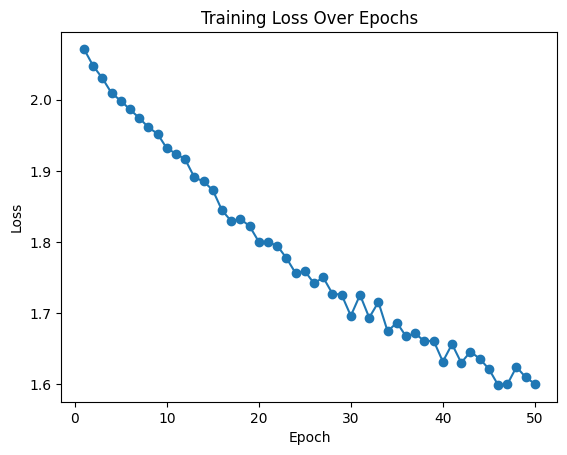

График обучения сохранен и отображен.


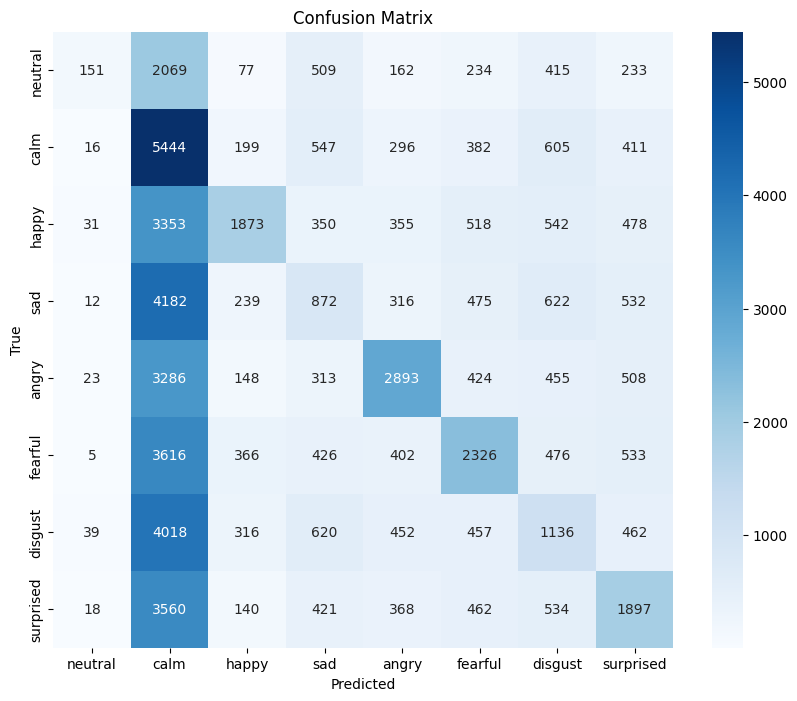

Матрица ошибок сохранена и отображена.


In [16]:
if __name__ == "__main__":
    train_file = "/content/drive/MyDrive/DS_Belhard_2/Homeworks/HW_5/DS_2_HW_5_final_v2/dataset_train_2.json"
    val_file = "/content/drive/MyDrive/DS_Belhard_2/Homeworks/HW_5/DS_2_HW_5_final_v2/dataset_val_2.json"
    output_dir = "/content/drive/MyDrive/DS_Belhard_2/Homeworks/HW_5/DS_2_HW_5_final_v2/"

    train_model(train_file, val_file, output_dir, num_epochs=50, batch_size=32, learning_rate=0.0008578837882612659)